In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from utils.utils import load_config
from utils.plots import *
from dataloaders import *
from models import *
from validate import *

from utils.plots import *

import pickle

In [2]:
device = 'cuda'
folder = 'UNIFESP+iCOPE'
model = 'VGGNB_hist'
path_experiments = f'experiments\\{folder}\\{model}'
path_calibration_data = 'Datasets\\Calibration'

In [3]:
positive_threshold = 0.5

In [4]:
results = dict()
calib_results = dict()

embeddings = []

def hook(model, input, output):
    output = output.detach().cpu().numpy()
    for x in output:
        embeddings.append(x.flatten())

In [ ]:
for exp in os.listdir(path_experiments):
    if '.pkl' not in exp and 'masks' not in exp:
        # Carregar modelo e config.yaml
        path_model = os.path.join(path_experiments, exp, 'Model','best_model.pt')
        path_yaml = os.path.join(path_experiments, exp, 'Model','config.yaml')

        # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
        config = load_config(path_yaml)
        test_path = config['path_test']
        fold = test_path.split('\\')[-2]

        f_hook = None

        if "NCNN" in exp:

            model = NCNN()

            # Crio o dataset
            dataset = NCNNDataset(test_path)
            test_dataloader = DataLoader(dataset, 
                                        batch_size=16, 
                                        shuffle=False)

            calib_dataset = NCNNDataset(path_calibration_data)
            calib_dataloader = DataLoader(calib_dataset,
                                        batch_size=16, 
                                        shuffle=False)      

            f_hook = model.maxpool_4.register_forward_hook(hook)   

        elif "VGGNB" in exp:

            model = VGGNB()

            dataset = VGGNBDataset(test_path)
            test_dataloader = DataLoader(dataset, 
                                        batch_size=16, 
                                        shuffle=False)

            calib_dataset = VGGNBDataset(path_calibration_data)
            calib_dataloader = DataLoader(calib_dataset,
                                        batch_size=16, 
                                        shuffle=False)

            f_hook = model.VGGFace.avgpool.register_forward_hook(hook)    

        elif "ViTNB" in exp:

            model = ViTNB()

            dataset = ViTNBDataset(test_path)
            test_dataloader = DataLoader(dataset, 
                                        batch_size=16, 
                                        shuffle=False)

            calib_dataset = ViTNBDataset(path_calibration_data)
            calib_dataloader = DataLoader(calib_dataset,
                                        batch_size=16, 
                                        shuffle=False)

                                
        # Carrego o modelo
        model.eval()
        model.load_state_dict(torch.load(path_model))
        model = model.to(device)

        probs_list = torch.empty(0, device=device)
        preds_list = torch.empty(0, device=device)
        logits_list = torch.empty(0, device=device)
        labels_list = torch.empty(0, device=device)
        embeddings = []
        img_names = dataset.img_names

        print(f'Gerando resultados para {test_path}\n')
        
        # Iteração sobre os dados salvando os probs, preds e labels
        with torch.no_grad():
            for batch in test_dataloader:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                logits = model(inputs)
                probs = F.sigmoid(logits)
                preds = torch.gt(probs, positive_threshold).type(torch.int)

                probs_list = torch.cat([probs_list, probs])
                preds_list = torch.cat([preds_list, preds])
                logits_list = torch.cat([logits_list, logits])
                labels_list = torch.cat([labels_list, labels])

        results[fold] = {'img_names':np.array(img_names),
                         'probs': probs_list.cpu().numpy(), 
                        'preds': preds_list.cpu().numpy(),
                        'logits': logits_list.cpu().numpy(),
                        'labels': labels_list.cpu().numpy(),
                        'embeddings': np.array(embeddings)}

        probs_list = torch.empty(0, device=device)
        preds_list = torch.empty(0, device=device)
        logits_list = torch.empty(0, device=device)
        labels_list = torch.empty(0, device=device)
        embeddings = []
        img_names = dataset.img_names


        # Iteração sobre os dados salvando os probs, preds e labels
        with torch.no_grad():
            for batch in calib_dataloader:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                logits = model(inputs)
                probs = F.sigmoid(logits)
                preds = torch.gt(probs, positive_threshold).type(torch.int)

                probs_list = torch.cat([probs_list, probs])
                preds_list = torch.cat([preds_list, preds])
                logits_list = torch.cat([logits_list, logits])
                labels_list = torch.cat([labels_list, labels])

        calib_results[fold] = {'img_names':np.array(img_names),
                               'probs': probs_list.cpu().numpy(), 
                            'preds': preds_list.cpu().numpy(), 
                            'labels': labels_list.cpu().numpy()}
    if f_hook:
        f_hook.remove()      

In [ ]:
with open(os.path.join(path_experiments,f'results.pkl'), 'wb') as f:
    pickle.dump(results, f)

with open(os.path.join(path_experiments,f'calib_results.pkl'), 'wb') as f:
    pickle.dump(calib_results, f)

# LOAD DATA IF NEEDED!!!

In [7]:
device = 'cuda'
folder = 'UNIFESP+iCOPE'
model = 'VGGNB'
path_experiments = f'experiments\\{folder}\\{model}'
path_calibration_data = 'Datasets\\Calibration'

In [8]:
with open(os.path.join(path_experiments,f'results.pkl'), 'rb') as f:
    results = pickle.load(f)

with open(os.path.join(path_experiments,f'calib_results.pkl'), 'rb') as f:
    calib_results = pickle.load(f)

# Metrics

In [9]:
N_BINS = 10
N_BINS_HIST = 10
mode_metrics = 'quantile'
mode_plot = 'uniform'

In [10]:
# Validation metrics
acc = np.zeros(len(results.keys()))
f1 = np.zeros(len(results.keys()))
pre = np.zeros(len(results.keys()))
rec = np.zeros(len(results.keys()))

# Calibration metrics
ece = np.zeros(len(results.keys()))
mce = np.zeros(len(results.keys()))
nll = np.zeros(len(results.keys()))
brier = np.zeros(len(results.keys()))

# Cria arrays com os resultados
for i, fold in enumerate(results.keys()):
    metrics = validation_metrics(results[fold]['preds'], results[fold]['labels'])
    acc[i] = metrics['Accuracy']
    f1[i] = metrics['F1 Score']
    pre[i] = metrics['Precision']
    rec[i] = metrics['Recall']

    calibration = calibration_metrics(results[fold]['probs'], results[fold]['labels'], N_BINS, mode_metrics)
    ece[i] = calibration['ECE']
    mce[i] = calibration['MCE']
    nll[i] = calibration['NLL']
    brier[i] = calibration['Brier']

## Classification

In [ ]:
s = ''
for x in [acc,f1,pre,rec, ece,mce,nll,brier]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

In [ ]:
print(f"Acurácia      = {acc.mean():.4f} ± {acc.std():.2f}")
print(f"F1            = {f1.mean():.4f} ± {f1.std():.2f}")
print(f"Precisão      = {pre.mean():.4f} ± {pre.std():.2f}")
print(f"Sensibilidade = {rec.mean():.4f} ± {rec.std():.2f}")

## Calibration

In [ ]:
print(f"ECE   = {ece.mean():.4f} ± {ece.std():.2f}")
print(f"MCE   = {mce.mean():.4f} ± {mce.std():.2f}")
print(f"NLL   = {nll.mean():.4f} ± {nll.std():.2f}")
print(f"Brier = {brier.mean():.4f} ± {brier.std():.2f}")

# Plots

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (accuracy_score, average_precision_score,
                             confusion_matrix, f1_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from calibration.metrics import ECE, calibration_curve

In [15]:

alpha = 0.2

In [16]:
def pad_average_arrays(arrays):
    max_length = max(len(arr) for arr in arrays)
    padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode='edge') for arr in arrays]
    stacked_arrays = np.vstack(padded_arrays)
    
    return np.mean(stacked_arrays, axis=0), np.std(stacked_arrays, axis=0)

In [17]:
def calib_pad_average_arrays(arrays):
    max_length = max(len(arr) for arr in arrays)

    avg = []
    std = []

    for i in range(max_length):
        values = []
        for arr in arrays:
            if i < len(arr):
                values.append(arr[i])
        
        values = np.array(values)
        avg.append(np.mean(values))
        std.append(np.std(values))

    return np.array(avg), np.array(std)

## Precision Recall Curve

In [18]:
def avg_pre_rec_curve(results):

    list_precision = []
    list_recall = []
    ap_list = []

    for fold in results.keys():

        precision, recall, _ = precision_recall_curve(results[fold]['labels'], results[fold]['probs'])

        ap = average_precision_score(results[fold]['labels'], results[fold]['probs'])

        list_precision.append(precision)
        list_recall.append(recall)
        ap_list.append(ap)

    average_precision, std_prec = pad_average_arrays(list_precision)
    average_recall, std_rec = pad_average_arrays(list_recall)

    average_ap = np.array(ap_list).mean()
    std_ap = np.array(ap_list).std()

    return average_precision, std_prec, average_recall, std_rec, average_ap, std_ap

In [19]:
average_precision, std_prec, average_recall, std_rec, average_ap, std_ap = avg_pre_rec_curve(results)

In [ ]:
#for recall, precision in zip(list_recall, list_precision):
    #plt.plot(recall, precision, color='#d4d4d2')
    
plt.plot(average_recall, average_precision, label=f'AP = {average_ap:.4f} ± {std_ap:.2f}')
plt.fill_between(average_recall, np.clip(average_precision-std_prec,0,1),np.clip(average_precision+std_prec,0,1), alpha=alpha, edgecolor='None')

plt.title(f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

## ROC Curve

In [21]:
def avg_roc_curve(results):

    list_fpr = []
    list_tpr = []
    auc_list = []

    for fold in results.keys():

        fpr, tpr, _ = roc_curve(results[fold]['labels'], results[fold]['probs'])

        auc = roc_auc_score(results[fold]['labels'], results[fold]['probs'])

        list_fpr.append(fpr)
        list_tpr.append(tpr)
        auc_list.append(auc)

    average_fpr, std_fpr = pad_average_arrays(list_fpr)
    average_tpr, std_tpr = pad_average_arrays(list_tpr)

    average_auc = np.array(auc_list).mean()
    std_auc = np.array(auc_list).std()

    return average_fpr, std_fpr, average_tpr, std_tpr, average_auc, std_auc

In [22]:
average_fpr, std_fpr, average_tpr, std_tpr, average_auc, std_auc = avg_roc_curve(results)

In [ ]:
#for fpr, tpr in zip(list_fpr, list_tpr):
    #plt.plot(fpr, tpr, color='#d4d4d2')

plt.plot(average_fpr, average_tpr, label=f'AUC = {average_auc:.4f} ± {std_auc:.2f}')
plt.fill_between(average_fpr, np.clip(average_tpr-std_tpr,0,1),np.clip(average_tpr+std_tpr,0,1), alpha=alpha, edgecolor='None')

idx_probs = np.argmax(average_tpr - average_fpr)

plt.plot(average_fpr[idx_probs],average_tpr[idx_probs] , '^r', markersize=8)

#plt.title(f'ROC Curve')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.savefig(f"roc_curve.png", dpi=150, bbox_inches='tight')

## Calibration Curve

In [24]:
def avg_calibration_curve(results):

    list_prob_true = []
    list_prob_pred = []
    list_probs = []
    ece_list = []

    for fold in results.keys():

        prob_true, prob_pred, _ =  calibration_curve(results[fold]['probs'], results[fold]['labels'], n_bins=N_BINS, mode=mode_plot)

        ece = ECE(results[fold]['probs'], results[fold]['labels'], n_bins=N_BINS, mode=mode_metrics)

        list_prob_true.append(prob_true)
        list_prob_pred.append(prob_pred)
        list_probs.extend(results[fold]['probs'])
        ece_list.append(ece)

    average_prob_true, std_prob = calib_pad_average_arrays(list_prob_true)
    average_prob_pred, std_pred = calib_pad_average_arrays(list_prob_pred)

    list_probs = np.array(list_probs)
    average_ece = np.array(ece_list).mean()
    std_ece = np.array(ece_list).std()

    return average_prob_true, std_prob, average_prob_pred, std_pred, list_probs, average_ece, std_ece

In [25]:
average_prob_true, std_prob, average_prob_pred, std_pred, list_probs, average_ece, std_ece = avg_calibration_curve(results)

In [ ]:
fig = plt.figure()

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.02)

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.05)

ax_curve = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1])

#for prob_pred, prob_true in zip(list_prob_pred, list_prob_true):
    #ax_curve.plot(prob_pred, prob_true, color='#d4d4d2')


ax_curve.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle=":", color='#9e9e9e')

ax_curve.plot(average_prob_pred, average_prob_true, marker='o', label=f'ECE = {average_ece:.4f} ± {std_ece:.2f}')
#ax_curve.fill_between(average_prob_pred, np.clip(average_prob_true-std_prob,0,1),np.clip(average_prob_true+std_prob,0,1), alpha=0.3, edgecolor='None')

ax_hist.hist(list_probs, bins=np.linspace(0.0, 1.0, 10+1), edgecolor = 'black')

ax_curve.set_ylabel('Fração de Positivos')
ax_curve.legend(loc='upper left')
ax_curve.set_ylim([0,1.01])
ax_curve.set_xlim([0,1.01])
ax_curve.set_xticklabels([])

ax_hist.set_xlabel('Probabilidade Prevista Média')
ax_hist.set_ylabel('Quantidade')
ax_hist.set_xlim([0,1])
plt.savefig('calib_plot.png', dpi=150, bbox_inches='tight')


## Other Metrics

In [27]:
def avg_metrics(results):
    
    list_acc = []
    list_f1 = []
    list_pre = []
    list_rec = []
    list_samples = []

    result_acc = []
    result_f1 = []
    result_pre = []
    result_rec = []

    threshold = np.arange(0., 1.01, 0.01).round(3)

    for fold in results.keys():
        above_threshold_acc = []
        above_threshold_f1 = []
        above_threshold_pre = []
        above_threshold_rec = []
        above_threshold_samples = []

        for i,thr in enumerate(threshold):
            preds = (results[fold]['probs'] > thr).astype(int)
            labels = results[fold]['labels']
            #preds = results[fold]['preds'][(results[fold]['probs'] <+ thr) | (results[fold]['probs'] >= 1-thr)]
            #labels = results[fold]['labels'][(results[fold]['probs'] <= thr) | (results[fold]['probs'] >= 1-thr)]

            if len(labels) != 0:
                above_threshold_acc.append(accuracy_score(labels, preds))
                above_threshold_f1.append(f1_score(labels, preds, zero_division=0))
                above_threshold_pre.append(precision_score(labels, preds, zero_division=0))
                above_threshold_rec.append(recall_score(labels, preds, zero_division=0))
                above_threshold_samples.append(len(labels)/len(results[fold]['labels']))

            if thr == 0.5:
                result_acc.append(above_threshold_acc[i])
                result_f1.append(above_threshold_f1[i])
                result_pre.append(above_threshold_pre[i])
                result_rec.append(above_threshold_rec[i])

        list_acc.append(above_threshold_acc)
        list_f1.append(above_threshold_f1)
        list_pre.append(above_threshold_pre)
        list_rec.append(above_threshold_rec)
        list_samples.append(above_threshold_samples)

    average_samples, std_samples = pad_average_arrays(list_samples)
    
    average_acc, std_acc = pad_average_arrays(list_acc)
    #average_acc = np.append(average_acc, average_acc[::-1][1:])
    #std_acc = np.append(std_acc, std_acc[::-1][1:])

    average_f1, std_f1 = pad_average_arrays(list_f1)
  
    average_pre, std_pre = pad_average_arrays(list_pre)

    average_rec, std_rec = pad_average_arrays(list_rec)

    average_result_acc = np.array(result_acc).mean()
    std_result_acc = np.array(result_acc).std()

    average_result_f1 = np.array(result_f1).mean()
    std_result_f1 = np.array(result_f1).std()

    average_result_pre = np.array(result_pre).mean()
    std_result_pre = np.array(result_pre).std()

    average_result_rec = np.array(result_rec).mean()
    std_result_rec = np.array(result_rec).std()

    threshold = np.arange(0., 1.01, 0.01).round(3)

    return threshold, average_acc, std_acc, average_f1, std_f1, average_pre, std_pre, \
           average_rec, std_rec, average_result_acc, std_result_acc, average_result_f1, \
           std_result_f1, average_result_pre, std_result_pre, average_result_rec, std_result_rec, average_samples, std_samples

In [28]:
threshold, average_acc, std_acc, average_f1, std_f1, average_pre, std_pre, \
average_rec, std_rec, average_result_acc, std_result_acc, average_result_f1, \
std_result_f1, average_result_pre, std_result_pre, average_result_rec, std_result_rec, average_samples, std_samples = avg_metrics(results)

### Accuracy

In [ ]:
#for acc in list_acc:
    #nonzero = np.array(acc) != 0
    #plt.plot(threshold[nonzero], acc[nonzero], color='#d4d4d2')

nonzero = np.array(average_acc) != 0
plt.plot(threshold[nonzero], average_acc[nonzero], label=f'Accuracy at 0.5 = {average_result_acc:.4f} ± {std_result_acc:.2f}')
plt.fill_between(threshold[nonzero], np.clip(average_acc[nonzero]-std_acc[nonzero],0,1),np.clip(average_acc[nonzero]+std_acc[nonzero],0,1), alpha=alpha, edgecolor='None')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.legend()

### F1 Score

In [ ]:
#for f1 in list_f1:
    #nonzero = np.array(f1) != 0
    #plt.plot(threshold[nonzero], f1[nonzero], color='#d4d4d2')

nonzero = np.array(average_f1) != 0
plt.plot(threshold[nonzero], average_f1[nonzero], label=f'F1 Score at 0.5 = {average_result_f1:.4f} ± {std_result_f1:.2f}')
plt.fill_between(threshold[nonzero], np.clip(average_f1[nonzero]-std_f1[nonzero],0,1),np.clip(average_f1[nonzero]+std_f1[nonzero],0,1), alpha=alpha, edgecolor='None')

plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.legend()

### Precision

In [ ]:
#for pre in list_pre:
    #nonzero = np.array(pre) != 0
    #plt.plot(threshold[nonzero], pre[nonzero], color='#d4d4d2')

nonzero = np.array(average_pre) != 0
plt.plot(threshold[nonzero], average_pre[nonzero], label=f'Precision at 0.5 = {average_result_pre:.4f} ± {std_result_pre:.2f}')
plt.fill_between(threshold[nonzero], np.clip(average_pre[nonzero]-std_pre[nonzero],0,1),np.clip(average_pre[nonzero]+std_pre[nonzero],0,1), alpha=alpha, edgecolor='None')

plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.legend()

### Recall

In [ ]:
#for rec in list_rec:
    #nonzero = np.array(rec) != 0
    #plt.plot(threshold[nonzero], rec[nonzero], color='#d4d4d2')

nonzero = np.array(average_rec) != 0
plt.plot(threshold[nonzero], average_rec[nonzero], label=f'Recall at 0.5 = {average_result_rec:.4f} ± {std_result_rec:.2f}')
plt.fill_between(threshold[nonzero], np.clip(average_rec[nonzero]-std_rec[nonzero],0,1),np.clip(average_rec[nonzero]+std_rec[nonzero],0,1), alpha=alpha, edgecolor='None')

plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.legend()

### Probability Histogram

In [ ]:
probs = []
labels = []
for fold in results.keys():
    probs.extend(results[fold]['probs'])
    labels.extend(results[fold]['labels'])

probability_histogram(np.array(probs), np.array(labels))

In other words, positive predictive value answers the question, ‘if I have a positive test, what is the probability that I actually have the disease?’ Conversely, negative predictive value answers the question, ‘if I have a negative test, what is the probability that I actually don’t have the disease?’ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8156826/#:~:text=Positive%20predictive%20value%20reflects%20the,have%20the%20outcome%20of%20interest.

combined_score = alpha * (ppv + npv) - beta * ece

### Embeddings

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
with open(os.path.join("D:/Doutorado/Mestrado/experiments/NCNN_TRAINED_30",f'results.pkl'), 'rb') as f:
    results = pd.DataFrame(pickle.load(f))

In [36]:
results

fold                                          img_names     probs  preds  \
0       1     Datasets\Folds\1\Test\ID155_iCOPE_S14_pain.jpg  0.995508      1   
1       1     Datasets\Folds\1\Test\ID156_iCOPE_S14_pain.jpg  0.998677      1   
2       1     Datasets\Folds\1\Test\ID157_iCOPE_S14_pain.jpg  0.998382      1   
3       1   Datasets\Folds\1\Test\ID158_iCOPE_S14_nopain.jpg  0.044394      0   
4       1   Datasets\Folds\1\Test\ID159_iCOPE_S14_nopain.jpg  0.037895      0   
..    ...                                                ...       ...    ...   
516     0   Datasets\Folds\0\Test\ID616_UNIFESP_S55_pain.jpg  0.798405      1   
517     0   Datasets\Folds\0\Test\ID617_UNIFESP_S55_pain.jpg  0.595366      1   
518     0   Datasets\Folds\0\Test\ID618_UNIFESP_S55_pain.jpg  0.661770      1   
519     0  Datasets\Folds\0\Test\ID642_UNIFESP_S55_nopain...  0.028738      0   
520     0  Datasets\Folds\0\Test\ID643_UNIFESP_S55_nopain...  0.618740      1   

       logits  labels                                         embeddings  
0    5.401009       1  [0.0, 0.43759626150131226, 0.0, 0.0, 0.6100765...  
1    6.626734       1  [0.0, 0.18897858262062073, 0.0, 0.0, 1.3665666...  
2    6.424939       1  [0.0, 0.24611955881118774, 0.0, 0.0, 0.6457937...  
3   -3.069230       0  [0.0, 0.0, 0.0, 0.0, 0.9389994144439697, 0.707...  
4   -3.234315       0  [0.0, 0.0, 0.0, 0.0, 0.7072527408599854, 0.956...  
..        ...     ...                                                ...  
516  1.376355       1  [0.0, 0.0, 0.0, 0.0, 0.0, 10.120638847351074, ...  
517  0.386192       1  [0.0, 0.8373046517372131, 3.026766538619995, 4...  
518  0.671190       1  [0.0, 2.619992256164551, 2.091036319732666, 2....  
519 -3.520364       0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
520  0.484203       0  [4.05643892288208, 4.156201362609863, 1.337789...  

[521 rows x 7 columns]

In [37]:
imgs = []

for img_name in results['img_names']:
    imgs.append(cv2.resize(cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB), (64,64)))

In [38]:
embeddings_norm = MinMaxScaler().fit_transform(results['embeddings'].tolist())

In [39]:
len(results['embeddings'][0])

1600

In [40]:
embeddings_pca = PCA(n_components=2).fit_transform(embeddings_norm)
embeddings_tsne = TSNE(n_components=2).fit_transform(embeddings_norm)

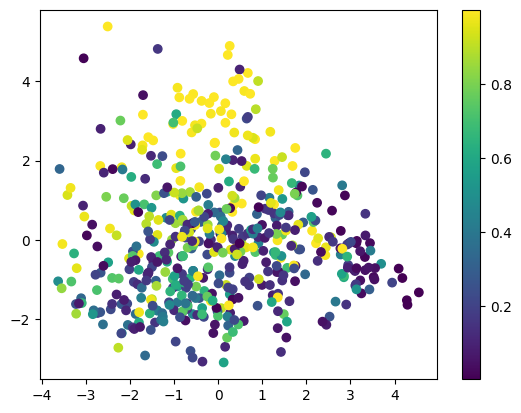

In [41]:
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=results['probs'])
plt.colorbar()

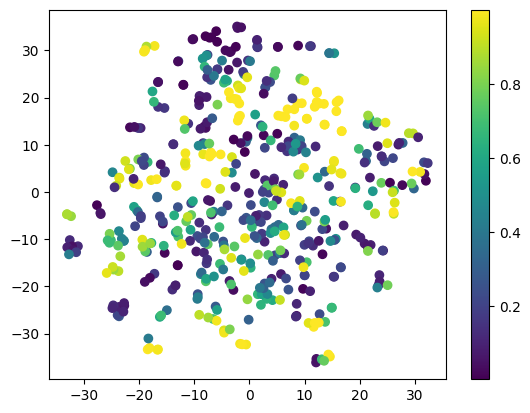

In [42]:
plt.scatter(embeddings_tsne[:,0], embeddings_tsne[:,1], c=results['probs'])
plt.colorbar()

In [43]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

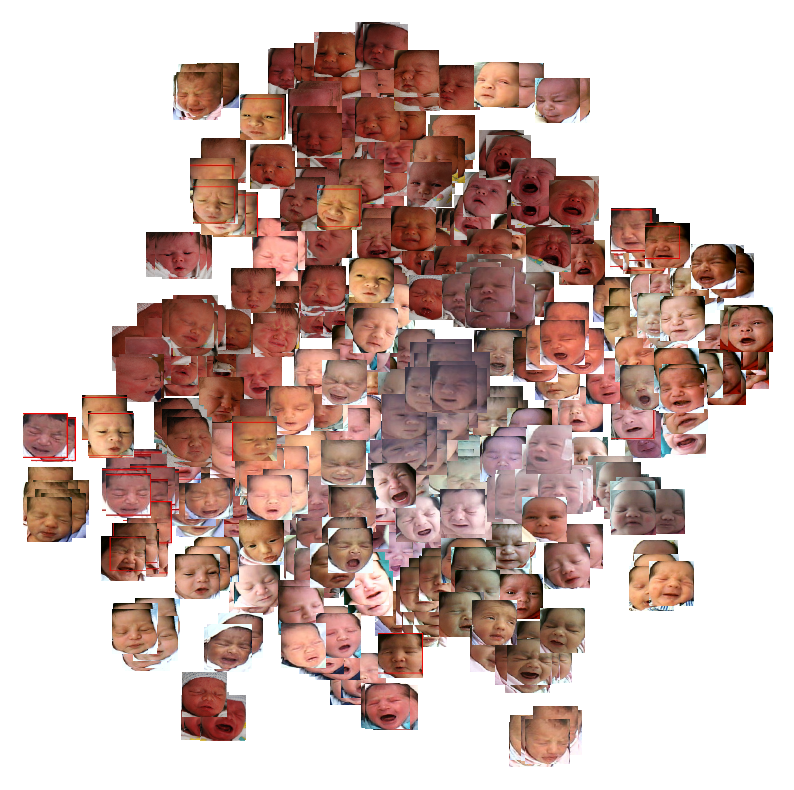

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
artists = []
for xy, i in zip(embeddings_tsne, imgs):
    x0, y0 = xy
    img = OffsetImage(i, zoom=0.5)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
ax.update_datalim(embeddings_tsne)
ax.autoscale()
plt.axis('off')
plt.show() 

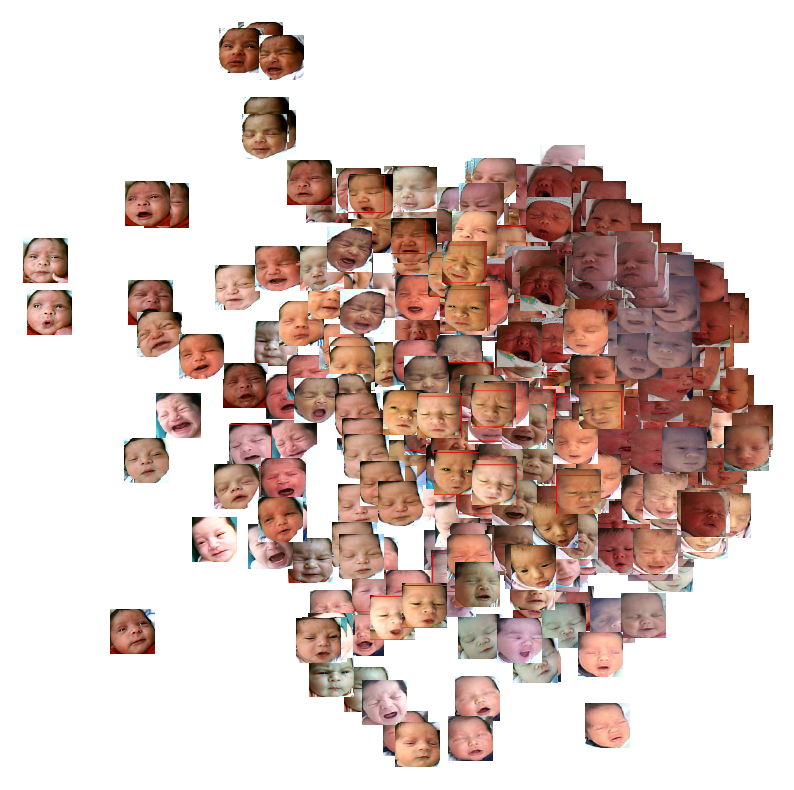

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
artists = []
for xy, i in zip(embeddings_pca, imgs):
    x0, y0 = xy
    img = OffsetImage(i, zoom=0.5)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
ax.update_datalim(embeddings_pca)
ax.autoscale()
plt.axis('off')
plt.show() 

In [38]:
probs = []
embeddings = []
colors_errors = []
imgs = []
correct = []

for fold in results.keys():
    probs.extend(results[fold]['probs'])
    embeddings.extend(results[fold]['embeddings'])
    correct.extend(results[fold]['preds'])

    for img_name in results[fold]['img_names']:
        imgs.append(cv2.resize(cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB), (64,64)))
    
    labels = results[fold]['labels']
    preds = results[fold]['preds']

    for label, pred in zip(labels, preds):
        if label == pred and label == 1:
            colors_errors.append(0)
        elif label == pred and label == 0:
            colors_errors.append(1)
        elif label != pred and label == 0:
            colors_errors.append(2)
        elif label != pred and label == 1:
            colors_errors.append(3)
            
probs = np.array(probs)
embeddings = np.array(embeddings)

embeddings_norm = MinMaxScaler().fit_transform(embeddings)


In [39]:
embeddings_pca = PCA(n_components=2).fit_transform(embeddings_norm)
embeddings_tsne = TSNE(n_components=2).fit_transform(embeddings_norm)

In [ ]:
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=probs)
plt.colorbar()

In [ ]:
plt.scatter(embeddings_tsne[:,0], embeddings_tsne[:,1], c=probs)
plt.colorbar()

# Calibration

In [302]:
from calibration.calibrators import *
from scipy.stats import ttest_rel, kstest

In [303]:
def metrics_before_after(results, calib_results, calibrator=None):

    ece_list_before = []
    ece_list_after = []
    mce_list_before = []
    mce_list_after = []
    nll_list_before = []
    nll_list_after = []
    brier_list_before = []
    brier_list_after = []

    acc_list_before = []
    acc_list_after = []
    f1_list_before = []
    f1_list_after = []
    prec_list_before = []
    prec_list_after = []
    rec_list_before = []
    rec_list_after = []

    for fold in results.keys():
        metrics_calib_before = calibration_metrics(results[fold]['probs'], results[fold]['labels'], N_BINS, mode=mode_metrics)
        metrics_validation_before = validation_metrics(results[fold]['preds'], results[fold]['labels'])

        if (calibrator == 'LS') or (calibrator == "MCDropout"):
            metrics_calib_after = calibration_metrics(calib_results[fold]['probs'], calib_results[fold]['labels'], N_BINS, mode=mode_metrics)
            metrics_validation_after = validation_metrics(calib_results[fold]['preds'], calib_results[fold]['labels'])
            
        else:
            calibrator.fit(calib_results[fold]['probs'], calib_results[fold]['labels'])
            metrics_calib_after = calibration_metrics(calibrator.predict(results[fold]['probs']), results[fold]['labels'], N_BINS, mode=mode_metrics)
            metrics_validation_after = validation_metrics((calibrator.predict(results[fold]['probs']) > 0.5), results[fold]['labels'])

        ece_list_before.append(metrics_calib_before['ECE'])
        mce_list_before.append(metrics_calib_before['MCE'])
        nll_list_before.append(metrics_calib_before['NLL'])
        brier_list_before.append(metrics_calib_before['Brier'])

        ece_list_after.append(metrics_calib_after['ECE'])
        mce_list_after.append(metrics_calib_after['MCE'])
        nll_list_after.append(metrics_calib_after['NLL'])
        brier_list_after.append(metrics_calib_after['Brier'])

        acc_list_before.append(metrics_validation_before['Accuracy'])
        f1_list_before.append(metrics_validation_before['F1 Score'])
        prec_list_before.append(metrics_validation_before['Precision'])
        rec_list_before.append(metrics_validation_before['Recall'])

        acc_list_after.append(metrics_validation_after['Accuracy'])
        f1_list_after.append(metrics_validation_after['F1 Score'])
        prec_list_after.append(metrics_validation_after['Precision'])
        rec_list_after.append(metrics_validation_after['Recall'])

    ece_list_before = np.array(ece_list_before)
    ece_list_after = np.array(ece_list_after)
    mce_list_before = np.array(mce_list_before)
    mce_list_after = np.array(mce_list_after)
    nll_list_before = np.array(nll_list_before)
    nll_list_after = np.array(nll_list_after)
    brier_list_before = np.array(brier_list_before)
    brier_list_after = np.array(brier_list_after)
    acc_list_before = np.array(acc_list_before)
    acc_list_after = np.array(acc_list_after)
    f1_list_before = np.array(f1_list_before)
    f1_list_after = np.array(f1_list_after)
    prec_list_before = np.array(prec_list_before)
    prec_list_after = np.array(prec_list_after)
    rec_list_before = np.array(rec_list_before)
    rec_list_after = np.array(rec_list_after)


    print(f"Before - ECE {ece_list_before.mean():.4f} ± {ece_list_before.std():.2f}")
    print(f"After  - ECE {ece_list_after.mean():.4f} ± {ece_list_after.std():.2f}      pvalue = {ttest_rel(ece_list_before, ece_list_after)[1]:.4f}")
    #print(ece_list_before)
    #print(ece_list_after)
    print("_________________________________________________________")
    print(f"Before - MCE {mce_list_before.mean():.4f} ± {mce_list_before.std():.2f}")
    print(f"After  - MCE {mce_list_after.mean():.4f} ± {mce_list_after.std():.2f}      pvalue = {ttest_rel(mce_list_before, mce_list_after)[1]:.4f}")
    #print(mce_list_before)
    #print(mce_list_after)
    print("_________________________________________________________")
    print(f"Before - NLL {nll_list_before.mean():.4f} ± {nll_list_before.std():.2f}")
    print(f"After  - NLL {nll_list_after.mean():.4f} ± {nll_list_after.std():.2f}      pvalue = {ttest_rel(nll_list_before, nll_list_after)[1]:.4f}")
    #print(nll_list_before)
    #print(nll_list_after)
    print("_________________________________________________________")
    print(f"Before - Brier {brier_list_before.mean():.4f} ± {brier_list_before.std():.2f}")
    print(f"After  - Brier {brier_list_after.mean():.4f} ± {brier_list_after.std():.2f}    pvalue = {ttest_rel(brier_list_before, brier_list_after)[1]:.4f}")
    #print(brier_list_before)
    #print(brier_list_after)
    print("_________________________________________________________")
    print(f"Before - ACC {acc_list_before.mean():.4f} ± {acc_list_before.std():.2f}")
    print(f"After  - ACC {acc_list_after.mean():.4f} ± {acc_list_after.std():.2f}      pvalue = {ttest_rel(acc_list_before, acc_list_after)[1]:.4f}")
    #print(acc_list_before)
    #print(acc_list_after)
    print("_________________________________________________________")
    print(f"Before - F1 {f1_list_before.mean():.4f} ± {f1_list_before.std():.2f}")
    print(f"After  - F1 {f1_list_after.mean():.4f} ± {f1_list_after.std():.2f}       pvalue = {ttest_rel(f1_list_before, f1_list_after)[1]:.4f}")
    #print(f1_list_before)
    #print(f1_list_after)
    print("_________________________________________________________")
    print(f"Before - Prec {prec_list_before.mean():.4f} ± {prec_list_before.std():.2f}")
    print(f"After  - Prec {prec_list_after.mean():.4f} ± {prec_list_after.std():.2f}     pvalue = {ttest_rel(prec_list_before, prec_list_after)[1]:.4f}")
    #print(prec_list_before)
    #print(prec_list_after)
    print("_________________________________________________________")
    print(f"Before - Rec {rec_list_before.mean():.4f} ± {rec_list_before.std():.2f}")
    print(f"After  - Rec {rec_list_after.mean():.4f} ± {rec_list_after.std():.2f}      pvalue = {ttest_rel(rec_list_before, rec_list_after)[1]:.4f}")
    #print(rec_list_before)
    #print(rec_list_after)

    s = ''
    for x in [acc_list_after,f1_list_after,prec_list_after,rec_list_after,ece_list_after,mce_list_after,nll_list_after,brier_list_after]:
        for i in x[:-1]:
            s = s + str(i.round(4)).replace('.',',') + ';'
        s = s + str(x[-1].round(4)).replace('.',',') + '\n'
    print(s)

In [304]:
def calibration_before_after(results, calib_results, calibrator):

    list_prob_true = []
    list_prob_pred = []
    list_probs = []
    ece_list = []

    list_prob_true_calib = []
    list_prob_pred_calib = []
    list_probs_calib = []
    ece_calib_list = []


    for fold in results.keys():

        prob_true, prob_pred, _ =  calibration_curve(results[fold]['probs'], results[fold]['labels'], n_bins=N_BINS, mode=mode_plot)
        ece = ECE(results[fold]['probs'], results[fold]['labels'], n_bins=N_BINS, mode=mode_metrics)

        if (calibrator == 'LS') or (calibrator == "MCDropout"):
            prob_true_calib, prob_pred_calib, _ =  calibration_curve(calib_results[fold]['probs'], calib_results[fold]['labels'], n_bins=N_BINS, mode=mode_plot)
            ece_calib = ECE(calib_results[fold]['probs'], calib_results[fold]['labels'], n_bins=N_BINS, mode=mode_metrics)
            list_probs_calib.extend(calib_results[fold]['probs'])

        else:
            calibrator.fit(calib_results[fold]['probs'], calib_results[fold]['labels'])
            prob_true_calib, prob_pred_calib, _ =  calibration_curve(calibrator.predict(results[fold]['probs']), results[fold]['labels'], n_bins=N_BINS, mode=mode_plot)
            ece_calib = ECE(calibrator.predict(results[fold]['probs']), results[fold]['labels'], n_bins=N_BINS, mode=mode_metrics)
            list_probs_calib.extend(calibrator.predict(results[fold]['probs']))

        list_prob_true.append(prob_true)
        list_prob_pred.append(prob_pred)
        list_probs.extend(results[fold]['probs'])
        ece_list.append(ece)
        list_prob_true_calib.append(prob_true_calib)
        list_prob_pred_calib.append(prob_pred_calib)

        ece_calib_list.append(ece_calib)

    average_prob_true, std_prob = calib_pad_average_arrays(list_prob_true)
    average_prob_pred, std_pred = calib_pad_average_arrays(list_prob_pred)

    average_prob_true_calib, std_prob_calib = calib_pad_average_arrays(list_prob_true_calib)
    average_prob_pred_calib, std_pred_calib = calib_pad_average_arrays(list_prob_pred_calib)

    list_probs = np.array(list_probs)
    average_ece = np.array(ece_list).mean()
    std_ece = np.array(ece_list).std()

    list_probs_calib = np.array(list_probs_calib)
    average_ece_calib = np.array(ece_calib_list).mean()
    std_ece_calib = np.array(ece_calib_list).std()

    # PLOTTING
    fig = plt.figure()

    gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.05)

    ax_curve = fig.add_subplot(gs[0])
    ax_hist = fig.add_subplot(gs[1])

    ax_curve.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle=":", color='#9e9e9e')

    #for prob_pred, prob_true in zip(list_prob_pred_calib, list_prob_true_calib):
        #ax_curve.plot(prob_pred, prob_true, color='#d4d4d2')

    #ax_curve.plot(average_prob_pred, average_prob_true, marker='o', label=f"$ECE_{{Sem MCDP}}$ = {average_ece:.4f} ± {std_ece:.2f}")
    ax_curve.plot(average_prob_pred_calib, average_prob_true_calib, marker='s', label=f'ECE = {average_ece_calib:.4f} ± {std_ece_calib:.2f}')

    #ax_curve.fill_between(average_prob_pred, np.clip(average_prob_true-std_prob,0,1),np.clip(average_prob_true+std_prob,0,1), alpha=0.3, edgecolor='None')
    #ax_curve.fill_between(average_prob_pred_calib, np.clip(average_prob_true_calib-std_prob_calib,0,1),np.clip(average_prob_true_calib+std_prob_calib,0,1), alpha=0.3, edgecolor='None')

    #ax_curve.errorbar(average_prob_pred, average_prob_true, yerr=std_prob, capsize=3, marker='o', label=f"$ECE_{{before}}$ = {average_ece:.4f} ± {std_ece:.2f}", elinewidth=1)
    #ax_curve.errorbar(average_prob_pred_calib, average_prob_true_calib, yerr=std_prob_calib, capsize=3, marker='s', label=f'$ECE_{{after}}$ = {average_ece_calib:.4f} ± {std_ece_calib:.2f}', elinewidth=1)

    #ax_hist.hist(list_probs, bins=np.linspace(0.0, 1.0, N_BINS_HIST+1), alpha=0.8, edgecolor = 'black')
    ax_hist.hist(list_probs_calib, bins=np.linspace(0.0, 1.0, N_BINS_HIST+1), edgecolor = 'black')

    #sns.kdeplot(list_probs, clip=[0,1], ax=ax_hist)
    #sns.kdeplot(list_probs_calib, clip=[0,1], ax=ax_hist)

    #x = np.arange(0,1,0.1)
    #y = 1 / (1+np.exp((platt.A * x + platt.B)))

    #ax_curve.plot(x, y, 'g')

    #ax_curve.set_title('Calibration Curve')
    ax_curve.set_ylabel('Fração de Positivos')
    ax_curve.legend(loc='upper left')
    ax_curve.set_ylim([0,1.01])
    ax_curve.set_xlim([0,1.01])
    ax_curve.set_xticklabels([])

    ax_hist.set_xlabel('Probabilidade Prevista Média')
    ax_hist.set_ylabel('Quantidade')
    ax_hist.set_xlim([0,1])
    plt.savefig('calib_plot.png', dpi=300, bbox_inches='tight')

In [305]:
from utils.plots import *

In [306]:
def histogram_errors(results, calib_results, calibrator):

    probs = []
    labels = []

    for fold in results.keys():

        if (calibrator == 'LS') or (calibrator == "MCDropout"):
            probs.extend(calib_results[fold]['probs'])
            labels.extend(calib_results[fold]['labels'])
            
        else:
            calibrator.fit(calib_results[fold]['probs'], calib_results[fold]['labels'])

            probs.extend(calibrator.predict(results[fold]['probs']))
            labels.extend(results[fold]['labels'])

    probability_histogram(np.array(probs), np.array(labels))

## Platt Scaling

In [307]:
platt = PlattScaling()

In [ ]:
metrics_before_after(results, calib_results, platt)

In [ ]:
platt.A

In [ ]:
platt.B

In [ ]:
calibration_before_after(results, calib_results, platt)

In [ ]:
histogram_errors(results, calib_results, platt)

## Temperature Scaling

In [313]:
temp = TemperatureScaling()

In [ ]:
metrics_before_after(results, calib_results, temp)

In [ ]:
temp.T

In [ ]:
calibration_before_after(results, calib_results, temp)

In [ ]:
histogram_errors(results, calib_results, temp)

## Isotonic Regressor

In [318]:
iso = IsotonicRegressor()

In [ ]:
metrics_before_after(results, calib_results, iso)

In [ ]:
calibration_before_after(results, calib_results, iso)

In [ ]:
histogram_errors(results, calib_results, iso)

## Histogram Binning

In [322]:
hist_bin = HistogramBinning()

In [ ]:
metrics_before_after(results, calib_results, hist_bin)

In [ ]:
calibration_before_after(results, calib_results, hist_bin)

In [ ]:
histogram_errors(results, calib_results, hist_bin)

## Label Smoothing

### 0.1

In [326]:
path_to_LS = path_experiments + "_LS_01"

with open(os.path.join(path_to_LS, 'results.pkl'), 'rb') as f:
    calib_results = pickle.load(f)

In [ ]:
metrics_before_after(results, calib_results, 'LS')

In [ ]:
calibration_before_after(results, calib_results, 'LS')

In [ ]:
histogram_errors(results, calib_results, 'LS')

### 0.3

In [330]:
path_to_LS = path_experiments + "_LS_03"

with open(os.path.join(path_to_LS, 'results.pkl'), 'rb') as f:
    calib_results = pickle.load(f)

In [ ]:
metrics_before_after(results, calib_results, 'LS')

In [ ]:
calibration_before_after(results, calib_results, 'LS')

In [ ]:
histogram_errors(results, calib_results, 'LS')

### 0.5

In [334]:
path_to_LS = path_experiments + "_LS_05"

with open(os.path.join(path_to_LS, 'results.pkl'), 'rb') as f:
    calib_results = pickle.load(f)

In [ ]:
metrics_before_after(results, calib_results, 'LS')

In [ ]:
calibration_before_after(results, calib_results, 'LS')

In [ ]:
histogram_errors(results, calib_results, 'LS')

### Soft labels

### Step

In [338]:
path_to_LS = path_experiments + "_STEP"
#path_to_LS = 'experiments\\NCNN_UNIFESP_SOFT_STEP'

with open(os.path.join(path_to_LS, 'results.pkl'), 'rb') as f:
    calib_results = pickle.load(f)

In [ ]:
metrics_before_after(results, calib_results, 'LS')

In [ ]:
calibration_before_after(results, calib_results, 'LS')

In [ ]:
histogram_errors(results, calib_results, 'LS')

### Linear

In [342]:
path_to_LS = path_experiments + "_LINEAR"
#path_to_LS = 'experiments\\NCNN_UNIFESP_SOFT_STEP'

with open(os.path.join(path_to_LS, 'results.pkl'), 'rb') as f:
    calib_results = pickle.load(f)

In [ ]:
metrics_before_after(results, calib_results, 'LS')

In [ ]:
calibration_before_after(results, calib_results, 'LS')

In [ ]:
histogram_errors(results, calib_results, 'LS')

### Sigmoid

In [346]:
path_to_LS = path_experiments + "_SIGMOID"
#path_to_LS = 'experiments\\NCNN_UNIFESP_SOFT_STEP'

with open(os.path.join(path_to_LS, 'results.pkl'), 'rb') as f:
    calib_results = pickle.load(f)

In [ ]:
metrics_before_after(results, calib_results, 'LS')

In [ ]:
calibration_before_after(results, calib_results, 'LS')

In [ ]:
histogram_errors(results, calib_results, 'LS')

# Quantificação incerteza

### MCDroput

In [4]:
import os

device = 'cuda'
folder = 'UNIFESP+iCOPE'
model = 'VGGNB_LS_01'
path_experiments = f'experiments\\{folder}\\{model}'
path_calibration_data = 'Datasets\\Calibration'

In [ ]:
test_correct = []
test_incorrect = []

for exp in os.listdir(path_experiments):
    if '.pkl' not in exp and 'masks' not in exp:
        # Carregar modelo e config.yaml
        path_model = os.path.join(path_experiments, exp, 'Model','best_model.pt')
        path_yaml = os.path.join(path_experiments, exp, 'Model','config.yaml')

        # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
        config = load_config(path_yaml)
        test_path = config['path_test']
        fold = test_path.split('\\')[-2]

        if "NCNN" in exp:

            model = NCNN()

            # Crio o dataset
            dataset = NCNNDataset(test_path)
            test_dataloader = DataLoader(dataset, 
                                        batch_size=1, 
                                        shuffle=False)
           
        elif "VGGNB" in exp:

            model = VGGNB()

            dataset = VGGNBDataset(test_path)
            test_dataloader = DataLoader(dataset, 
                                        batch_size=1, 
                                        shuffle=False)
                                
        # Carrego o modelo
        model.eval()
        model.load_state_dict(torch.load(path_model))
        model = model.to(device)

        calibrator = MCDropout(model, p=0.5)

        probs_list = []
        preds_list = []
        labels_list = []

        print(f'Gerando resultados para {test_path}\n')
        
        
        # Iteração sobre os dados salvando os probs, preds e labels
        with torch.no_grad():
            for batch in test_dataloader:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)
                labels = labels[0].cpu().numpy()

                probs = calibrator.predict(inputs, reps=30)
                probs_mean = probs.mean()
                probs_std = probs.std()
                preds = (probs_mean > positive_threshold).astype(int)
                if labels == preds:
                    test_correct.append(probs_std)
                else:
                    test_incorrect.append(probs_std)
                #entropy = probs * -np.log(probs+1e-10)
                
                probs_list.append(probs_mean)
                preds_list.append(preds)
                labels_list.append(labels)

        calib_results[fold] = {'probs': np.array(probs_list), 
                                'preds': np.array(preds_list),
                                'labels': np.array(labels_list)}

In [ ]:
metrics_before_after(results, calib_results, 'MCDropout')

In [ ]:
calibration_before_after(results, calib_results, 'MCDropout')

In [ ]:
histogram_errors(results, calib_results, 'MCDropout')

# data aug calib

In [ ]:
"""
import os
import pickle
from ast import literal_eval

import albumentations as A
import cv2
import pandas as pd
from tqdm import tqdm

from utils.utils import create_folder, scale_coords

# Constants
FOLDS_FOLDER_PATH = os.path.join('Datasets', 'Calibration')
N_FOLDS = 1
AUGMENTED_IMAGES = 20
AUGMENTED_SUFFIX = "_AUG_"


def resize_original_img(path, file_name):
    # Read image
    
    # Scale the landmarks to the cropped face
    scaled_landmarks = [scale_coords(x, y, face_coords[0], face_coords[1]) for x, y in landmarks_coords]
    resized = resize(image=img, keypoints=scaled_landmarks)

    # Save landmarks and resized image
    cv2.imwrite(os.path.join(path, file_name), resized['image'])

    return img, scaled_landmarks

# Augmentation Pipeline, Affine transformation is always applied, the Horizontal
# Flip and RandomBrightnessContrast are applied with a 50% chance. All images and
# and keypoints are resized to 512x512 
transform = A.Compose(
    [
        A.Affine(
            scale=(0.70, 1.5),
            translate_percent=(-0.2, 0.2),
            rotate=(-30, 30),
            shear=(-10, 10),
            mode=cv2.BORDER_REPLICATE,
            p=1.0,
        ),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Resize(height=512, width=512, interpolation=cv2.INTER_CUBIC, p=1.0),
    ],
)


# Read the data from the .csv
iCOPE_UNIFESP_data = pd.read_csv('iCOPE+UNIFESP_data.csv')
iCOPE_UNIFESP_data['face_coordinates'] = iCOPE_UNIFESP_data['face_coordinates'].apply(lambda x: literal_eval(x))
iCOPE_UNIFESP_data['landmarks_coordinates'] = iCOPE_UNIFESP_data['landmarks_coordinates'].apply(lambda x: literal_eval(x))

# For each Fold the images are augmented 20 times, verifying that the landmarks
# are still in bounds of the new image

print('Applying to Train Set')
for file_name in tqdm(os.listdir(FOLDS_FOLDER_PATH)):
    if file_name.endswith('.jpg'):
        img = cv2.imread(os.path.join(FOLDS_FOLDER_PATH, file_name))

        for i in range(AUGMENTED_IMAGES):
            transformed = transform(image=img)

            # Save image
            aug_file_name = f'{i:02}{AUGMENTED_SUFFIX}{file_name}'
            cv2.imwrite(os.path.join(FOLDS_FOLDER_PATH, aug_file_name), transformed['image'])
"""


# estudo do nnúmero de intervalos

In [24]:
def _bin_data(probs: np.ndarray,
              labels: np.ndarray,
              n_bins: int=10,
              mode: str='uniform'):
    
    if mode == 'uniform':
        # Equal width bins
        bins = np.linspace(0.0, 1.0, n_bins + 1)
    elif mode == 'quantile':
        # Same number of samples in each bin
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.percentile(probs, quantiles * 100)

    binids = np.searchsorted(bins[1:-1], probs)

    unique_bins = np.unique(binids)
    
    std = []
    for unique_bin in unique_bins:
        test = probs[binids==unique_bin]
        std.append(test.std())

    bin_sums = np.bincount(binids, weights=probs, minlength=len(bins))
    bin_true = np.bincount(binids, weights=labels, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    return  (prob_true, prob_pred, bin_total[nonzero], np.array(std).mean())


def ECE(probs: np.ndarray,
        labels: np.ndarray,
        n_bins: int=10,
        mode: str='uniform'):
   
    prob_true, prob_pred, bin_total, stds = _bin_data(probs, labels, n_bins, mode)

    P =  bin_total/np.sum(bin_total)
    ece = np.sum(np.abs(prob_true - prob_pred) * P)

    return ece, stds

In [25]:
mode = 'uniform'
N_BINS = 10

In [30]:
import pickle
import pandas as pd

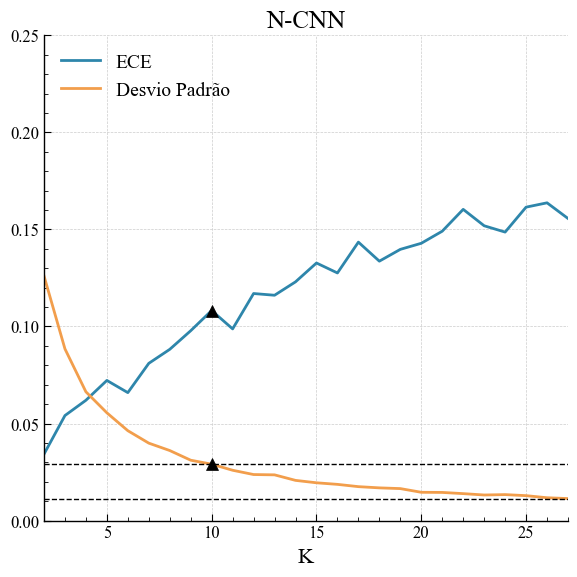

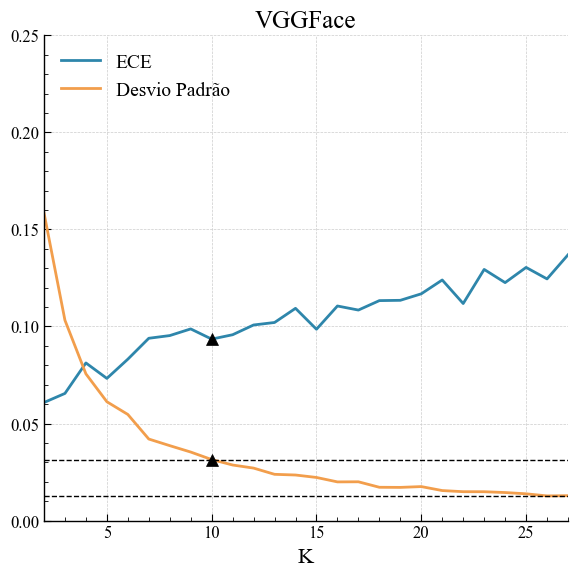

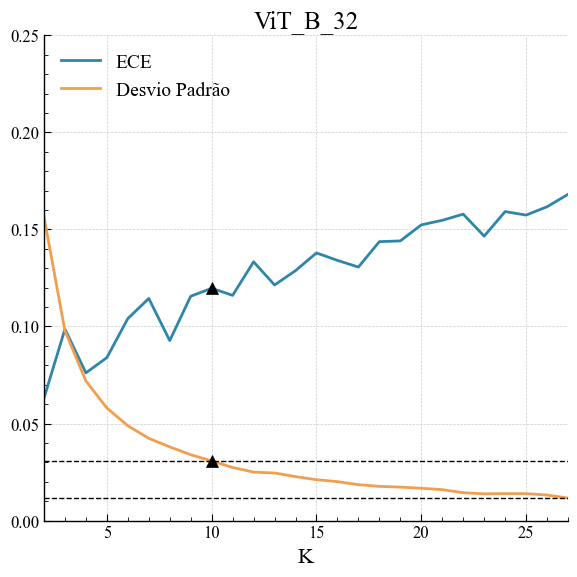

In [33]:
total = 28
step = 1

for i, model in enumerate(['NCNN', 'VGGFace', 'ViT_B_32']):

    plt.figure(figsize=(6,6))

    with open(f'experiments\\CLASSIC\\{model}\\results.pkl', 'rb') as f:
        results = pd.DataFrame(pickle.load(f))

    ece_means = []
    std_means = []

    for n_bins in range(2,total,step):

        ece_list = []
        std_bins = []

        for fold in results['fold'].unique():

            ece, std = ECE(results[results['fold']==fold]['probs'], results[results['fold']==fold]['labels'], n_bins=n_bins, mode='quantile')
            ece_list.append(ece)
            std_bins.append(std)

        ece_means.append(np.array(ece_list).mean())
        std_means.append(np.array(std_bins).mean())

        #print(f"{ece_list.mean():.4f} \t {std_bins.mean():.4f}".replace('.',','))

    plt.plot(np.arange(2,total,step), ece_means)
    plt.plot(np.arange(2,total,step), std_means)

    plt.plot(10, ece_means[8], 'k^', markersize=8)
    plt.plot(10, std_means[8], 'k^', markersize=8)

    plt.hlines(std_means[8], xmin=2, xmax=27, linestyle='--', colors='black', linewidth=1)
    plt.hlines(std_means[-1], xmin=2, xmax=27, linestyle='--', colors='black', linewidth=1)

    model = 'VGG-Face' if model == "VGGNB" else model
    model = 'N-CNN' if model == "NCNN" else model
    plt.title(model)

    plt.xlim([2,27])
    plt.ylim([0, 0.250])
    plt.legend(['ECE', 'Desvio Padrão'] ,loc='upper left')
    plt.xlabel("K")
    plt.savefig(f'k_intervalo{i}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')
    

In [ ]:
std_means[8]

# TRAINING

In [1]:
from utils.utils import load_config, create_folder
import yaml
import os

In [2]:
path = 'models\\configs\\config_NCNN.yaml'

In [3]:
list_training = {'original': {'soft_label': 'None', 'label_smoothing': 0},}

In [ ]:
list_training = {'original': {'soft_label': 'None', 'label_smoothing': 0},
                 'LS_01': {'soft_label': 'None', 'label_smoothing': 0.1},
                 'LS_03': {'soft_label': 'None', 'label_smoothing': 0.3},
                 'LS_05': {'soft_label': 'None', 'label_smoothing': 0.5},
                 'SIGMOID': {'soft_label': 'sigmoid', 'label_smoothing': 0},
                 'LINEAR': {'soft_label': 'linear', 'label_smoothing': 0},
                 'STEP': {'soft_label': 'step', 'label_smoothing': 0}}

In [4]:
for trainining_paremeters in list_training.keys():
    for i in range(0,5):

        print(f'training: {trainining_paremeters} Fold: {i}')

        config = load_config(path)
        config['path_test'] = f'Datasets\Folds\{i}\Test'
        config['path_train'] = f'Datasets\Folds\{i}\Train'
        config['soft_label'] = list_training[trainining_paremeters]['soft_label']
        config['label_smoothing'] = list_training[trainining_paremeters]['label_smoothing']

        with open(path, 'w') as file:
            yaml.dump(config, file)

        !python train.py --config $path


training: original Fold: 0
Caching images and labels, please wait...
Caching images and labels, please wait...
training: original Fold: 1


2025-05-25 13:47:50 [INFO] Starting Epoch [1/100]
2025-05-25 13:47:54 [INFO] Finished Training Epoch 1: {'Accuracy': '0.5240', 'F1 Score': '0.4438', 'Precision': '0.4872', 'Sensitivity': '0.4075', 'Specificity': '0.6258', 'AUC': '0.5392', 'ECE': '0.0179', 'MCE': '0.0563', 'NLL': 0.68852407, 'Brier': '0.2477', 'Loss': '0.6885', 'Images/s': '2232.4643'}
2025-05-25 13:47:54 [INFO] Finished Testing Epoch 1: {'Accuracy': '0.5413', 'F1 Score': '0.1667', 'Precision': '0.3571', 'Sensitivity': '0.1087', 'Specificity': '0.8571', 'AUC': '0.6360', 'ECE': '0.1001', 'MCE': '0.1594', 'NLL': 0.66656077, 'Brier': '0.2371', 'Loss': '0.6667'}
2025-05-25 13:47:54 [INFO] New best model saved with loss 0.6667
2025-05-25 13:47:54 [INFO] Starting Epoch [2/100]
2025-05-25 13:47:57 [INFO] Finished Training Epoch 2: {'Accuracy': '0.6053', 'F1 Score': '0.5435', 'Precision': '0.5894', 'Sensitivity': '0.5042', 'Specificity': '0.6935', 'AUC': '0.6395', 'ECE': '0.0363', 'MCE': '0.2422', 'NLL': 0.6643623, 'Brier': '0.

Caching images and labels, please wait...
Caching images and labels, please wait...
training: original Fold: 2


2025-05-25 13:51:10 [INFO] Starting Epoch [1/100]
2025-05-25 13:51:14 [INFO] Finished Training Epoch 1: {'Accuracy': '0.5542', 'F1 Score': '0.3945', 'Precision': '0.4897', 'Sensitivity': '0.3303', 'Specificity': '0.7300', 'AUC': '0.5653', 'ECE': '0.0146', 'MCE': '0.1409', 'NLL': 0.67920613, 'Brier': '0.2432', 'Loss': '0.6790', 'Images/s': '2262.3337'}
2025-05-25 13:51:14 [INFO] Finished Testing Epoch 1: {'Accuracy': '0.4898', 'F1 Score': '0.5370', 'Precision': '0.5179', 'Sensitivity': '0.5577', 'Specificity': '0.4130', 'AUC': '0.4749', 'ECE': '0.0838', 'MCE': '0.3463', 'NLL': 0.7211954, 'Brier': '0.2633', 'Loss': '0.7295'}
2025-05-25 13:51:14 [INFO] New best model saved with loss 0.7295
2025-05-25 13:51:14 [INFO] Starting Epoch [2/100]
2025-05-25 13:51:18 [INFO] Finished Training Epoch 2: {'Accuracy': '0.5826', 'F1 Score': '0.4754', 'Precision': '0.5313', 'Sensitivity': '0.4301', 'Specificity': '0.7022', 'AUC': '0.6049', 'ECE': '0.0104', 'MCE': '0.0909', 'NLL': 0.66975784, 'Brier': '0.

Caching images and labels, please wait...
Caching images and labels, please wait...
training: original Fold: 3


2025-05-25 13:55:09 [INFO] Starting Epoch [1/100]
2025-05-25 13:55:13 [INFO] Finished Training Epoch 1: {'Accuracy': '0.5363', 'F1 Score': '0.4323', 'Precision': '0.5000', 'Sensitivity': '0.3807', 'Specificity': '0.6708', 'AUC': '0.5430', 'ECE': '0.0103', 'MCE': '0.1265', 'NLL': 0.68733, 'Brier': '0.2472', 'Loss': '0.6874', 'Images/s': '2243.3690'}
2025-05-25 13:55:13 [INFO] Finished Testing Epoch 1: {'Accuracy': '0.5745', 'F1 Score': '0.4737', 'Precision': '0.5000', 'Sensitivity': '0.4500', 'Specificity': '0.6667', 'AUC': '0.6236', 'ECE': '0.0711', 'MCE': '0.2041', 'NLL': 0.6726741, 'Brier': '0.2398', 'Loss': '0.6733'}
2025-05-25 13:55:13 [INFO] New best model saved with loss 0.6733
2025-05-25 13:55:13 [INFO] Starting Epoch [2/100]
2025-05-25 13:55:17 [INFO] Finished Training Epoch 2: {'Accuracy': '0.5884', 'F1 Score': '0.5078', 'Precision': '0.5699', 'Sensitivity': '0.4579', 'Specificity': '0.7012', 'AUC': '0.6226', 'ECE': '0.0243', 'MCE': '0.2830', 'NLL': 0.6677389, 'Brier': '0.2376

Caching images and labels, please wait...
Caching images and labels, please wait...
training: original Fold: 4


2025-05-25 13:57:31 [INFO] Starting Epoch [1/100]
2025-05-25 13:57:35 [INFO] Finished Training Epoch 1: {'Accuracy': '0.5323', 'F1 Score': '0.4114', 'Precision': '0.4801', 'Sensitivity': '0.3599', 'Specificity': '0.6757', 'AUC': '0.5351', 'ECE': '0.0173', 'MCE': '0.1267', 'NLL': 0.6883012, 'Brier': '0.2476', 'Loss': '0.6883', 'Images/s': '2233.4838'}
2025-05-25 13:57:35 [INFO] Finished Testing Epoch 1: {'Accuracy': '0.5701', 'F1 Score': '0.3784', 'Precision': '0.5833', 'Sensitivity': '0.2800', 'Specificity': '0.8246', 'AUC': '0.6267', 'ECE': '0.0703', 'MCE': '0.2819', 'NLL': 0.6763492, 'Brier': '0.2417', 'Loss': '0.6743'}
2025-05-25 13:57:35 [INFO] New best model saved with loss 0.6743
2025-05-25 13:57:35 [INFO] Starting Epoch [2/100]
2025-05-25 13:57:39 [INFO] Finished Training Epoch 2: {'Accuracy': '0.5635', 'F1 Score': '0.4435', 'Precision': '0.5266', 'Sensitivity': '0.3830', 'Specificity': '0.7137', 'AUC': '0.5767', 'ECE': '0.0134', 'MCE': '0.1288', 'NLL': 0.6810098, 'Brier': '0.24

Caching images and labels, please wait...
Caching images and labels, please wait...


2025-05-25 14:01:12 [INFO] Starting Epoch [1/100]
2025-05-25 14:01:16 [INFO] Finished Training Epoch 1: {'Accuracy': '0.5411', 'F1 Score': '0.4359', 'Precision': '0.5026', 'Sensitivity': '0.3848', 'Specificity': '0.6747', 'AUC': '0.5459', 'ECE': '0.0150', 'MCE': '0.0767', 'NLL': 0.687529, 'Brier': '0.2472', 'Loss': '0.6875', 'Images/s': '2239.7421'}
2025-05-25 14:01:16 [INFO] Finished Testing Epoch 1: {'Accuracy': '0.5752', 'F1 Score': '0.4000', 'Precision': '0.5333', 'Sensitivity': '0.3200', 'Specificity': '0.7778', 'AUC': '0.6549', 'ECE': '0.0418', 'MCE': '0.3858', 'NLL': 0.6724452, 'Brier': '0.2397', 'Loss': '0.6817'}
2025-05-25 14:01:16 [INFO] New best model saved with loss 0.6817
2025-05-25 14:01:16 [INFO] Starting Epoch [2/100]
2025-05-25 14:01:20 [INFO] Finished Training Epoch 2: {'Accuracy': '0.5964', 'F1 Score': '0.5102', 'Precision': '0.5787', 'Sensitivity': '0.4562', 'Specificity': '0.7162', 'AUC': '0.6228', 'ECE': '0.0302', 'MCE': '0.2881', 'NLL': 0.6676051, 'Brier': '0.237

In [4]:
!python train.py --config $path

^C


# XAI

In [14]:
import os
import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from utils.utils import load_config, create_folder
from models import NCNN, VGGNB
from torchvision import transforms
from XAI import IntegratedGradients, GradCAM, attribution_mask_processing
from XAI.metrics import *

from tqdm import tqdm

device = 'cuda'
folder = 'UNIFESP+iCOPE'
model = 'VGGNB_test'
path_experiments = f'experiments\\{folder}\\{model}'
path_masks = os.path.join(path_experiments, 'xai_masks')
path_TP = os.path.join(path_experiments, 'xai_masks', 'TP')
path_TN = os.path.join(path_experiments, 'xai_masks', 'TN')
path_FP = os.path.join(path_experiments, 'xai_masks', 'FP')
path_FN = os.path.join(path_experiments, 'xai_masks', 'FN')

path_mean_XAI = os.path.join(path_experiments, 'xai_masks', 'mean_masks')

create_folder(path_masks)
create_folder(path_TP)
create_folder(path_TN)
create_folder(path_FP)
create_folder(path_FN)
create_folder(path_mean_XAI)

In [ ]:
for exp in os.listdir(path_experiments):
    if '.pkl' not in exp and 'masks' not in exp:
        # Carregar modelo e config.yaml
        path_model = os.path.join(path_experiments, exp, 'Model','best_model.pt')
        path_yaml = os.path.join(path_experiments, exp, 'Model','config.yaml')

        # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
        config = load_config(path_yaml)
        test_path = config['path_test']
        fold = test_path.split('\\')[-2]

        if "NCNN" in exp:

            model = NCNN().to(device)

            img_size = 120

            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((120,120), antialias=False)
            ])

            ig = IntegratedGradients(model, device=device)
            gradcam = GradCAM(model, model.conv_4, device=device)

        else:

            model = VGGNB().to(device)

            img_size = 224

            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((224,224), antialias=False),
                transforms.Normalize(
                    mean=[0.36703529, 0.41083294, 0.50661294], std=[1, 1, 1])
            ])

            ig = IntegratedGradients(model, device=device)
            gradcam = GradCAM(model, model.VGGFace.features.conv5_3, device=device)
                                
        # Carrego o modelo
        model.eval()
        model.load_state_dict(torch.load(path_model))
        model = model.to(device)

        for img_file in tqdm(os.listdir(test_path)):
            if img_file.endswith('.jpg'):
                img = cv2.imread(os.path.join(test_path,img_file))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_rgb = cv2.resize(img_rgb, (img_size,img_size))

                img_name = img_file.split(".jpg")[0]

                label = img_file.split(".jpg")[0].split("_")[3]
                label = 1 if label == 'pain' else 0

                if "NCNN" in exp:
                    img = img_rgb

                img = img/255
                img = np.float32(img)
                img = transform(img).to(device)

                # Generate the attribution mask
                mask_ig = ig.attribution_mask(img, n_steps=50)
                mask_gc = gradcam.attribution_mask(img)

                img = img.unsqueeze(0)

                prob = model.predict(img).detach().cpu().numpy()[0]
                pred = 1 if prob > 0.5 else 0

                if (label == pred) and label == 1:
                    save_path = path_TP
                elif (label == pred) and label == 0:
                    save_path = path_TN
                elif (label != pred) and label == 1:
                    save_path = path_FN
                elif (label != pred) and label == 0:
                    save_path = path_FP
                
                name = f"{img_name}_IG_{label}_{pred}_{prob:.4f}.pkl"
                with open(os.path.join(save_path,name), 'wb') as f:
                    pickle.dump(mask_ig, f)

                name = f"{img_name}_GC_{label}_{pred}_{prob:.4f}.pkl"
                with open(os.path.join(save_path,name), 'wb') as f:
                    pickle.dump(mask_gc, f)

                # Apply post-processing
                result_ig, alpha_channel_ig = attribution_mask_processing(mask_ig)
                result_cam, alpha_channel_cam = attribution_mask_processing(mask_gc)

                # Define the plot colors
                cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

                # Plot
                name = f"{img_name}_IG_{label}_{pred}_{prob:.4f}.png"
                plt.figure(figsize=(8,8))
                plt.imshow(img_rgb)
                plt.imshow(result_ig, cmap=cmap, alpha=alpha_channel_ig)
                plt.axis('off')
                plt.savefig(os.path.join(save_path,name), dpi=300, bbox_inches='tight')
                plt.close()

                name = f"{img_name}_GC_{label}_{pred}_{prob:.4f}.png"
                plt.figure(figsize=(8,8))
                plt.imshow(img_rgb)
                plt.imshow(result_cam, cmap=cmap, alpha=alpha_channel_cam)
                plt.axis('off')
                plt.savefig(os.path.join(save_path,name), dpi=300, bbox_inches='tight')
                plt.close()


In [16]:
img_names = []
dataset = []
labels = []
xai = []
preds = []
probs = []

for path in [path_TP, path_TN, path_FN, path_FP]:
    for file in os.listdir(path):
        if file.endswith('.png'):
            split = file.split("_")
            img_names.append('_'.join(split[:-4]))
            dataset.append(split[1])
            label = split[3]
            labels.append(1 if label == 'pain' else 0)
            xai.append(split[-4])
            preds.append(int(split[-2]))
            probs.append(float(split[-1].replace(".png","")))    

In [17]:
dataframe = pd.DataFrame({"img_names":img_names, "dataset":dataset, "labels":labels, "xai":xai, "preds":preds, "probs":probs})
dataframe.drop_duplicates(subset='img_names', inplace=True)

# alinhamento imgs e xai

In [18]:
from skimage.transform import AffineTransform, warp
from scipy.ndimage import affine_transform
import matplotlib.pyplot as plt
#import face_alignment
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from XAI.metrics import *

In [19]:
path_mesh = 'Datasets\\landmarks'

In [20]:
faces = []
for i in os.listdir(path_mesh):
    with open(os.path.join(path_mesh,f'{i}'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    faces.append(face_mesh)

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)

In [21]:
landmarks_mean = np.array([face_mesh_mean[86], 
                           face_mesh_mean[52],
                           face_mesh_mean[61],
                           face_mesh_mean[88],
                           face_mesh_mean[38]])

In [22]:
regions_mean = create_face_regions_masks(face_mesh_mean)

In [23]:
triangulation_mean = Delaunay(face_mesh_mean).simplices

In [ ]:
step = 0.1

#avg_img = np.load('avg_img.npy')

#stack_img = []
#stack_GC = []
#stack_IG = []

for tipo in ['TN', 'TP', 'FN', 'FP']:
    print(tipo)
    if tipo == 'TP':
        new_df = dataframe[(dataframe['labels'] == dataframe['preds']) & (dataframe['labels'] == 1)]
        confs = np.arange(0.5, 1.01, step).round(1)
    elif tipo == 'TN':
        new_df = dataframe[(dataframe['labels'] == dataframe['preds']) & (dataframe['labels'] == 0)]
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FN':
        new_df = dataframe[(dataframe['labels'] != dataframe['preds']) & (dataframe['labels'] == 1)]
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FP':
        new_df = dataframe[(dataframe['labels'] != dataframe['preds']) & (dataframe['labels'] == 0)]
        confs = np.arange(0.5, 1.01, step).round(1)

    path_xai = os.path.join(path_experiments, 'xai_masks', tipo)

    scores = []
    for c in range(len(confs) - 1):
        print(f'{confs[c]} - {confs[c+1]}')
        total = new_df[(new_df['probs'] >= confs[c]) & (new_df['probs'] < confs[c+1])]['img_names'].drop_duplicates().values
        
        if len(total) > 0:

            warped_imgs = []
            warped_xai_GC = []
            warped_xai_IG = []

            for i in total:
                flag = 0
                fold = 0
                while flag == 0:
                #for fold in range(5):
                    path = f'Datasets\\Folds\\{fold}\\Test'
                    for img_file in os.listdir(path):
                        if i in img_file:
                            img = cv2.imread(os.path.join(path, img_file))
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            flag = 1

                    fold += 1

                for xai in os.listdir(path_xai):
                    if '.pkl' in xai:
                        if '_'.join(xai.split('_')[:-4]) == i:
                            with open(os.path.join(path_xai, xai), 'rb') as f:
                                mask_GC  = pickle.load(f)

                            with open(os.path.join(path_xai, xai.replace('GC','IG')), 'rb') as f:
                                mask_IG  = pickle.load(f)

                            mask_GC = cv2.resize(mask_GC, (512,512))
                            mask_IG = cv2.resize(mask_IG, (512,512))
                        
                            break       
                if (i+".pkl") in os.listdir(path_mesh):
                    with open(os.path.join(path_mesh,f'{i}.pkl'), 'rb') as f:
                        face_mesh = np.array(pickle.load(f))
                else:
                    #face_mesh = fa.get_landmarks(img)
                    #with open(os.path.join(path_mesh,f'{i}_mesh.pkl'), 'wb') as f:
                        #pickle.dump(face_mesh, f)
                    print('problerm')
                
                if face_mesh is not None:
                   
                    landmarks =  np.array([face_mesh[86], 
                                            face_mesh[52],
                                            face_mesh[61],
                                            face_mesh[88],
                                            face_mesh[38]])
            
                    # first align image
                    transform_rigid = AffineTransform()
                    transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
                    result = warp(img, transform_rigid) *255
                    result_mask_GC = warp(mask_GC, transform_rigid)*255
                    result_mask_IG = warp(mask_IG, transform_rigid)*255

                    #plt.imshow(warped_img)
                    #plt.show()

                    # non rigid deformation
                    """
                    result = np.zeros(img.shape, dtype=np.uint8)
                    result_mask_GC = np.zeros(mask_GC.shape, dtype=np.uint8)
                    result_mask_IG = np.zeros(mask_IG.shape, dtype=np.uint8)

                    transform = AffineTransform()

                    for k in triangulation_mean:

                        vertices_imgs = face_mesh[k]
                        vertices_default = face_mesh_mean[k]
                        
                        transform.estimate(src=vertices_default, dst=vertices_imgs)

                        dst = (warp(img, transform) * 255).astype(np.uint8)
                        dst_mask_GC = (warp(mask_GC, transform) * 255).astype(np.uint8)
                        dst_mask_IG = (warp(mask_IG, transform) * 255).astype(np.uint8)

                        # Combine the warped triangle into the target image
                        mask_fill = np.zeros(img.shape[:2], dtype=np.uint8)
                        cv2.fillConvexPoly(mask_fill, vertices_default.astype(np.int32), 1)

                        piece = cv2.bitwise_and(dst, dst, mask=mask_fill)
                        result = cv2.bitwise_or(result, piece)

                        piece_mask_GC = cv2.bitwise_and(dst_mask_GC, dst_mask_GC, mask=mask_fill)
                        result_mask_GC = cv2.bitwise_or(result_mask_GC, piece_mask_GC)

                        piece_mask_IG = cv2.bitwise_and(dst_mask_IG, dst_mask_IG, mask=mask_fill)
                        result_mask_IG = cv2.bitwise_or(result_mask_IG, piece_mask_IG)

                    #plt.imshow(result_mask.astype(np.uint8))
                    #plt.show()
                    """
                    warped_imgs.append(result.astype(np.uint8))
                    warped_xai_GC.append(result_mask_GC.astype(np.uint8))
                    warped_xai_IG.append(result_mask_IG.astype(np.uint8))
                                        
            mean_img = np.mean(np.array(warped_imgs), axis=0)/255
            mean_xai_GC = np.mean(np.array(warped_xai_GC), axis=0)
            mean_xai_IG = np.mean(np.array(warped_xai_IG), axis=0)

            #std_img = np.std(np.array(warped_imgs), axis=0)/255
            #std_xai_GC = np.std(np.array(warped_xai_GC), axis=0)
            #std_xai_IG = np.std(np.array(warped_xai_IG), axis=0)

            result_cam_GC, alpha_channel_cam_GC = attribution_mask_processing(mean_xai_GC)
            result_cam_IG, alpha_channel_cam_IG = attribution_mask_processing(mean_xai_IG)

            save_name = "MEAN_GC_" + tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.pkl'
            save_path = os.path.join(path_masks, "mean_masks", save_name)
            with open(save_path, 'wb') as f:
                pickle.dump(result_cam_GC, f)

            save_name = "MEAN_IG_" + tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.pkl'
            save_path = os.path.join(path_masks, "mean_masks", save_name)
            with open(save_path, 'wb') as f:
                pickle.dump(result_cam_IG, f)

            #std_result_cam_GC, std_alpha_channel_cam_GC = attribution_mask_processing(std_xai_GC)
            #std_result_cam_IG, std_alpha_channel_cam_IG = attribution_mask_processing(std_xai_IG)

            test_gc = np.expand_dims(((result_cam_GC * alpha_channel_cam_GC) > 0).astype('int'),-1)
            test_ig = np.expand_dims(((result_cam_IG * alpha_channel_cam_IG) > 0).astype('int'),-1)

            #xai_mask_processed_GC = (result_cam_GC * alpha_channel_cam_GC)
            #xai_score_gc = calculate_xai_score(xai_mask_processed_GC, regions_mean)

            #xai_mask_processed_IG = (result_cam_IG * alpha_channel_cam_IG)
            #xai_score_ig = calculate_xai_score(xai_mask_processed_IG, regions_mean)
            
            #for region, score in list(xai_score_gc.items()):
            #    print(f"{region};{str(round(score,4)).replace('.',',')}")
            #print("\n")
            #for region, score in list(xai_score_ig.items()):
            #    print(f"{region};{str(round(score,4)).replace('.',',')}")

            # Define the plot colors
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

            plt.figure(figsize=(10,10))

            plt.subplot(331)
            plt.imshow(mean_img)
            plt.title('Avg')
            plt.ylabel('GC')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(332)
            plt.imshow(mean_img)
            plt.imshow(result_cam_GC, cmap=cmap, alpha=alpha_channel_cam_GC)
            plt.title('Avg XAI')
            plt.axis('off')

            plt.subplot(333)
            plt.imshow(mean_img * test_gc)
            plt.title('Face Regions')
            plt.axis('off')

            plt.subplot(334)
            plt.imshow(mean_img)
            plt.ylabel('IG')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(335)
            plt.imshow(mean_img)
            plt.imshow(result_cam_IG, cmap=cmap, alpha=alpha_channel_cam_IG)
            plt.axis('off')

            plt.subplot(336)
            plt.imshow(mean_img * test_ig)
            plt.axis('off')

            plt.tight_layout()

            save_name = tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.png'
            save_path = os.path.join(path_masks, save_name)

            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()

            

In [ ]:
step = 0.1

stack_img = []
stack_GC = []
stack_IG = []
name = 'TP_TN'

for tipo in ['TN', 'TP', 'FN', 'FP']:
    if tipo == 'TP':
        confs = np.arange(0.5, 1.01, step).round(1)
    elif tipo == 'TN':
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FN':
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FP':
        confs = np.arange(0.5, 1.01, step).round(1)

    if tipo == 'FN':
        name = 'FP_FN'
        stack_img = []
        stack_GC = []
        stack_IG = []

    for c in range(len(confs) - 1):
        p = os.path.join(path_masks, tipo+"_"+str(confs[c])+"_"+str(confs[c+1])+".png")
        print(p)

        try:
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mean_img = img[81:977, 89:985]
            GC = img[81:977, 1048:1944]
            IG = img[1048:1944, 1048:1944]
            #plt.imshow(GC)
            #plt.show()
            
            stack_img.append(mean_img)
            stack_GC.append(GC)
            stack_IG.append(IG)

        except:
            stack_img.append(np.zeros((896,896,3), dtype='float32'))
            stack_GC.append(np.zeros((896,896,3), dtype='float32'))
            stack_IG.append(np.zeros((896,896,3), dtype='float32'))

    stack_img_x = np.hstack(stack_img)
    #cv2.imwrite(os.path.join(path_masks, f'{name}_img.png'), cv2.cvtColor(stack_img_x, cv2.COLOR_RGB2BGR))
    stack_GC_x = np.hstack(stack_GC)
    #cv2.imwrite(os.path.join(path_masks,f'{name}_GC.png'), cv2.cvtColor(stack_GC_x, cv2.COLOR_RGB2BGR))
    stack_IG_x = np.hstack(stack_IG)
    #cv2.imwrite(os.path.join(path_masks,f'{name}_IG.png'), cv2.cvtColor(stack_IG_x, cv2.COLOR_RGB2BGR))

    stack = np.vstack((stack_img_x, stack_GC_x, stack_IG_x))
    cv2.imwrite(os.path.join(path_masks,f'{name}_all.png'), cv2.cvtColor(stack, cv2.COLOR_RGB2BGR))

# Análise diff XAI

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from XAI import IntegratedGradients, GradCAM, attribution_mask_processing
from scipy.stats import f_oneway, mannwhitneyu
import warnings
from utils.plots import *
warnings.filterwarnings('ignore')

device = 'cuda'
folder = 'UNIFESP+iCOPE'
model1 = 'NCNN'
mode = True

In [ ]:
def processing(mask, post=True):

    if post:
        mask, alpha_mask = attribution_mask_processing(mask)
        
        mask[np.where(alpha_mask == 1)] = 1
        mask[np.where(alpha_mask == 0)] = 0

    else:
        mask[np.where(mask > 0)] = 1

    return mask.flatten()

### Diff betwween methods

In [ ]:
path_experiments1 = f'experiments\\{folder}\\{model1}'
path_masks1 = os.path.join(path_experiments1, 'xai_masks')
path_TP1 = os.path.join(path_experiments1, 'xai_masks', 'TP')
path_TN1 = os.path.join(path_experiments1, 'xai_masks', 'TN')
path_FP1 = os.path.join(path_experiments1, 'xai_masks', 'FP')
path_FN1 = os.path.join(path_experiments1, 'xai_masks', 'FN')

all_path1 = []
all_path1.extend(os.listdir(path_TP1))
all_path1.extend(os.listdir(path_TN1))
all_path1.extend(os.listdir(path_FP1))
all_path1.extend(os.listdir(path_FN1))

all_path1.sort()

In [ ]:
for xai in ["GC", "IG"]:

    test = []

    for model2 in ["_LS_01", "_LS_03", "_LS_05", "_SIGMOID", "_STEP", "_LINEAR"]:

        path_experiments2 = f'experiments\\{folder}\\{model1}{model2}'
        path_masks2 = os.path.join(path_experiments2, 'xai_masks')
        path_TP2 = os.path.join(path_experiments2, 'xai_masks', 'TP')
        path_TN2 = os.path.join(path_experiments2, 'xai_masks', 'TN')
        path_FP2 = os.path.join(path_experiments2, 'xai_masks', 'FP')
        path_FN2 = os.path.join(path_experiments2, 'xai_masks', 'FN')

        all_path2 = []
        all_path2.extend(os.listdir(path_TP2))
        all_path2.extend(os.listdir(path_TN2))
        all_path2.extend(os.listdir(path_FP2))
        all_path2.extend(os.listdir(path_FN2))

        all_path2.sort()

        mse = []

        for path1, path2 in zip(all_path1, all_path2):
            if path1.endswith('.pkl') and path2.endswith('.pkl'): 
                
                split1 = path1.split("_")
                split2 = path2.split("_")

                if split1[0] == split2[0] and split1[4] == xai and split2[4] == xai:

                    if split1[5] == "1" and split1[6] == "1":
                        path = path_TP1
                    elif split1[5] == "0" and split1[6] == "0":
                        path = path_TN1
                    elif split1[5] == "1" and split1[6] == "0":
                        path = path_FN1
                    elif split1[5] == "0" and split1[6] == "1":
                        path = path_FP1

                    with open(os.path.join(path, path1), 'rb') as f:
                        mask_1 = pickle.load(f)

                    if split2[5] == "1" and split2[6] == "1":
                        path = path_TP2
                    elif split2[5] == "0" and split2[6] == "0":
                        path = path_TN2
                    elif split2[5] == "1" and split2[6] == "0":
                        path = path_FN2
                    elif split2[5] == "0" and split2[6] == "1":
                        path = path_FP2

                    with open(os.path.join(path, path2), 'rb') as f:
                        mask_2 = pickle.load(f)

                    mask_1 = processing(mask_1, mode)
                    mask_2 = processing(mask_2, mode)

                    mse.append(((mask_2 - mask_1) ** 2).mean())
        
        mse = 1 - np.array(mse)
        print(f"{model2} {xai}: {(mse.mean()):.4f} ± {mse.std():.4f}")
        test.append(mse)

    # Create a box plot
    plt.boxplot(test, labels=["LS_01", "LS_03", "LS_05", "SIGMOID", "STEP", "LINEAR"])

    # Set plot labels and title
    plt.xlabel('Modelos')
    plt.ylabel('Overlap')
    plt.ylim([0, 1])

    # Show the plot
    plt.show()

### Diff between correct and incorrect

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
folder = 'UNIFESP+iCOPE'
model = 'VGGNB'

In [ ]:
for xai in ["GC", "IG"]:

    print(xai)

    for model2 in ["", "_LS_01", "_LS_03", "_LS_05", "_SIGMOID", "_STEP", "_LINEAR"]:

        path_experiments = f'experiments\\{folder}\\{model}{model2}'
        path_masks = os.path.join(path_experiments, 'xai_masks')

        conf_N = np.arange(0.0, 0.51, 0.1).round(1)
        conf_P = np.arange(0.5, 1.01, 0.1).round(1)

        s = ''

        for confs, u in zip([conf_N, conf_P], ["N", "P"]):
            mse = []

            for c in range(len(confs)-1):
                path_1 = os.path.join(path_masks, "mean_masks", f"MEAN_{xai}_T{u}_{confs[c]}_{confs[c+1]}.pkl")
                path_2 = os.path.join(path_masks, "mean_masks", f"MEAN_{xai}_F{u}_{confs[c]}_{confs[c+1]}.pkl")

                try:
                    with open(path_1, 'rb') as f:
                        mask_1 = pickle.load(f)
                except FileNotFoundError:
                    mask_1 = np.zeros((512,512))

                try:
                    with open(path_2, 'rb') as f:
                        mask_2 = pickle.load(f)
                except FileNotFoundError:
                    mask_2 = np.zeros((512,512))

                mask_1 = processing(mask_1)
                mask_2 = processing(mask_2)

                
                diff = round(((mask_1 - mask_2) ** 2).mean(),4)
                #diff_GC = round(np.sum((mask_GC_1 != 0) & (mask_GC_2 != 0) | (mask_GC_1 == 0) & (mask_GC_2 == 0)) / len(mask_GC_1),4)   

                s = s + ';' + str(round(1 - diff, 4)).replace('.',',')
            
        print(s)

In [1]:
import numpy as np

In [3]:
A = np.array([[1,1],[0,1]])
B = np.array([[1,1],[1,1]])

In [ ]:
((B-A)**2).mean()

# XAI Metrics

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from XAI import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path_mesh = 'Datasets\\landmarks'

faces = []
for i in os.listdir(path_mesh):
    with open(os.path.join(path_mesh,f'{i}'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    faces.append(face_mesh)

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)

regions_mean = create_face_regions_masks(face_mesh_mean)

In [ ]:
folder = 'UNIFESP+iCOPE'
model = 'NCNN'

In [ ]:
header = "XAI | MODEL | TYPE | CONF | right_eyebrown | left_eyebrown | right_eye | left_eye | nose | between_eyes | mouth | chin | right_nasolabial_fold | left_nasolabial_fold | right_cheek | left_cheek | forehead | outside"

with open('test.txt', mode='w') as file:
    file.write(header + "\n")

for xai in ["GC", "IG"]:

    for model2 in ["", "_LS_01", "_LS_03", "_LS_05", "_SIGMOID", "_STEP", "_LINEAR"]:

        path_experiments = f'experiments\\{folder}\\{model}{model2}'
        path_masks = os.path.join(path_experiments, 'xai_masks')

        conf_N = np.arange(0.0, 0.51, 0.1).round(1)
        conf_P = np.arange(0.5, 1.01, 0.1).round(1)

        for k in ["T", "F"]:
            for confs, u in zip([conf_N, conf_P], ["N", "P"]):

                for c in range(len(confs)-1):

                    s = xai + "|" + model2 + "|" + k + u + "|" + str(confs[c]) + "-" + str(confs[c+1]) + "|"

                    path_1 = os.path.join(path_masks, "mean_masks", f"MEAN_{xai}_{k}{u}_{confs[c]}_{confs[c+1]}.pkl")

                    try:
                        with open(path_1, 'rb') as f:
                            mask_1 = pickle.load(f)
                    except FileNotFoundError:
                        mask_1 = np.zeros((512,512))

                    mask_1, alpha_mask_1 = attribution_mask_processing(mask_1)
                    
                    mask_1 = (mask_1 * alpha_mask_1)
                    xai_score = calculate_xai_score(mask_1, regions_mean)

                    for score in xai_score.values():
                        s = s + str(round(score, 4)).replace('.',',') + "|"

                    with open('test.txt', mode='a') as file:
                        file.write(s + "\n")
  
          

# Analise de erros

In [ ]:
import numpy as np
import pandas as pd
import os
import pickle

In [ ]:
folder = 'UNIFESP+iCOPE'
model = 'VGGNB'
path_experiments = f'experiments\\{folder}\\{model}'

with open(os.path.join(path_experiments,f'results.pkl'), 'rb') as f:
    results = pickle.load(f)

In [ ]:
img_names = []
dataset = []
labels = []
preds = []
probs = []

for fold in results.keys():
    img_names.extend(results[fold]['img_names'])
    dataset.extend([x.split("_")[1] for x in results[fold]['img_names']])
    labels.extend(results[fold]['labels'])
    preds.extend(results[fold]['preds'])
    probs.extend(results[fold]['probs'])
       
dataframe = pd.DataFrame({"img_names":img_names, "dataset":dataset, "labels":labels, "preds":preds, "probs":probs})

TN

In [ ]:
x = dataframe[(dataframe['labels'] == 0) & (dataframe['labels'] == dataframe['preds'])]['dataset'].value_counts().sort_index()

print(x.index)

x = x.values
s = str(x[0])
for i in x[1:]:
    s = s + ";" + str(i)
print(s)

In [ ]:
x = dataframe[(dataframe['labels'] == 0) & (dataframe['labels'] == dataframe['preds'])].groupby(by='dataset')['probs'].mean().sort_index()

print(x.index)

x = x.values

s = str(x[0]).replace(".",",")
for i in x[1:]:
    s = s + ";" + str(i).replace(".",",")
print(s)

TP

In [ ]:
x = dataframe[(dataframe['labels'] == 1) & (dataframe['labels'] == dataframe['preds'])]['dataset'].value_counts().sort_index()

print(x.index)

x = x.values

s = str(x[0])
for i in x[1:]:
    s = s + ";" + str(i)
print(s)

In [ ]:
x = dataframe[(dataframe['labels'] == 1) & (dataframe['labels'] == dataframe['preds'])].groupby(by='dataset')['probs'].mean().sort_index()

print(x.index)

x = x.values

s = str(x[0]).replace(".",",")
for i in x[1:]:
    s = s + ";" + str(i).replace(".",",")
print(s)

FN

In [ ]:
x = dataframe[(dataframe['labels'] == 1) & (dataframe['labels'] != dataframe['preds'])]['dataset'].value_counts().sort_index()

print(x.index)

x = x.values

s = str(x[0])
for i in x[1:]:
    s = s + ";" + str(i)
print(s)

In [ ]:
x = dataframe[(dataframe['labels'] == 1) & (dataframe['labels'] != dataframe['preds'])].groupby(by='dataset')['probs'].mean().sort_index()

print(x.index)

x = x.values

s = str(x[0]).replace(".",",")
for i in x[1:]:
    s = s + ";" + str(i).replace(".",",")
print(s)

FP

In [ ]:
x = dataframe[(dataframe['labels'] == 0) & (dataframe['labels'] != dataframe['preds'])]['dataset'].value_counts().sort_index()

print(x.index)

x = x.values
s = str(x[0])
for i in x[1:]:
    s = s + ";" + str(i)
print(s)

In [ ]:
x = dataframe[(dataframe['labels'] == 0) & (dataframe['labels'] != dataframe['preds'])].groupby(by='dataset')['probs'].mean().sort_index()

print(x.index)

x = x.values

s = str(x[0]).replace(".",",")
for i in x[1:]:
    s = s + ";" + str(i).replace(".",",")
print(s)

In [ ]:
#dataframe_UNIFESP_soft = dataframe

In [ ]:
#dataframe_UNIFESP = dataframe

In [ ]:
#merged_dataframe = dataframe_UNIFESP.merge(dataframe_UNIFESP_soft, on='img_names', suffixes=['','_soft'])

In [ ]:
#merged_dataframe[(merged_dataframe['labels'] == 1) & (merged_dataframe['labels'] != merged_dataframe['preds']) & (merged_dataframe['labels'] != merged_dataframe['preds_soft'])]

# Corrupção

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from utils.utils import load_config
from dataloaders import NCNNDataset, VGGNBDataset#, ViTNBDataset
from models import NCNN, VGGNB#, ViTNB
from validate import *

import cv2
from utils.utils import load_config, create_folder
from torchvision import transforms

from tqdm import tqdm

import corruption
from calibration import calibrators
import pickle

from XAI.metrics import *


In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
folder = 'UNIFESP+iCOPE'
model = 'VGGNB'
path_experiments = f'experiments\\{folder}\\{model}'
path_mesh = 'Datasets\\landmarks'

device = 'cuda'

In [ ]:
corruptions = {"brightness": np.arange(0.1, 2.2, 0.2), "downscale": np.arange(0.05, 1, 0.1), 
               "blur": np.arange(1, 45, 4), "rotation": np.arange(-90,100,20),
               "translate_x": np.arange(-0.5, 0.6, 0.1), "translate_y": np.arange(-0.5, 0.6, 0.1),
               "face": ["eyebrown", "eye","nose", "between_eyes","mouth","chin","nasolabial_fold", "cheek","forehead"]}

#"face": ["eyebrown", "eye","nose", "between_eyes","mouth","chin","nasolabial_fold", "cheek","forehead", 'eyes']

#"face": ["right_eyebrown", "left_eyebrown","right_eye","left_eye","nose",
                        #"between_eyes","mouth","chin","right_nasolabial_fold",
                        #"left_nasolabial_fold","right_cheek","left_cheek","forehead"]

### Gera dados corerupção

In [ ]:
calibrators_name = ["original", "LS_01", "LS_03", "LS_05", "SOFT_SIGMOID", "SOFT_LINEAR", "SOFT_STEP", "PlattScaling", "IsotonicRegressor", "TemperatureScaling", "HistogramBinning", "MCDropout"]

In [ ]:
results_calibrators = dict()

for calibrator_name in calibrators_name:

    if "LS" in calibrator_name:
        calibrator = None
        path = path_experiments + "_" + calibrator_name

    elif "SOFT" in calibrator_name:
        calibrator = None
        path = path_experiments + "_" + calibrator_name.split("_")[1]

    elif calibrator_name == "MCDropout":
        calibrator = None
        path = path_experiments

    elif calibrator_name == "original":
        calibrator = None
        path = path_experiments

    else:
        calibrator = getattr(calibrators, calibrator_name)()
        path = path_experiments

        with open(os.path.join(path, f'calib_results.pkl'), 'rb') as f:
            calib_results = pickle.load(f)

    results_corruptions = dict()

    for corruption_type in corruptions.keys():
        if "translate" in corruption_type:
            corruption_function = getattr(corruption, "translate")
        elif "face" in corruption_type:
            corruption_function = getattr(corruption, "region_patches")
        else:
            corruption_function = getattr(corruption, corruption_type)

        results_factors = dict()

        for factor in corruptions[corruption_type]:
            print(f"Calibrador {calibrator_name} - Type {corruption_type} - Factor {factor}")
            
            if "face" not in corruption_type:
                factor = factor.round(2)

            results_folds = dict()

            for exp in os.listdir(path):
                probs = []
                preds = []
                labels = []
                if '.pkl' not in exp and 'masks' not in exp:
                    # Carregar modelo e config.yaml
                    path_model = os.path.join(path, exp, 'Model','best_model.pt')
                    path_yaml = os.path.join(path, exp, 'Model','config.yaml')

                    # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
                    config = load_config(path_yaml)
                    test_path = config['path_test']
                    fold = test_path.split('\\')[-2]

                    if "NCNN" in exp:

                        model = NCNN().to(device)

                        img_size = 120

                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((120,120), antialias=False)
                        ])

                        #ig = IntegratedGradients(model, device=device)
                        #gradcam = GradCAM(model, model.conv_4, device=device)

                    else:

                        model = VGGNB().to(device)

                        img_size = 224

                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((224,224), antialias=False),
                            transforms.Normalize(
                                mean=[0.36703529, 0.41083294, 0.50661294], std=[1, 1, 1])
                        ])

                        #ig = IntegratedGradients(model, device=device)
                        #gradcam = GradCAM(model, model.VGGFace.features.conv5_3, device=device)
                                            
                    # Carrego o modelo
                    model.eval()
                    model.load_state_dict(torch.load(path_model))
                    model = model.to(device)

                    # Calibrador
                    if calibrator:
                        calibrator.fit(probs=calib_results[fold]['probs'], labels=calib_results[fold]['labels'])

                    if calibrator_name == "MCDropout":
                        model_mcd = calibrators.MCDropout(model, p=0.5)

                    for bla, img_file in enumerate(os.listdir(test_path)):
                        if img_file.endswith('.jpg'):
                            img = cv2.imread(os.path.join(test_path,img_file))
                            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            #img_rgb = cv2.resize(img_rgb, (img_size,img_size))

                            img_name = img_file.split(".jpg")[0]

                            label = img_file.split(".jpg")[0].split("_")[3]
                            label = 1 if label == 'pain' else 0

                            if "NCNN" in exp:
                                img = img_rgb

                            if "translate_x" in corruption_type:
                                corrup_img = corruption_function(img, factor, axis="x")  
                            elif "translate_y" in corruption_type:
                                corrup_img = corruption_function(img, factor, axis="y")
                            elif "face" in corruption_type:
                                with open(os.path.join(path_mesh,f'{img_file.split(".jpg")[0]}.pkl'), 'rb') as f:
                                    face_mesh = np.array(pickle.load(f))

                                region_masks = create_face_regions_masks(face_mesh)    
                                if factor == "eye" or factor == "eyebrown" or factor == "nasolabial_fold" or factor == "cheek":
                                    factors = [f'left_{factor}', f'right_{factor}']
                                    corrup_img = corruption_function(img, [region_masks[region] for region in factors]) 
                                else:
                                    corrup_img = corruption_function(img, [region_masks[region] for region in [factor]])

                                """
                                if factor == "eye":
                                    coordinates = face_mesh[[88,38]].astype('int')
                                    width = 200
                                    height = 100
                                elif factor == "mouth":
                                    coordinates = [face_mesh[[52,61]].mean(axis=0).astype('int')]
                                    width = 200
                                    height = 150
                                elif factor == "nose":
                                    coordinates = [face_mesh[74].astype('int')]
                                    width = 150
                                    height = 200
                                """
                                #corrup_img = corruption_function(img, coordinates=coordinates, width=width, height=height)
                            else:
                                corrup_img = corruption_function(img, factor)
                            
                            corrup_img = corrup_img/255
                            corrup_img = np.float32(corrup_img)

                            corrup_img = transform(corrup_img).to(device)

                            corrup_img = corrup_img.unsqueeze(0)

                            if calibrator_name == "MCDropout":
                                prob = model_mcd.predict(corrup_img, 30).mean()
                            else:
                                prob = model.predict(corrup_img).detach().cpu().numpy()[0]

                            if calibrator:
                                prob = calibrator.predict(np.expand_dims(prob,0))[0]

                            pred = 1 if prob > 0.5 else 0

                            probs.append(prob)
                            labels.append(label)
                            preds.append(pred)

                    results_folds[str(fold)] = {'preds':np.array(preds), 'probs':np.array(probs), 'labels':np.array(labels)}

            results_factors[str(factor)] = results_folds
            
        results_corruptions[str(corruption_type)] = results_factors

    results_calibrators[str(calibrator_name)] = results_corruptions

with open(os.path.join(path_experiments,f'results_corruptions.pkl'), 'wb') as f:
    pickle.dump(results_calibrators, f)

### Gráficos

In [ ]:
with open(os.path.join(path_experiments,f'results_corruptions.pkl'), 'rb') as f:
    results_corruptions = pickle.load(f)

with open(os.path.join(path_experiments,f'results.pkl'), 'rb') as f:
    results_original = pickle.load(f)

In [ ]:
N_BINS = 10
N_BINS_HIST = 20
mode_metrics = 'quantile'
mode_plot = 'uniform'

In [ ]:
acc_original = np.zeros(len(results_original.keys()))
f1_original = np.zeros(len(results_original.keys()))
pre_original = np.zeros(len(results_original.keys()))
rec_original = np.zeros(len(results_original.keys()))

# Calibration metrics
ece_original = np.zeros(len(results_original.keys()))
mce_original = np.zeros(len(results_original.keys()))
nll_original = np.zeros(len(results_original.keys()))
brier_original = np.zeros(len(results_original.keys()))

probs_TN_original = []
probs_TP_original = []
probs_FN_original = []
probs_FP_original = []

# Cria arrays com os resultados
for i, fold in enumerate(results_original.keys()):
    metrics = validation_metrics(results_original[fold]['preds'], results_original[fold]['labels'])
    acc_original[i] = metrics['Accuracy']
    f1_original[i] = metrics['F1 Score']
    pre_original[i] = metrics['Precision']
    rec_original[i] = metrics['Recall']

    calibration = calibration_metrics(results_original[fold]['probs'], results_original[fold]['labels'], N_BINS, mode_metrics)
    ece_original[i] = calibration['ECE']
    mce_original[i] = calibration['MCE']
    nll_original[i] = calibration['NLL']
    brier_original[i] = calibration['Brier']

    probs_TN_original.extend(results_original[fold]['probs'][np.where((results_original[fold]['labels'] == results_original[fold]['preds']) & (results_original[fold]['labels'] == 0))])
    probs_TP_original.extend(results_original[fold]['probs'][np.where((results_original[fold]['labels'] == results_original[fold]['preds']) & (results_original[fold]['labels'] == 1))])
    probs_FN_original.extend(results_original[fold]['probs'][np.where((results_original[fold]['labels'] != results_original[fold]['preds']) & (results_original[fold]['labels'] == 1))])
    probs_FP_original.extend(results_original[fold]['probs'][np.where((results_original[fold]['labels'] != results_original[fold]['preds']) & (results_original[fold]['labels'] == 0))])


probs_TN_original = np.array(probs_TN_original)
probs_TP_original = np.array(probs_TP_original)
probs_FN_original = np.array(probs_FN_original)
probs_FP_original = np.array(probs_FP_original)

In [ ]:
calibrators_name = ["original"]

In [ ]:
bins_P = np.linspace(0.5, 1.0, int(N_BINS_HIST/2 + 1))
bins_N = np.linspace(0.0, 0.5, int(N_BINS_HIST/2 + 1))

for corruption in corruptions.keys():
    print(corruption)
    plt.figure(figsize=(20,10))

    for calibrator in calibrators_name:

        factor_test = []

        acc_corrup = []
        acc_corrup_std = []
        f1_corrup = []
        f1_corrup_std = []
        pre_corrup = []
        pre_corrup_std = []
        rec_corrup = []
        rec_corrup_std = []
        ece_corrup = []
        ece_corrup_std = []
        mce_corrup = []
        mce_corrup_std = []
        nll_corrup = []
        nll_corrup_std = []
        brier_corrup = []
        brier_corrup_std = []

        probs_TN_corrup = []
        probs_TP_corrup = []
        probs_FN_corrup = []
        probs_FP_corrup = []

        probs_TN_corrup_std = []
        probs_TP_corrup_std = []
        probs_FN_corrup_std = []
        probs_FP_corrup_std = []

    
        for factor in results_corruptions[calibrator][corruption].keys():
            results = results_corruptions[calibrator][corruption][factor]

            probs_TN = []
            probs_TP = []
            probs_FN = []
            probs_FP = []

            # Validation metrics
            acc = np.zeros(len(results.keys()))
            f1 = np.zeros(len(results.keys()))
            pre = np.zeros(len(results.keys()))
            rec = np.zeros(len(results.keys()))

            # Calibration metrics
            ece = np.zeros(len(results.keys()))
            mce = np.zeros(len(results.keys()))
            nll = np.zeros(len(results.keys()))
            brier = np.zeros(len(results.keys()))

            # Cria arrays com os resultados
            for i, fold in enumerate(results.keys()):
                metrics = validation_metrics(results[fold]['preds'], results[fold]['labels'])
                acc[i] = metrics['Accuracy']
                f1[i] = metrics['F1 Score']
                pre[i] = metrics['Precision']
                rec[i] = metrics['Recall']

                calibration = calibration_metrics(results[fold]['probs'], results[fold]['labels'], N_BINS, mode_metrics)
                ece[i] = calibration['ECE']
                mce[i] = calibration['MCE']
                nll[i] = calibration['NLL']
                brier[i] = calibration['Brier']

                probs_TN.extend(results[fold]['probs'][np.where((results[fold]['labels'] == results[fold]['preds']) & (results[fold]['labels'] == 0))])
                probs_TP.extend(results[fold]['probs'][np.where((results[fold]['labels'] == results[fold]['preds']) & (results[fold]['labels'] == 1))])
                probs_FN.extend(results[fold]['probs'][np.where((results[fold]['labels'] != results[fold]['preds']) & (results[fold]['labels'] == 1))])
                probs_FP.extend(results[fold]['probs'][np.where((results[fold]['labels'] != results[fold]['preds']) & (results[fold]['labels'] == 0))])

            factor_test.append(factor)

            acc_corrup.append(acc.mean())
            acc_corrup_std.append(acc.std())
            f1_corrup.append(f1.mean())
            f1_corrup_std.append(f1.std())
            pre_corrup.append(pre.mean())
            pre_corrup_std.append(pre.std())
            rec_corrup.append(rec.mean())
            rec_corrup_std.append(rec.std())
            ece_corrup.append(ece.mean())
            ece_corrup_std.append(ece.std())
            mce_corrup.append(mce.mean())
            mce_corrup_std.append(mce.std())
            nll_corrup.append(nll.mean())
            nll_corrup_std.append(nll.std())
            brier_corrup.append(brier.mean())
            brier_corrup_std.append(brier.std())

            probs_TN_corrup.append(np.array(probs_TN).mean())
            probs_TP_corrup.append(np.array(probs_TP).mean())
            probs_FN_corrup.append(np.array(probs_FN).mean())
            probs_FP_corrup.append(np.array(probs_FP).mean())
            probs_TN_corrup_std.append(np.array(probs_TN).std())
            probs_TP_corrup_std.append(np.array(probs_TP).std())
            probs_FN_corrup_std.append(np.array(probs_FN).std())
            probs_FP_corrup_std.append(np.array(probs_FP).std())

        
        k=1
        for metric_original, metric_corrup, metric_corrup_std, name in zip(
            [acc_original, f1_original, pre_original, rec_original, ece_original, mce_original, nll_original, brier_original],
            [acc_corrup, f1_corrup, pre_corrup, rec_corrup, ece_corrup, mce_corrup, nll_corrup, brier_corrup],
            [acc_corrup_std, f1_corrup_std, pre_corrup_std, rec_corrup_std, ece_corrup_std, mce_corrup_std, nll_corrup_std, brier_corrup_std],
            ["Acurácia", "F1 Score", "Precisão", "Sensibilidade", "ECE", "MCE", "NLL", "Brier"]
            ):

            plt.subplot(3, 4, k)
            #plt.errorbar(factor_test, metric_corrup, yerr=metric_corrup_std, capsize=3, marker='o', label=calibrator)
            plt.plot(factor_test, metric_corrup, label=calibrator)
            plt.fill_between(factor_test, np.array(metric_corrup) + np.array(metric_corrup_std),np.array(metric_corrup) - np.array(metric_corrup_std), alpha=0.3, edgecolor='None')
            #plt.hlines(y=acc_original.mean(), xmin=factor_test[0], xmax=factor_test[-1], colors="#9e9e9e", linestyles=":", label="Sem Corrupção")
            #plt.hlines(y=acc_original.mean() + acc_original.std(), xmin=factor_test[0], xmax=factor_test[-1], colors="#9e9e9e", linestyles=":")
            #plt.hlines(y=acc_original.mean() - acc_original.std(), xmin=factor_test[0], xmax=factor_test[-1], colors="#9e9e9e", linestyles=":")
            plt.fill_between(factor_test, metric_original.mean() + metric_original.std(), metric_original.mean() - metric_original.std(), alpha=0.3, edgecolor='None', color="#9e9e9e")
            plt.title(name)
            plt.ylim([-0.05,1.05])
            k+=1
            if name == "F1 Score" or name == "ECE":
                ttest = np.array(factor_test)

                if name == "ECE":
                    idxs = np.where(metric_corrup <= metric_original.mean() + metric_original.std())
                else:
                    idxs = np.where(metric_corrup >= metric_original.mean() - metric_original.std())

                if len(idxs[0]) != 0:
                    #idx_max = np.max(idxs)
                    #idx_min = np.min(idxs)
                    #plt.vlines(ttest[[idx_min, idx_max]], 0, 1.0, colors="#000000", linestyles=":")
                    plt.scatter(ttest[idxs], np.array(metric_corrup)[idxs])
                else:
                    print("sem limites!")

            #if k == 5:
                #plt.legend(loc="upper right")
        
        k=9
        for prob_original, prob_corrup, prob_corrup_std, name in zip(
            [probs_TN_original, probs_FN_original, probs_TP_original, probs_FP_original],
            [probs_TN_corrup, probs_FN_corrup, probs_TP_corrup, probs_FP_corrup],
            [probs_TN_corrup_std, probs_FN_corrup_std, probs_TP_corrup_std,  probs_FP_corrup_std],
            ["Probabilidade Média VN", "Probabilidade Média FN", "Probabilidade Média VP", "Probabilidade Média FP"]):

            plt.subplot(3, 4, k)
            #plt.errorbar(factor_test, probs_TN_corrup, yerr=probs_TN_corrup_std, capsize=3, marker='o', label=calibrator)
            plt.plot(factor_test, prob_corrup, label=calibrator)
            plt.fill_between(factor_test, np.array(prob_corrup) + np.array(prob_corrup_std), np.array(prob_corrup) - np.array(prob_corrup_std), alpha=0.3, edgecolor='None')
            plt.fill_between(factor_test, prob_original.mean() + prob_original.std(), prob_original.mean() - prob_original.std(), alpha=0.3, edgecolor='None', color="#9e9e9e")
            plt.ylim([-0.05,1.05])
            plt.title(name)

            k+=1
        
    plt.tight_layout()
    #plt.savefig(f'corrupcao_{corruption}.png', dpi=150, bbox_inches='tight')
    #plt.close()
    plt.show()

### Corruption Error Value

In [ ]:
calibrators_name = ["original", "LS_01", "LS_03", "LS_05", "SOFT_SIGMOID", "SOFT_LINEAR", "SOFT_STEP", "PlattScaling", "IsotonicRegressor", "TemperatureScaling", "HistogramBinning", "MCDropout"]

In [ ]:
baseline_error = dict()
for calibrator in calibrators_name:
    s = calibrator
    for corruption in corruptions.keys():

        acc_corrup = []
    
        for factor in results_corruptions[calibrator][corruption].keys():
            results = results_corruptions[calibrator][corruption][factor]

            # Validation metrics
            acc = np.zeros(len(results.keys()))

            # Cria arrays com os resultados
            for i, fold in enumerate(results.keys()):
                metrics = validation_metrics(results[fold]['preds'], results[fold]['labels'])
                acc[i] = metrics['Accuracy']
              
            acc_corrup.append(acc.mean())

        if calibrator == "original":
            baseline_error[corruption] = (1 - np.array(acc_corrup).mean())

        s = s + "|" + str(round(((1 - np.array(acc_corrup).mean()) / baseline_error[corruption])*100))
        #s = s + "|" + str(round(((1 - np.array(acc_corrup).mean()))*100))

    print(s)


In [ ]:
for fold in range(0,5):
    print(fold)
    baseline_error = dict()
    for calibrator in calibrators_name:
        s = calibrator
        for corruption in corruptions.keys():

            acc_corrup = []
        
            for factor in results_corruptions[calibrator][corruption].keys():
                results = results_corruptions[calibrator][corruption][factor][str(fold)]

                metrics = validation_metrics(results['preds'], results['labels'])
                acc = metrics['Accuracy']
                
                if calibrator == "original":
                    baseline_error[corruption] = (1 - acc)

            #s = s + "|" + str(round(((1 - acc) / baseline_error[corruption])*100))
            s = s + "|" + str(round(((1 - acc)*100)))
            

        print(s)

# Análise iCOPEvid


In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torchvision import transforms

from utils.utils import load_config, create_folder, scale_coords
from utils.plots import *
from dataloaders import *
from models import *
from validate import *

from utils.plots import *



import pickle
import cv2

from insightface.app import FaceAnalysis
from tqdm import tqdm

from XAI import *

from tqdm import tqdm
import re
import gc

from torch.utils.data import DataLoader, TensorDataset

import matplotlib

In [3]:
path_icopevid = 'Datasets\\Originais\\iCOPE\\iCOPEvid'
path_icopevid_frames = 'Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames'

### face_detection

In [ ]:
retinaface = FaceAnalysis(allowed_modules=['detection','landmark_2d_106'], providers=['CUDAExecutionProvider'])
retinaface.prepare(ctx_id=0, det_size=(640, 640)) 

In [ ]:
for video_path in tqdm(os.listdir(path_icopevid)):
    if video_path.endswith('mp4'):
        video_name = video_path.split('.mp4')[0]

        if "Pain" in video_name or "Rest" in video_name:

            create_folder(os.path.join(path_icopevid_frames, video_name))

            video = cv2.VideoCapture(os.path.join(path_icopevid, video_path))

            idx = 0
            while True:
                ret, frame = video.read()

                if not ret:
                    break
                
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                try:
                    faces = retinaface.get(frame_rgb)[0]
                    bbox = faces['bbox'].astype('int')
                    bbox[bbox < 0] = 0
                    x1 = bbox[0]
                    y1 = bbox[1]
                    x2 = bbox[2]
                    y2 = bbox[3]

                    #face = frame[y1:y2,x1:x2]
                    #cv2.imwrite(os.path.join(path_icopevid_frames, 
                    #                        video_name, 
                    #                        video_name+"_"+f'{idx:04d}'+'.jpg'), face)
                    
                    landmarks = faces['landmark_2d_106'].astype('int')

                    scaled_landmarks = [scale_coords(x, y, bbox) for x, y in landmarks]


                    create_folder(os.path.join(path_icopevid_frames, 
                                            video_name,
                                            'landmarks'))

                    with open(os.path.join(path_icopevid_frames, 
                                            video_name, 
                                            'landmarks',
                                            video_name+"_"+f'{idx:04d}'+'.pkl'), 'wb') as f:
                        pickle.dump(scaled_landmarks, f)

                except IndexError:
                    #cv2.imwrite(os.path.join(path_icopevid_frames, 
                                            #video_name, 
                                            #video_name+"_"+f'{idx:04d}'+'_blank'+'.jpg'), np.zeros((224,224,1)))
                    pass

                idx += 1
            video.release()

### audio extraction

In [7]:
from moviepy.editor import VideoFileClip
import numpy as np

In [ ]:
for video_path in tqdm(os.listdir(path_icopevid)):
    if video_path.endswith('mp4'):
        video_name = video_path.split('.mp4')[0]

        if "Pain" in video_name or "Rest" in video_name:

            # Load the video using MoviePy
            video_clip = VideoFileClip(os.path.join(path_icopevid, video_path), audio_fps=48000)

            # Extract audio from the video
            audio_signal = video_clip.audio

            # Convert audio signal to a numpy array
            audio_array = np.array(audio_signal.to_soundarray())

            with open(os.path.join(path_icopevid_frames,video_name,f'audio_signal.pkl'), 'wb') as f:
                pickle.dump(audio_array, f)

            # Close the video clip
            video_clip.close()


### classificação e xai (pkl)

In [4]:
model_name = "ViTNB"

path_experiments = "experiments\\UNIFESP+iCOPE\\" + model_name

device = "cuda"

mode = "noe"

best = True

#### Ensembles

In [ ]:
results_video = dict()
for video_path in os.listdir(path_icopevid_frames):
    if not video_path.endswith('.pkl'):
        print(video_path)
        create_folder(os.path.join(path_icopevid_frames,video_path,f"GC_{model_name}"))
        create_folder(os.path.join(path_icopevid_frames,video_path,f"IG_{model_name}"))
        frame_seq = []
        files_names = []
        for file in os.listdir(os.path.join(path_icopevid_frames,video_path)):
            if file.endswith('.jpg'):
                img = cv2.imread(os.path.join(path_icopevid_frames,video_path,file))

                if "NCNN" in path_experiments:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                frame_seq.append(img)
                files_names.append(file)

        results_folds = dict()
        # Para cada video iremos rodar os modelos de cada fold e salvar os resultados
        for exp in tqdm(os.listdir(path_experiments)):            
            if '.pkl' not in exp and 'masks' not in exp:
                # Carregar modelo e config.yaml
                path_model = os.path.join(path_experiments, exp, 'Model','best_model.pt')
                path_yaml = os.path.join(path_experiments, exp, 'Model','config.yaml')

                # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
                config = load_config(path_yaml)
                test_path = config['path_test']
                fold = test_path.split('\\')[-2]
                
                # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
                if "NCNN" in exp:
                    model = NCNN().to(device)
                    img_size = 120
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((120,120), antialias=False)
                    ])

                    ig = IntegratedGradients(model, device=device)
                    gradcam = GradCAM(model, model.conv_4, device=device)

                else:
                    model = VGGNB().to(device)
                    img_size = 224
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((224,224), antialias=False),
                        transforms.Normalize(
                            mean=[0.36703529, 0.41083294, 0.50661294], std=[1, 1, 1])
                    ])

                    ig = IntegratedGradients(model, device=device)
                    gradcam = GradCAM(model, model.VGGFace.features.conv5_3, device=device)

                            
                # Carrego o modelo
                model.eval()
                model.load_state_dict(torch.load(path_model))
                model = model.to(device)
                
                # Iteração sobre os dados salvando os probs, preds e labels
                probs = []
                
                for file_name, frame in zip(files_names, frame_seq):
                    if "blank" in file_name:
                        probs.append(np.nan)
                        
                    else:
                        with torch.no_grad():
                            img = frame / 255
                            img = np.float32(img)
                            img = transform(frame).to(device)   

                            img_batch = img.unsqueeze(0)

                            prob = model.predict(img_batch).detach().cpu().numpy()[0]

                            probs.append(prob)  

                        if mode == "XAI":
                            
                            #if exp == "20231103_2150_VGGNB" or exp == "20231103_2124_NCNN":
                            if exp == "20240423_2105_VGGNB" or exp == "20240423_2150_NCNN":
                                mask_ig = ig.attribution_mask(img, n_steps=50)
                                mask_gc = gradcam.attribution_mask(img)

                                name = file_name.replace(".jpg", ".pkl")
                                with open(os.path.join(path_icopevid_frames,video_path,f'GC_{model_name}',name), 'wb') as f:
                                    pickle.dump(mask_gc, f)

                                with open(os.path.join(path_icopevid_frames,video_path,f'IG_{model_name}',name), 'wb') as f:
                                    pickle.dump(mask_ig, f)
            
                            
                gc.collect()
                torch.cuda.empty_cache()
                

                results_folds[fold] = np.array(probs)
                
        results_video[video_path] = results_folds

with open(os.path.join(path_icopevid_frames,f'results_{model_name}.pkl'), 'wb') as f:
    pickle.dump(results_video, f) 

In [4]:
def create_xais(images_dir, model):

    if "VGGNB" in model:
        size = (224,224)
    else:
        size = (120,120)

    plt.figure(figsize=(8,8))
    for file_name in tqdm(os.listdir(images_dir)):
        if "blank" not in file_name and (file_name.endswith('.png') or file_name.endswith('.jpg')):
            file_path = os.path.join(images_dir, file_name)
            img = cv2.cvtColor(cv2.resize(cv2.imread(file_path), size), cv2.COLOR_BGR2RGB)

            file_path_gc = os.path.join(images_dir, f"GC_{model}", file_name.replace('.jpg', '.pkl'))
            file_path_ig = os.path.join(images_dir, f"IG_{model}", file_name.replace('.jpg', '.pkl'))

            with open(file_path_gc, 'rb') as f:
                mask_gc = pickle.load(f)

            with open(file_path_ig, 'rb') as f:
                mask_ig = pickle.load(f)

            mask_gc, alpha_gc = attribution_mask_processing(mask_gc)
            mask_ig, alpha_ig = attribution_mask_processing(mask_ig)
          
            # Define the plot colors
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

            # Plot
            plt.imshow(img)
            plt.imshow(mask_gc, cmap=cmap, alpha=alpha_gc)
            plt.axis('off')
            plt.savefig(os.path.join(images_dir, f"GC_{model}", file_name), dpi=50, bbox_inches='tight', pad_inches=0)
            plt.clf()
            plt.cla()

            plt.imshow(img)
            plt.imshow(mask_ig, cmap=cmap, alpha=alpha_ig)
            plt.axis('off')
            plt.savefig(os.path.join(images_dir, f"IG_{model}", file_name), dpi=50, bbox_inches='tight', pad_inches=0)
            plt.clf()
            plt.cla()

    plt.close('all')
    gc.collect()

In [ ]:
for video_path in os.listdir(path_icopevid_frames):
    if not video_path.endswith('.pkl'):
        print(video_path)
        create_xais(os.path.join(path_icopevid_frames,video_path), "NCNN_test")

### MCDP

In [3]:
from calibration.calibrators import MCDropout

In [ ]:


results_video = dict()
for video_path in tqdm(os.listdir(path_icopevid_frames)):
    if not video_path.endswith('.pkl'):

        frame_seq = []
        files_names = []
        for file in os.listdir(os.path.join(path_icopevid_frames,video_path)):
            if file.endswith('.jpg'):
                img = cv2.imread(os.path.join(path_icopevid_frames,video_path,file))

                if "NCNN" in path_experiments:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                frame_seq.append(img)
                files_names.append(file)

        results_folds = dict()
        # Para cada video iremos rodar os modelos de cada fold e salvar os resultados
        for exp in os.listdir(path_experiments):            
            #if exp == "20231103_2150_VGGNB" or exp == "20231103_2124_NCNN": #Original
            if exp == "20231104_0831_VGGNB" or exp == "20231104_0034_NCNN": #LS_01  
                # Carregar modelo e config.yaml
                path_model = os.path.join(path_experiments, exp, 'Model','best_model.pt')
                path_yaml = os.path.join(path_experiments, exp, 'Model','config.yaml')

                # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
                config = load_config(path_yaml)
                test_path = config['path_test']
                fold = test_path.split('\\')[-2]
                
                # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
                if "NCNN" in exp:
                    model = NCNN().to(device)
                    img_size = 120
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((120,120), antialias=False)
                    ])

                    #ig = IntegratedGradients(model, device=device)
                    #gradcam = GradCAM(model, model.conv_4, device=device)

                else:
                    model = VGGNB().to(device)
                    img_size = 224
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((224,224), antialias=False),
                        transforms.Normalize(
                            mean=[0.36703529, 0.41083294, 0.50661294], std=[1, 1, 1])
                    ])

                    #ig = IntegratedGradients(model, device=device)
                    #gradcam = GradCAM(model, model.VGGFace.features.conv5_3, device=device)
                            
                # Carrego o modelo
                model.eval()
                model.load_state_dict(torch.load(path_model))
                model = model.to(device)
                model = MCDropout(model, p=0.5)
                
                # Iteração sobre os dados salvando os probs, preds e labels
                probs = []
                
                for file_name, frame in zip(files_names, frame_seq):
                    if "blank" in file_name:
                        probs.append(np.nan)
                        
                    else:
                        with torch.no_grad():
                            img = frame / 255
                            img = np.float32(img)
                            img = transform(frame).to(device)   

                            img_batch = img.unsqueeze(0)

                            prob = model.predict(img_batch, 30)

                            probs.append(prob)  
                            
                results_folds[fold] = np.array(probs)

        gc.collect()
        torch.cuda.empty_cache()
               
        results_video[video_path] = results_folds

with open(os.path.join(path_icopevid_frames,f'results_{model_name}_MCDP.pkl'), 'wb') as f:
    pickle.dump(results_video, f) 

### Grafico

In [5]:
from validate import validation_metrics
from scipy import stats
import matplotlib
import glob
from scipy.stats import entropy
from scipy import integrate
from scipy.signal import butter, lfilter, freqz, filtfilt

In [6]:

def butter_lowpass_filter(data, cutoff=2, fs=30, order=2):
    normal_cutoff = cutoff / (0.5 * fs)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def get_hist(signal):
    return np.histogram(signal, bins=np.linspace(0.0, 1.0, 11))

def get_probs(signal):
    hist, _ = get_hist(signal)
    return hist / len(signal)

def get_entropy(signal):
    pk = get_probs(signal)
    return entropy(pk, base=2)

def get_entropy_curve(signal):
    hist, bin_edges = get_hist(signal)
    pk = hist / len(signal)
    entropies = []
    for x in signal:
        idx = np.digitize(x, bin_edges, right=True)
        pkx = pk[idx-1]
        entropies.append(-((pkx * np.log(pkx)) / np.log(2)))
    return entropies

def get_auc(signal):
    return integrate.trapezoid(signal) / len(signal)

def get_auc_curve(signal):
    window_size = 10
    step = 1
    auc_curve = []
    for x in range(0, len(signal)-window_size, step):
        window = signal[x:x+window_size]
        auc_curve.append(get_auc(window))
    return auc_curve

def interp_curve(signal):
    time = np.linspace(0,len(signal),len(signal))
    # Find indices of missing values
    missing_indices = np.isnan(signal)
    # Find indices of non-missing values
    valid_indices = ~missing_indices
    # Perform linear interpolation
    interpolated_values = np.interp(time[missing_indices], time[valid_indices], signal[valid_indices])
    # Replace missing values with interpolated values
    signal[missing_indices] = interpolated_values

    return signal

def fill_nan(signal):
    # Find indices of missing values
    missing_indices = np.isnan(signal)
    # Find indices of non-missing values
    valid_indices = ~missing_indices
    # Perform linear interpolation
    mean = np.mean(signal[valid_indices])
    # Replace missing values with interpolated values
    signal[missing_indices] = mean

    return signal


def peak_to_peak(signal):
    return (np.abs(np.max(signal)) - np.abs(np.min(signal)))

def derivative(signal, power=False):
    if power:
        return np.power(np.diff(signal),2)
    else:
        return np.diff(signal)
    
def RMS(signal):
    return np.sqrt(np.mean(np.square(signal)))

def thresh_crossing(signal, thresh=0.5):
    return len(np.where(np.diff(np.sign(signal-thresh)))[0]) 

In [7]:

plt.style.use('utils\plotstyle.mplstyle')

KeyboardInterrupt: 

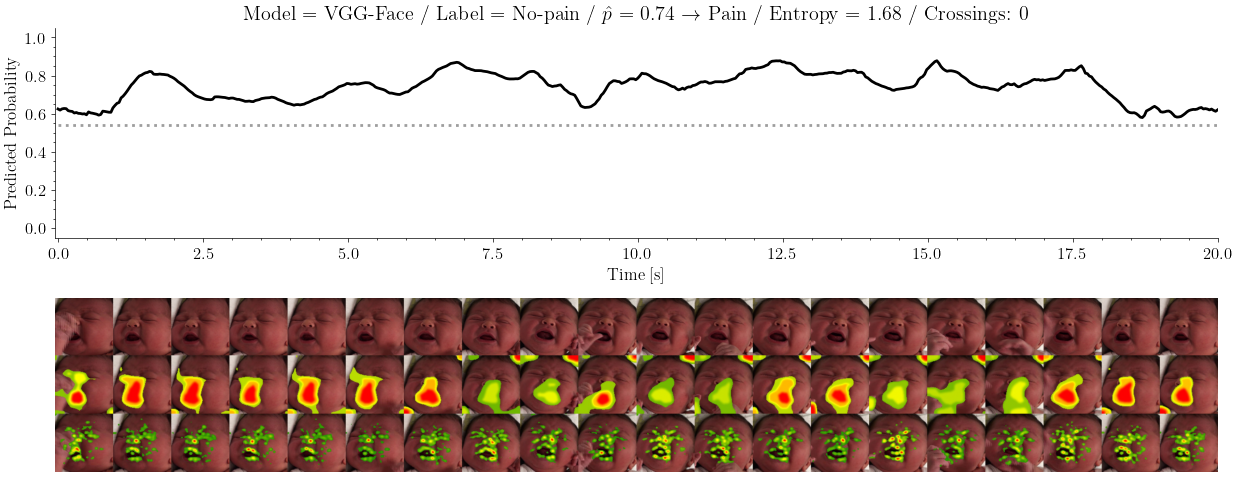

In [8]:
labels = []
preds = []
probs = []

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

model = "NCNN_test"

size_z = 256

if "NCNN" in model:
    #theta_1 = 0.4305
    theta_1 = 0.5420
    theta_3 = 0.1852
    lower_tresh = 0.1
    upper_tresh = 0.7
else:
    #theta_1 = 0.4690
    theta_1 = 0.4944
    theta_3 = 0.0309
    lower_tresh = 0.1
    upper_tresh = 0.8

with open(os.path.join(path_icopevid_frames,f'results_{model}.pkl'), 'rb') as f:
    results_video = pickle.load(f)

for video in results_video.keys():

    full_frames_path = os.path.join(path_icopevid_frames,video)
    img_files = os.listdir(full_frames_path)
    frame_seq = []

    gc_frame_seq = []
    gc_alpha_seq = []

    ig_frame_seq = []
    ig_alpha_seq= []

    for i in range(0, len(img_files), 30): #50
        if img_files[i].endswith('.jpg'):
            img = cv2.imread(os.path.join(full_frames_path, img_files[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (size_z,size_z))
            frame_seq.append(img/255)

            try:
                mask_gc = cv2.imread(os.path.join(full_frames_path,f"GC_{model}", img_files[i]))
                mask_gc = cv2.cvtColor(mask_gc, cv2.COLOR_BGR2RGB)
                mask_gc = cv2.resize(mask_gc, (size_z,size_z))
            except:
                mask_gc = np.zeros((size_z,size_z,3))

            try:    
                mask_ig = cv2.imread(os.path.join(full_frames_path,f"IG_{model}", img_files[i]))
                mask_ig = cv2.cvtColor(mask_ig, cv2.COLOR_BGR2RGB)
                mask_ig = cv2.resize(mask_ig, (size_z,size_z))
            except:
                mask_ig = np.zeros((size_z,size_z,3))

            
            gc_frame_seq.append(mask_gc/255)
            ig_frame_seq.append(mask_ig/255)
   

    frame_seq = np.hstack(frame_seq)

    gc_seq = np.hstack(gc_frame_seq)
    ig_seq = np.hstack(ig_frame_seq)

    frame_seq = np.vstack((frame_seq, gc_seq, ig_seq))

    if "Pain" in video:
        labels.append(1)
    else:
        labels.append(0)

    stacked_probs = []
    for fold in list(results_video[video].keys()):
        # fiz isso para pegar paenas o melhor modelo
        if "NCNN" in model and fold == "9":
            stacked_probs.append(interp_curve(results_video[video][fold]))
        elif "VGGNB" in model and fold == "7":
            stacked_probs.append(interp_curve(results_video[video][fold]))

    stacked_probs = np.array(stacked_probs)

    mean_probs = stacked_probs.mean(axis=0)
    #std_probs = stacked_probs.std(axis=0)

    preds.append((mean_probs.mean() >= theta_1).astype('int'))
    
    ma_window = 30
    ma_probs = moving_average(mean_probs, ma_window)
    #std_ma_probs = moving_average(std_probs, ma_window)

    #ma_probs = butter_lowpass_filter(mean_probs)
    #std_ma_probs = butter_lowpass_filter(std_probs)

    probs.append(ma_probs.mean())

    time = np.linspace(0,20,len(ma_probs))

    idx = np.where(np.diff(np.sign(ma_probs-theta_1)))[0]
   
    plt.figure(figsize=(15,6))

    plt.subplot(2,1,1)
    plt.plot(time, ma_probs, color="#000000")
   
    #plt.fill_between(x=time, y1=ma_probs+std_ma_probs, y2=ma_probs-std_ma_probs, alpha=0.2, color="#000000", edgecolor="none")

    plt.ylim([-0.05,1.05])
    plt.xlim([-0.05,20])

    label = "Pain" if "Pain" in video else "No-pain"

    temp_1 = "Pain" if ma_probs.mean() >= theta_1 else "No-pain"

    plt.title(f"Model = VGG-Face / Label = {label} / $\\hat{{p}}$ = {str(round(ma_probs.mean(),2))} $\\rightarrow$ {temp_1} / Entropy = {str(round(get_entropy(ma_probs),2))} / Crossings: {thresh_crossing(ma_probs, theta_1)}") #, fontsize=20
    plt.ylabel("Predicted Probability")
    plt.xlabel("Time [s]")


    plt.plot(time[idx],[theta_1]*len(idx), 'ro')

    plt.hlines(y=theta_1, xmin=0, xmax=20, linestyle=":", color='#9e9e9e')
    
    #plt.fill_between(x=time, y1=1.0, y2=0.75, alpha=0.3, color='#eb4034', edgecolor="none")
    #plt.fill_between(x=time, y1=0.75, y2=0.35, alpha=0.3, color='#ecf542', edgecolor="none")
    #plt.fill_between(x=time, y1=0.35, y2=0.0, alpha=0.3, color='#51f542', edgecolor="none")

    #plt.text(5, 0.8, f"Average: {ma_probs.mean():.4f} ± {ma_probs.std():.2f}\n"+
                     #f"Entropy: {get_entropy(ma_probs):.4f}\n"+
                     #f"Variance: {ma_probs.var():.4f}\n"+
                     #f"Peak to Peak: {peak_to_peak(ma_probs):.4f}\n"+
                     #f"RMS: {RMS(ma_probs):.4f}\n"+
                    # f"0.5 crossing/s: {thresh_crossing(ma_probs, 0.5)/(len(ma_probs) / 29.97):.4f}\n"+
                    # f"0.5 crossing: {thresh_crossing(ma_probs, 0.5)}")

    #plt.legend(loc='upper right')

    #plt.subplot(5,1,2)
    #entropies = get_entropy_curve(ma_probs)
    #plt.plot(entropies, label=f'Entropy: {get_entropy(ma_probs):.4f}', color="#000000")
    #plt.legend(loc='upper right')
    #plt.xlim([-0.05,600])
    #plt.ylim([-0.05,1.05])

    #plt.subplot(6,1,3)
    #auc_curve = get_auc_curve(ma_probs)
    #plt.plot(auc_curve, label=f'AUC: {get_auc(ma_probs):.4f}', color="#000000")
    #plt.legend(loc='upper right')
    #plt.xlim([-0.05,600])
    #plt.ylim([-0.05,1.05])

    plt.subplot(2,1,2)
    plt.imshow(frame_seq)
    plt.axis('off')

    #plt.subplot(3,1,2)
    #plt.imshow(frame_seq)
    #plt.imshow(gc_seq, cmap=cmap, alpha=gc_alpha_seq)
    #plt.axis('off')

    #plt.subplot(3,1,3)
    #plt.imshow(frame_seq)
    #plt.imshow(ig_seq, cmap=cmap, alpha=ig_alpha_seq)
    #plt.axis('off')

    #plt.show()
    plt.savefig(os.path.join("C:\\Users\\leonardo\\Desktop\\icopevid_results", f'{video}_{model}.pdf'), dpi=300, bbox_inches='tight')
    plt.close()


print(validation_metrics(np.array(preds), np.array(probs), np.array(labels)))

MCDP

In [ ]:
labels = []
preds = []

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

model = "NCNN"
calibrator = "_LS_01"

if "NCNN" in model:
    #theta_1 = 0.4305
    theta_1 = 0.5
    theta_3 = 0.1852
    lower_tresh = 0.1
    upper_tresh = 0.7
else:
    #theta_1 = 0.4690
    theta_1 = 0.5
    theta_3 = 0.0309
    lower_tresh = 0.1
    upper_tresh = 0.8

with open(os.path.join(path_icopevid_frames,f'results_{model}{calibrator}_MCDP.pkl'), 'rb') as f:
    results_video = pickle.load(f)

for video in results_video.keys():

    with open(os.path.join(path_icopevid_frames,video,f'audio_signal.pkl'), 'rb') as f:
        audio_signal = pickle.load(f)

    audio_signal = audio_signal.mean(axis=1)

    full_frames_path = os.path.join(path_icopevid_frames,video)
    img_files = os.listdir(full_frames_path)
    frame_seq = []

    gc_frame_seq = []
    gc_alpha_seq = []

    ig_frame_seq = []
    ig_alpha_seq= []

    for i in range(0, len(img_files), 25):
        if img_files[i].endswith('.jpg'):
            img = cv2.imread(os.path.join(full_frames_path, img_files[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64,64))
            frame_seq.append(img/255)

            try:
                mask_gc = cv2.imread(os.path.join(full_frames_path,f"GC_{model}", img_files[i]))
                mask_gc = cv2.cvtColor(mask_gc, cv2.COLOR_BGR2RGB)
                mask_gc = cv2.resize(mask_gc, (64,64))
            except:
                mask_gc = np.zeros((64,64,3))

            try:    
                mask_ig = cv2.imread(os.path.join(full_frames_path,f"IG_{model}", img_files[i]))
                mask_ig = cv2.cvtColor(mask_ig, cv2.COLOR_BGR2RGB)
                mask_ig = cv2.resize(mask_ig, (64,64))
            except:
                mask_ig = np.zeros((64,64,3))

            
            gc_frame_seq.append(mask_gc/255)
            ig_frame_seq.append(mask_ig/255)
   

    frame_seq = np.hstack(frame_seq)

    gc_seq = np.hstack(gc_frame_seq)
    ig_seq = np.hstack(ig_frame_seq)

    frame_seq = np.vstack((frame_seq, gc_seq, ig_seq))

    if "Pain" in video:
        labels.append(1)
    else:
        labels.append(0)

    mean_probs = []
    std_probs = []
    for fold in list(results_video[video].keys()):
        for array in results_video[video][fold]:
            array = np.asarray(array)
            if not np.isnan(array).any():
                mean_probs.append(array.mean())
                std_probs.append(array.std())
            else:
                mean_probs.append(np.nan)
                std_probs.append(np.nan)

    mean_probs = interp_curve(np.asarray(mean_probs))
    std_probs = interp_curve(np.asarray(std_probs))
    
    ma_window = 30
    ma_probs = moving_average(mean_probs, ma_window)
    std_ma_probs = moving_average(std_probs, ma_window)

    preds.append((ma_probs.mean() >= theta_1).astype('int'))

    time = np.linspace(0,20,len(ma_probs))
    time_audio = np.linspace(0,20,len(audio_signal))

    #idx_precision = (ma_probs <= 0.1) & (ma_probs >= 0.8)
    #idx_precision = std_ma_probs <= theta_3

    #ma_probs_precision = ma_probs[idx_precision]
    #std_ma_precision = std_ma_probs[idx_precision]
    #time_precision = time[idx_precision]

    #ma_probs_imprecision = ma_probs[~idx_precision]
    #std_ma_imprecision = std_ma_probs[~idx_precision]
    #time_imprecision = time[~idx_precision]

    ma_probs_precision = np.ma.masked_where(std_ma_probs > theta_3, ma_probs) # é ao contratrio essa função
    ma_probs_imprecision = np.ma.masked_where(std_ma_probs <= theta_3, ma_probs)

    std_ma_precision = np.ma.masked_where(std_ma_probs > theta_3, std_ma_probs) # é ao contratrio essa função
    std_ma_imprecision = np.ma.masked_where(std_ma_probs <= theta_3, std_ma_probs)

    idx = np.where(np.diff(np.sign(ma_probs-theta_1)))[0]
   
    plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)

    plt.plot(time, ma_probs, 'k')
    #plt.plot(time, ma_probs_precision, 'k', time, ma_probs_imprecision, 'r')
    #plt.plot(time_audio, (audio_signal*0.8)+0.5, 'b', alpha=0.2)
    #plt.fill_between(x=time, y1=ma_probs_precision+std_ma_precision, y2=ma_probs_precision-std_ma_precision, alpha=0.2, color="#000000", edgecolor="none")
    #plt.fill_between(x=time, y1=ma_probs_imprecision+std_ma_imprecision, y2=ma_probs_imprecision-std_ma_imprecision, alpha=0.2, color="red", edgecolor="none")

    plt.ylim([-0.05,1.05])
    plt.xlim([-0.05,20])

    label = "Com dor" if "Pain" in video else "Sem dor"

    temp_1 = "Com dor" if ma_probs.mean() >= theta_1 else "Sem dor"

    temp_3 = "Certo" if std_ma_probs.mean() <= theta_3 else "Incerto"

    #plt.title(f"Classe real = {label} / $\\hat{{p}}$ = {ma_probs.mean():.4f} $\\rightarrow$ {temp_1} / $\\hat{{\\sigma}}$ = {std_ma_probs.mean():.4f} $\\rightarrow$ {temp_3} / $H$ = {get_entropy(ma_probs):.4f} / Pontos de Inflexão =  {thresh_crossing(ma_probs, theta_1)}", fontsize=20)
    plt.title(f"Classe real = {label} / $\\hat{{p}}$ = {ma_probs.mean():.4f} $\\rightarrow$ {temp_1}", fontsize=20)
    plt.ylabel("Probabilidade Prevista")
    plt.xlabel("Tempo [s]")

    plt.plot(time[idx],[theta_1]*len(idx), 'ro')

    plt.hlines(y=theta_1, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
    #plt.text(20.1, theta_1, "$\\theta_{{1}}$", fontsize=20)

    #plt.hlines(y=lower_tresh, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
    #plt.text(20.1, lower_tresh, "$\\theta_{{2}}$", fontsize=20)

    #plt.hlines(y=upper_tresh, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
    #plt.text(20.1, upper_tresh, "$\\theta_{{2}}$", fontsize=20)
    
    #plt.fill_between(x=time, y1=1.0, y2=0.75, alpha=0.3, color='#eb4034', edgecolor="none")
    #plt.fill_between(x=time, y1=0.75, y2=0.35, alpha=0.3, color='#ecf542', edgecolor="none")
    #plt.fill_between(x=time, y1=0.35, y2=0.0, alpha=0.3, color='#51f542', edgecolor="none")

    #plt.text(0.5, 0.8, f"$\\hat{{p}}$ = {ma_probs.mean():.4f}\n"+
                       #f"$\\hat{{\\sigma}}$ = {std_ma_probs.mean():.4f}\n"+
                       #f"$H$ = {get_entropy(ma_probs):.4f}\n"+
                       #f"Pontos de Inflexão =  {thresh_crossing(ma_probs, theta_1)}")

    #plt.legend(loc='upper right')

    #plt.subplot(5,1,2)
    #entropies = get_entropy_curve(ma_probs)
    #plt.plot(entropies, label=f'Entropy: {get_entropy(ma_probs):.4f}', color="#000000")
    #plt.legend(loc='upper right')
    #plt.xlim([-0.05,600])
    #plt.ylim([-0.05,1.05])

    #plt.subplot(6,1,3)
    #auc_curve = get_auc_curve(ma_probs)
    #plt.plot(auc_curve, label=f'AUC: {get_auc(ma_probs):.4f}', color="#000000")
    #plt.legend(loc='upper right')
    #plt.xlim([-0.05,600])
    #plt.ylim([-0.05,1.05])

    plt.subplot(2,1,2)
    plt.imshow(frame_seq)
    plt.axis('off')

    #plt.subplot(3,1,3)
    #plt.specgram(audio_signal, Fs=48000, NFFT=512, cmap='jet')

    #plt.subplot(4,1,3)
    #plt.imshow(frame_seq)
    #plt.imshow(gc_seq, cmap=cmap, alpha=gc_alpha_seq)
    #plt.axis('off')

    #plt.subplot(4,1,4)
    #plt.imshow(frame_seq)
    #plt.imshow(ig_seq, cmap=cmap, alpha=ig_alpha_seq)
    #plt.axis('off')

    #plt.show()
    plt.savefig(os.path.join("C:\\Users\\leonardo\\Desktop\\icopevid results", f'{video}_{model}{calibrator}_MCDP.png'), dpi=100, bbox_inches='tight')
    plt.close()


print(validation_metrics(np.array(preds), np.array(labels)))

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 2
fs = 29.97       # sample rate, Hz
cutoff = 2  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

## DATAFRAME

In [9]:
labels = []
preds = []

model = "VGGNB_test"

if "NCNN" in model:
    #theta_1 = 0.4305
    theta_1 = 0.5420
    theta_3 = 0.1852
    lower_tresh = 0.1
    upper_tresh = 0.7
else:
    #theta_1 = 0.4690
    theta_1 = 0.4944
    theta_3 = 0.0309
    lower_tresh = 0.1
    upper_tresh = 0.8

video_name = []
mean_curve = []
std_curve = []
average_probs = []
average_stds = []
entropies = []
variances = []
peaktopeaks = []
rmss = []
thresh_changes = []
folds = []

with open(os.path.join(path_icopevid_frames,f'results_{model}.pkl'), 'rb') as f:
    results_video = pickle.load(f)

for video in results_video.keys():

    if "Pain" in video:
        labels.append(1)
    else:
        labels.append(0)

    """
    mean_probs = []
    std_probs = []
    for fold in list(results_video[video].keys()):
        for array in results_video[video][fold]:
            array = np.asarray(array)
            if not np.isnan(array).any():
                mean_probs.append(array.mean())
                std_probs.append(array.std())
            else:
                mean_probs.append(np.nan)
                std_probs.append(np.nan)

    mean_probs = interp_curve(np.asarray(mean_probs))
    std_probs = interp_curve(np.asarray(std_probs))
    """

    stacked_probs = []
    for fold in list(results_video[video].keys()):
        stacked_probs.append(interp_curve(results_video[video][fold]))

    stacked_probs = np.array(stacked_probs)

    mean_probs = stacked_probs.mean(axis=0)
    std_probs = stacked_probs.std(axis=0)

    ma_window = 10
    ma_probs = moving_average(mean_probs, ma_window)
    std_ma_probs = moving_average(std_probs, ma_window)

    preds.append((ma_probs.mean() >= theta_1).astype('int'))

    average_prob = ma_probs.mean()
    average_std = std_ma_probs.mean()
    entropyy = get_entropy(ma_probs)
    variance = ma_probs.var()
    peaktopeak = peak_to_peak(ma_probs)
    rms = RMS(ma_probs)
    thresh_change = thresh_crossing(ma_probs, theta_1)

    video_name.append(video)
    mean_curve.append(ma_probs)
    std_curve.append(std_ma_probs)
    average_probs.append(average_prob)
    average_stds.append(average_std)
    entropies.append(entropyy)
    variances.append(variance)
    peaktopeaks.append(peaktopeak)
    rmss.append(rms)
    thresh_changes.append(thresh_change)


dataframe = pd.DataFrame({'video_name':video_name, 'label':labels, 'pred': preds, 'mean_curve':mean_curve,
                          'std_curve':std_curve, 'average_prob':average_probs, 'average_std':average_stds, 'entropy':entropies,
                          'variance':variances, 'peak_to_peak':peaktopeaks, 'rms':rmss,
                          'thresh_change':thresh_changes})




In [ ]:
dataframe.head()

In [26]:
# Define window size and overlap
window_size = 50
overlap = 20

names = []
signal_windows = []

for curve in dataframe['mean_curve'].values:
    # Calculate the number of windows
    num_windows = int(np.ceil((len(curve) - window_size) / overlap)) + 1

    # Create overlapping windows
    windows = [curve[i * overlap:i * overlap + window_size] for i in range(num_windows)]

    for w in windows:
        if len(w) == window_size:
            signal_windows.append(w)
    #names.extend([])



In [27]:
from sklearn.cluster import KMeans

In [28]:
signal_windows = np.asarray(signal_windows).reshape(-1,window_size)

In [29]:
signal_windows = []
for curve in dataframe['mean_curve'].values:
    signal_windows.append(curve)

signal_windows = np.asarray(signal_windows)

In [ ]:
inertia =[] 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(signal_windows)
    inertia.append(kmeans.inertia_)

In [ ]:
ax = plt.plot(range(1,10),inertia)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(signal_windows)

In [ ]:
k_0 = signal_windows[kmeans.labels_ == 0]
mean_0 = np.median(k_0,axis=0)

for k in k_0:
    plt.plot(k, 'k', alpha=0.2)

plt.plot(mean_0, 'b')
plt.show()

### Estatisticas do dataframe

In [ ]:
np.abs(dataframe[dataframe['label']==1].describe() - dataframe[dataframe['label']==0].describe())

Não há diferenças significativas nas métricas de sinais COM DOR e SEM DOR

In [ ]:
ps = []
for x in dataframe[dataframe['label']==1]['mean_curve'].values:
    p = ((x >= theta_1).sum() / len(x)) 
    ps.append(p)

print(f" Nos clipes de 'DOR' houve uma porcentagem média de {np.array(ps).mean()*100:.2f}% ± {np.array(ps).std()*100:.2f}% de predições dolorosas, equivalente a {np.array(ps).mean()*20:.1f}s ± {np.array(ps).std()*20:.1f}s do clipe")

In [ ]:
ps = []
for x in dataframe[dataframe['label']==0]['mean_curve'].values:
    p = ((x >= theta_1).sum() / len(x)) 
    ps.append(p)

print(f" Nos clipes de 'SEM DOR' houve uma porcentagem média de {np.array(ps).mean()*100:.2f}% ± {np.array(ps).std()*100:.2f}% de predições dolorosas, equivalente a {np.array(ps).mean()*20:.1f}s ± {np.array(ps).std()*20:.1f}s do clipe")

In [ ]:
length = []
total_pain = []

for signal in dataframe[dataframe['label']==0]['mean_curve'].values:
    if_points = np.where(np.diff(np.sign(signal-theta_1)))[0]
    o = 0
    if len(if_points) > 0:
        for i in range(len(if_points)-1):
            if signal[if_points[i]-1] < theta_1:
                signal_pain = signal[if_points[i]:if_points[i+1]]
                length.append(len(signal_pain))
                o = o + 1
        total_pain.append(o)
    
    else:
        if signal[0] >= theta_1:
            length.append(len(signal))
            total_pain.append(1)

print(f"Nos clipes de 'SEM DOR' os eventos previsto como 'COM DOR' duram em média {(np.array(length).mean() / 571)*20:.1f}s ± {(np.array(length).std() / 571)*20:.1f}s e ocorrem pelo menos {np.median(np.array(total_pain))} vez(es)")


In [ ]:
length = []
total_pain = []

for signal in dataframe[dataframe['label']==1]['mean_curve'].values:
    if_points = np.where(np.diff(np.sign(signal-theta_1)))[0]
    o = 0
    if len(if_points) > 0:
        for i in range(len(if_points)-1):
            if signal[if_points[i]-1] < theta_1:
                signal_pain = signal[if_points[i]:if_points[i+1]]
                length.append(len(signal_pain))
                o = o + 1
        total_pain.append(o)
    
    else:
        if signal[0] >= theta_1:
            length.append(len(signal))
            total_pain.append(1)

print(f"Nos clipes de 'COM DOR' os eventos previsto como 'COM DOR' duram em média {(np.array(length).mean() / 571)*20:.1f}s ± {(np.array(length).std() / 571)*20:.1f}s e ocorrem pelo menos {np.median(np.array(total_pain))} vez(es)")

### Aplicando os limites

Os dados do sinal fora dos limites foram desconsiderados

In [ ]:
if "NCNN" in model:
    theta_1 = 0.4305
    theta_3 = 0.1852
    lower_tresh = 0.1
    upper_tresh = 0.7
else:
    theta_1 = 0.4690
    theta_3 = 0.0309
    lower_tresh = 0.1
    upper_tresh = 0.8

new_preds = []
removed = []

for probs, stds in dataframe[['mean_curve', 'std_curve']].values:
        
    certain = probs[stds <= theta_3]

    precise = certain[(certain >= upper_tresh) | (certain <= lower_tresh)]

    pred = 1 if precise.mean() >= theta_1 else 0
    
    new_preds.append(pred)
    removed.append(1 - (len(precise)/len(probs)))

In [34]:
dataframe['new_preds'] = new_preds
dataframe['removed'] = removed

In [ ]:
dataframe['removed'].mean()

In [ ]:
print(validation_metrics(dataframe['pred'], dataframe['label']))

In [ ]:
print(calibration_metrics(dataframe['average_prob'], dataframe['label']))

In [ ]:
print(validation_metrics(dataframe['new_preds'], dataframe['label']))

### Agrupamento dos sinais

In [11]:
from sklearn.cluster import KMeans

In [12]:
X = dataframe[['average_prob','average_std','entropy','thresh_change', ]]

In [ ]:
X.shape

In [ ]:
X

In [59]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")

In [ ]:
kmeans.fit(X)

In [61]:
dataframe['kmeans'] = kmeans.labels_

In [36]:
for videoname, kmeans_label in zip(dataframe['video_name'], dataframe['kmeans']):
    for filename in os.listdir('C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\'):
        if videoname in filename:
            os.rename(os.path.join('C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\',filename),os.path.join(f'C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\{kmeans_label}',filename))
            break

Sinal estável em qualquer valor de probabilidade, baixa entropia, variancia e sem troca de classes.

In [ ]:
dataframe[dataframe['kmeans']==0].describe()

In [ ]:
print(validation_metrics(dataframe[dataframe['kmeans']==0]['pred'], dataframe[dataframe['kmeans']==0]['average_prob'], dataframe[dataframe['kmeans']==0]['label']))

In [ ]:
print(calibration_metrics(dataframe[dataframe['kmeans']==0]['average_prob'], dataframe[dataframe['kmeans']==0]['label']))

Sinal instável, com alta entropia porém com pouca troca de classes

In [ ]:
dataframe[dataframe['kmeans']==1].describe()

In [ ]:
print(validation_metrics(dataframe[dataframe['kmeans']==1]['pred'], dataframe[dataframe['kmeans']==1]['average_prob'], dataframe[dataframe['kmeans']==1]['label']))

In [ ]:
print(calibration_metrics(dataframe[dataframe['kmeans']==1]['average_prob'], dataframe[dataframe['kmeans']==1]['label']))

Sinal instável, alta entropia e alta troca de classes

In [ ]:
dataframe[dataframe['kmeans']==2].describe()

In [ ]:
print(validation_metrics(dataframe[dataframe['kmeans']==2]['pred'], dataframe[dataframe['kmeans']==2]['average_prob'], dataframe[dataframe['kmeans']==2]['label']))

In [ ]:
print(calibration_metrics(dataframe[dataframe['kmeans']==2]['average_prob'], dataframe[dataframe['kmeans']==2]['label']))

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=6):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff=2, fs=29.97, order=6):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 29.97       # sample rate, Hz
cutoff = 2  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

## GIF

In [6]:
import os
import imageio
import cv2
import re 
import pickle
from XAI import attribution_mask_processing
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg
from utils.plots import *
import imageio




In [ ]:
#S002_Rest_2_[0]_20s_NCNN_test
#S004_Rest_1_[1]_20s_NCNN_test
#S015_Rest_1_[0]_20s_NCNN_test

#S018_Rest_1_[0]_20s_NCNN_test
#S007_Rest_1_[1]_20s_NCNN_test

#S002_Rest_2_[0]_20s_VGGNB_test
#S009_Pain_1_[0]_20s_VGGNB_test
#S015_Rest_1_[1]_20s_VGGNB_test

In [10]:
model = "NCNN_test"
folder = 'S007_Rest_1_[1]_20s'
images_dir = os.path.join('Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames', folder)
output_gif = os.path.join('C:\\Users\\leonardo\\Desktop\\icopevid results_paper', f'{folder}_{model}.mp4')

In [ ]:
if "NCNN" in model:
    #theta_1 = 0.4305
    theta_1 = 0.5420
    theta_3 = 0.1852
    lower_tresh = 0.1
    upper_tresh = 0.7
else:
    #theta_1 = 0.4690
    theta_1 = 0.4944
    theta_3 = 0.0309
    lower_tresh = 0.1
    upper_tresh = 0.8

images = []
plots = []

size = 512

path_icopevid_frames = 'Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames'

with open(os.path.join(path_icopevid_frames,f'results_{model}.pkl'), 'rb') as f:
    results_video = pickle.load(f)

video = images_dir.split("\\")[-1]
results = results_video[video]

"""
mean_probs = []
std_probs = []
for fold in list(results_video[video].keys()):
    for array in results_video[video][fold]:
        array = np.asarray(array)
        if not np.isnan(array).any():
            mean_probs.append(array.mean())
            std_probs.append(array.std())
        else:
            mean_probs.append(np.nan)
            std_probs.append(np.nan)

mean_probs = interp_curve(np.asarray(mean_probs))
std_probs = interp_curve(np.asarray(std_probs))
"""

stacked_probs = []
for fold in list(results_video[video].keys()):
    # fiz isso para pegar paenas o melhor modelo
    if "NCNN" in model and fold == "9":
        stacked_probs.append(interp_curve(results_video[video][fold]))
    elif "VGGNB" in model and fold == "7":
        stacked_probs.append(interp_curve(results_video[video][fold]))

stacked_probs = np.array(stacked_probs)
mean_probs = stacked_probs.mean(axis=0)
std_probs = stacked_probs.std(axis=0)

ma_probs = moving_average(mean_probs, 30)
std_ma_probs = moving_average(std_probs, 30)

time = np.linspace(0,20,len(ma_probs))
#idx = np.where(np.diff(np.sign(ma_probs-0.5)))[0]
k = 0
# Fetch all image files from the directory
for file_name in tqdm(os.listdir(images_dir)):
    if file_name.endswith('.png') or file_name.endswith('.jpg'):
        k += 1
        file_path = os.path.join(images_dir, file_name)
        img = cv2.cvtColor(cv2.resize(cv2.imread(file_path), (size,size)), cv2.COLOR_BGR2RGB)

        try:
            file_path_gc = os.path.join(images_dir, f"GC_{model}", file_name)
            mask_gc = cv2.cvtColor(cv2.resize(cv2.imread(file_path_gc), (size,size)), cv2.COLOR_BGR2RGB)
        except:
            mask_gc = np.zeros((size,size,3), dtype='uint8')

        try:
            file_path_ig = os.path.join(images_dir, f"IG_{model}", file_name)
            mask_ig = cv2.cvtColor(cv2.resize(cv2.imread(file_path_ig), (size,size)), cv2.COLOR_BGR2RGB)
        except:
            mask_ig = np.zeros((size,size,3), dtype='uint8')

        plt.figure(figsize=(20,6))

        #ma_probs_precision = np.ma.masked_where(std_ma_probs > theta_3, ma_probs) # é ao contratrio essa função
        #ma_probs_imprecision = np.ma.masked_where(std_ma_probs <= theta_3, ma_probs)

        #std_ma_precision = np.ma.masked_where(std_ma_probs > theta_3, std_ma_probs) # é ao contratrio essa função
        #std_ma_imprecision = np.ma.masked_where(std_ma_probs <= theta_3, std_ma_probs)

        idx = np.where(np.diff(np.sign(ma_probs-theta_1)))[0]

        plt.plot(time[:k], ma_probs[:k], 'k')
        #plt.fill_between(x=time[:k], y1=ma_probs[:k]+std_ma_probs[:k], y2=ma_probs[:k]-std_ma_probs[:k], alpha=0.2, color="#000000", edgecolor="none")

        #plt.plot(time[:k], ma_probs_precision[:k], 'k', time[:k], ma_probs_imprecision[:k], 'r')
        #plt.fill_between(x=time[:k], y1=ma_probs_precision[:k]+std_ma_precision[:k], y2=ma_probs_precision[:k]-std_ma_precision[:k], alpha=0.2, color="#000000", edgecolor="none")
        #plt.fill_between(x=time[:k], y1=ma_probs_imprecision[:k]+std_ma_imprecision[:k], y2=ma_probs_imprecision[:k]-std_ma_imprecision[:k], alpha=0.2, color="red", edgecolor="none")

        plt.ylim([-0.05,1.05])
        plt.xlim([-0.05,20])

        label = "Com dor" if "Pain" in video else "Sem dor"

        temp_1 = "Com dor" if ma_probs.mean() >= theta_1 else "Sem dor"

        #temp_3 = "Certo" if std_ma_probs.mean() <= theta_3 else "Incerto"

        #plt.title(f"Classe real = {label} / $\\hat{{p}}$ = {ma_probs.mean():.4f} $\\rightarrow$ {temp_1} / $\\hat{{\\sigma}}$ = {std_ma_probs.mean():.4f} $\\rightarrow$ {temp_3} / $H$ = {get_entropy(ma_probs):.4f} / Pontos de Inflexão =  {thresh_crossing(ma_probs, theta_1)}", fontsize=20)
        plt.title(f"Classe real = {label} / $\\hat{{p}}$ = {ma_probs[:k].mean():.2f} $\\rightarrow$ {temp_1} / Entropia = {get_entropy(ma_probs[:k]):.2f} / Transições = {thresh_crossing(ma_probs[:k], theta_1)}") #, fontsize=20
        plt.ylabel("Probabilidade Prevista")
        plt.xlabel("Tempo [s]")

        plt.plot(time[idx],[theta_1]*len(idx), 'ro')

        plt.hlines(y=theta_1, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')

        #plt.hlines(y=theta_1, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
        #plt.text(20.1, theta_1, "$\\theta_{{1}}$", fontsize=20)

        #plt.hlines(y=lower_tresh, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
        #plt.text(20.1, lower_tresh, "$\\theta_{{2}}$", fontsize=20)

        #plt.hlines(y=upper_tresh, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
        #plt.text(20.1, upper_tresh, "$\\theta_{{2}}$", fontsize=20)

        plt.tight_layout()

        """
        plt.plot(time[:k], ma_probs[:k], label=f"{model} {ma_probs[:k].mean():.4f} ± {ma_probs[:k].std():.2f}")
        plt.fill_between(x=time[:k], y1=ma_probs[:k]+std_ma_probs[:k], y2=ma_probs[:k]-std_ma_probs[:k], alpha=0.2)

        #plt.plot(time[:k][idx],[0.5]*len(idx), 'ro')
        plt.hlines(y=0.5, xmin=0,xmax=600, linestyle=":", color='#9e9e9e')

        plt.ylim([-0.05,1.05])
        plt.xlim([-0.05,600])

        plt.title(f"{video}")
        plt.ylabel("Probabilidade Prevista 'DOR'")
        plt.xlabel("Frames")
        plt.legend(loc='upper right')
        plt.tight_layout()
        """

        # Convert the Matplotlib plot to a NumPy array
        fig = plt.gcf()
        canvas = FigureCanvasAgg(fig)
        canvas.draw()
        plot_array = np.array(canvas.renderer.buffer_rgba(), dtype='uint8')
        plot_array = cv2.resize(plot_array[:, :, :3], (size * 3 , size))

        plt.close()
        plt.close(fig)

        images.append(np.vstack((plot_array, np.hstack((img, mask_gc, mask_ig)))))

#del images
#del plot_array

#gc.collect()


# Save images as a GIF
#video = cv2.VideoWriter(output_gif, 0, 27, (size * 3 , size * 2))
print("Creating video")
writer = imageio.get_writer(output_gif, fps=27)

for image in images:
    #video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    writer.append_data(image)

#cv2.destroyAllWindows()
#video.release()

writer.close()

In [ ]:
gc.collect()

# Imagens

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.plots import *

plt.style.use('utils\plotstyle.mplstyle')

# Curva de Calibração

### Falta de confiança

In [1]:
A = 18
B = -9

In [3]:
x = np.arange(0,1,0.01)
y = 1 / (1 + np.exp(-(A * x + B)))
x_points = np.arange(0,1,0.12)
y_points = 1 / (1 + np.exp(-(A * x_points + B)))

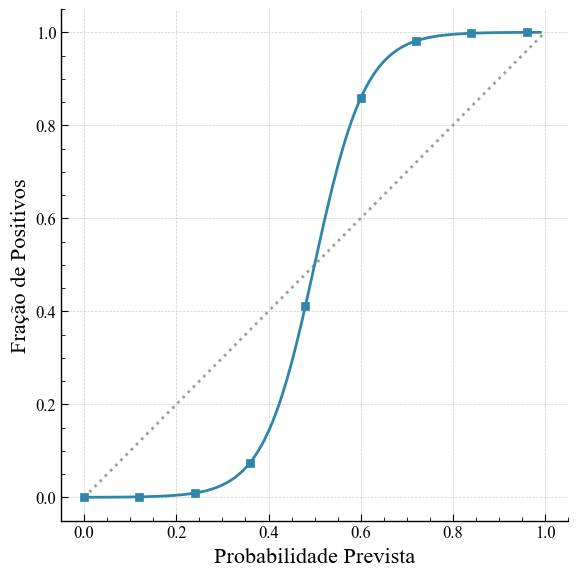

In [20]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle=":", color='#9e9e9e')
plt.plot(x,y)
plt.plot(x_points, y_points, 's', color='#2E86AB')

plt.xlabel('Probabilidade Prevista')
plt.ylabel('Fração de Positivos')
plt.savefig('undercofidence_example.pdf', dpi=300, bbox_inches='tight')


C:\Users\leonardo\AppData\Local\Temp\ipykernel_13908\3553570799.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('gradient_arrow_example.pdf', dpi=300, bbox_inches='tight')
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13908\3553570799.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('gradient_arrow_example.pdf', dpi=300, bbox_inches='tight')
C:\Users\leonardo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


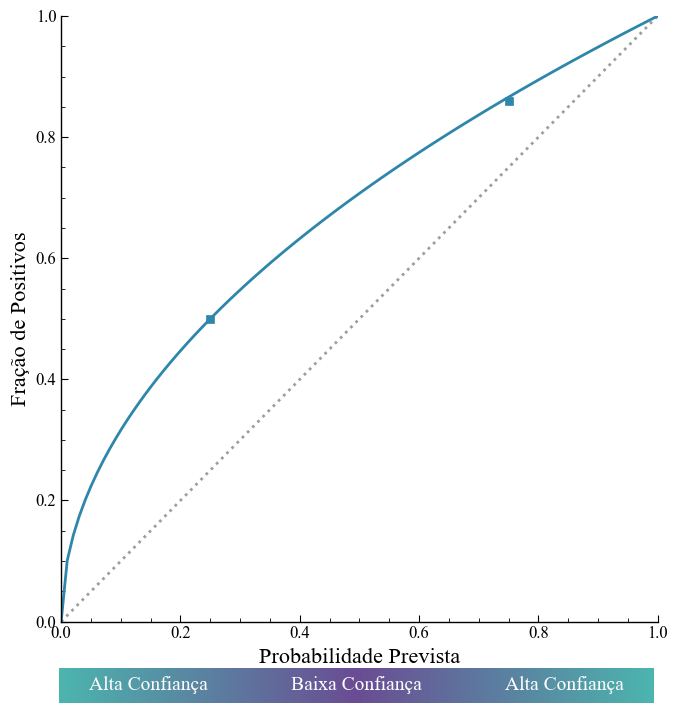

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch

# --- 1. Main Plot Setup ---
# Use subplots for better control over the figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

# Example data for a runnable example:
x = np.linspace(0, 1, 100)
y = np.sqrt(x)
x_points = [0.25, 0.75]
y_points = [0.5, 0.86]

# Plot your data
ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle=":", color='#9e9e9e')
ax.plot(x, y)
ax.plot(x_points, y_points, 's', color='#2E86AB')

# Set labels and limits for the main plot
ax.set_xlabel('Probabilidade Prevista')
ax.set_ylabel('Fração de Positivos')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Adjust main plot position to make space at the bottom
fig.subplots_adjust(bottom=0.25)


# --- 2. Gradient Arrow ---
# Create a new axes for the gradient arrow at the bottom of the figure
# The list is [left, bottom, width, height] in figure coordinates
ax_gradient = fig.add_axes([0.1, -0.02, 0.85, 0.05])

# Define a "V" shaped colormap: blue -> light gray -> blue
high_conf_color = '#4CB5AE'  # A strong blue for high confidence
low_conf_color = '#6A4C93'   # A light gray for low confidence
colors = [high_conf_color, low_conf_color, high_conf_color]
v_cmap = mcolors.LinearSegmentedColormap.from_list('custom_v_map', colors)

# Create the data for the gradient image
gradient_data = np.linspace(0, 1, 256)
gradient_data = np.vstack((gradient_data, gradient_data)) # Make it 2D for imshow

# Display the gradient on the new axes
ax_gradient.imshow(gradient_data, aspect='auto', cmap=v_cmap)


# Add text labels on top of the gradient bar
ax_gradient.text(0.5, 0.5, 'Baixa Confiança', color='white', ha='center', va='center', transform=ax_gradient.transAxes)
ax_gradient.text(0.15, 0.5, 'Alta Confiança', color='white', ha='center', va='center', transform=ax_gradient.transAxes)
ax_gradient.text(0.85, 0.5, 'Alta Confiança', color='white', ha='center', va='center', transform=ax_gradient.transAxes)

# Hide the ticks and spines of the gradient's axes
ax_gradient.set_axis_off()

# Save the figure
plt.savefig('gradient_arrow_example.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [5]:
x = np.arange(0,1,0.01)
y = -0.7856*np.power(x,2) + 1.7658*x + 0.0429

x_points = np.arange(0,1,0.12)
y_points = -0.7856*np.power(x_points,2) + 1.7658*x_points + 0.0429

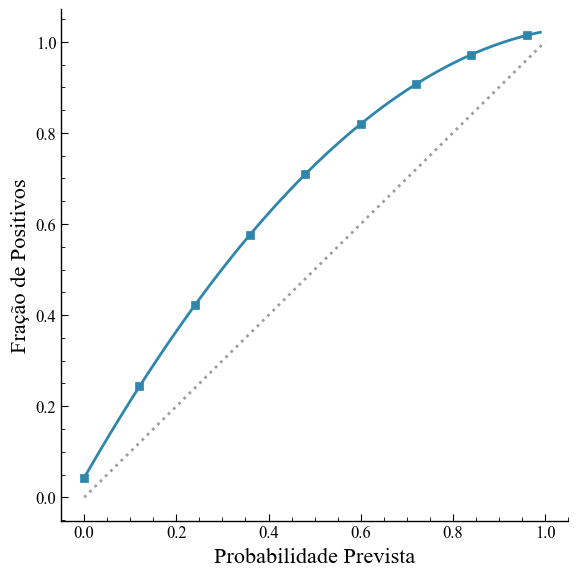

In [6]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle=":", color='#9E9E9E')
plt.plot(x_points, y_points, 's', color='#2E86AB')
plt.plot(x,y)

plt.xlabel('Probabilidade Prevista')
plt.ylabel('Fração de Positivos')
plt.savefig('undercofidence_example.pdf', dpi=300, bbox_inches='tight')

### Excesso de confiança

In [7]:
A = 0.4
B = 0.4
C = 0

In [8]:
from scipy.special import xlogy

In [22]:
x = np.arange(0,1,0.01)
y = 1 / (1 + np.exp(xlogy(-A, x) + xlogy(B, (1 - x)) - C))
x_points = np.arange(0,1,0.12)
y_points = 1 / (1 + np.exp(xlogy(-A, x_points) + xlogy(B, (1 - x_points)) - C))


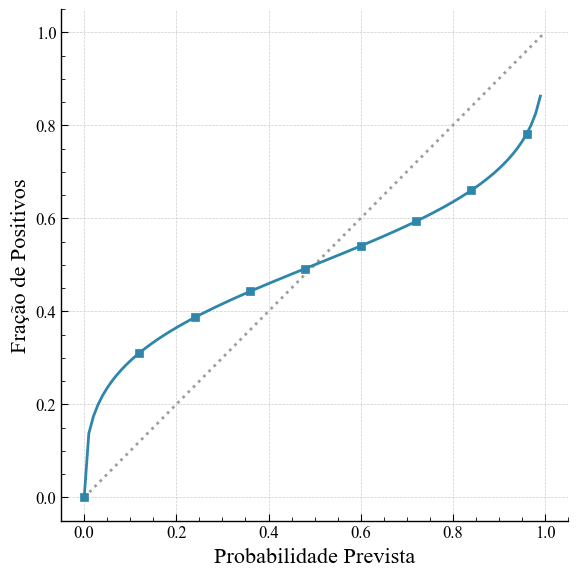

In [23]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle=":", color='#9e9e9e')
plt.plot(x,y)
plt.plot(x_points, y_points, 's', color='#2E86AB')

plt.xlabel('Probabilidade Prevista')
plt.ylabel('Fração de Positivos')
plt.savefig('overconfidence_example.pdf', dpi=300, bbox_inches='tight')


In [9]:
x = np.arange(0,1,0.01)
y = 0.7856*np.power(x,2) + 0.2342*x + 0.0019

x_points = np.arange(0,1,0.12)
y_points = 0.7856*np.power(x_points,2) + 0.2342*x_points + 0.0019

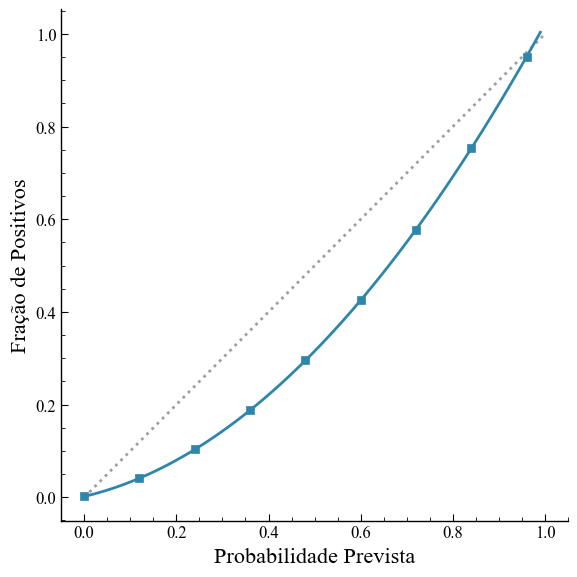

In [10]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle=":", color='#9e9e9e')
plt.plot(x_points, y_points, 's', color='#2E86AB')
plt.plot(x,y)

plt.xlabel('Probabilidade Prevista')
plt.ylabel('Fração de Positivos')
plt.savefig('overconfidence_example.pdf', dpi=300, bbox_inches='tight')

### Equal and same samples bins

In [11]:
x = np.random.rand(50)

In [12]:
n_bins = 10

In [13]:
bins = np.linspace(0.0, 1.0, n_bins + 1)
binids = np.searchsorted(bins[1:-1], x)

bin_total = np.bincount(binids, minlength=len(bins))

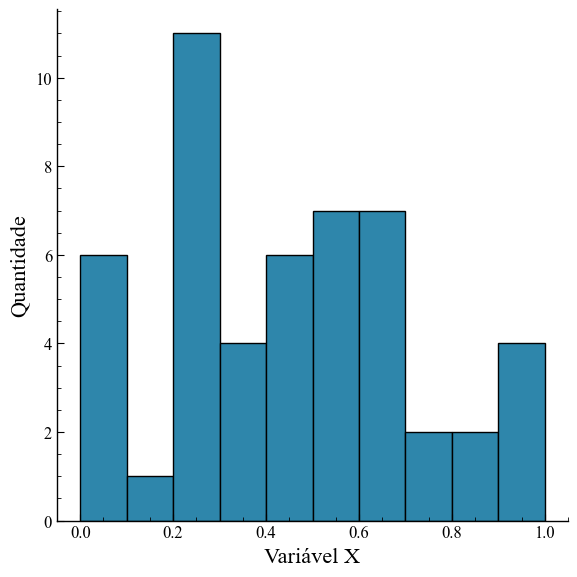

In [14]:
plt.figure(figsize=(6, 6))
plt.hist(x, bins=bins,edgecolor='k')
plt.xlabel('Variável X')
plt.ylabel('Quantidade')
plt.savefig('equal_width_bin_example.pdf', dpi=300, bbox_inches='tight')

In [15]:
quantiles = np.linspace(0, 1, n_bins + 1)
bins = np.percentile(x, quantiles * 100)

binids = np.searchsorted(bins[1:-1], x)
bin_total = np.bincount(binids, minlength=len(bins))

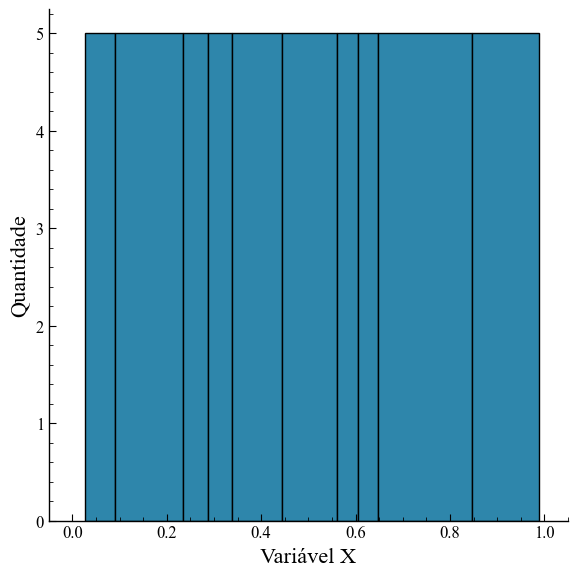

In [16]:
plt.figure(figsize=(6, 6))

plt.hist(x, bins=bins, edgecolor='k')
plt.xlabel('Variável X')
plt.ylabel('Quantidade')
plt.xlim([-0.05, 1.05])
plt.savefig('equal_samples_bin_example.pdf', dpi=300, bbox_inches='tight')

# Cross Entroyp Soft label

In [17]:
labels = [0.0,	0.3,	0.5,	0.7,  1.0]
probs = np.linspace(0.005,0.995, 100)

In [18]:
from calibration.metrics import negative_log_likelihood

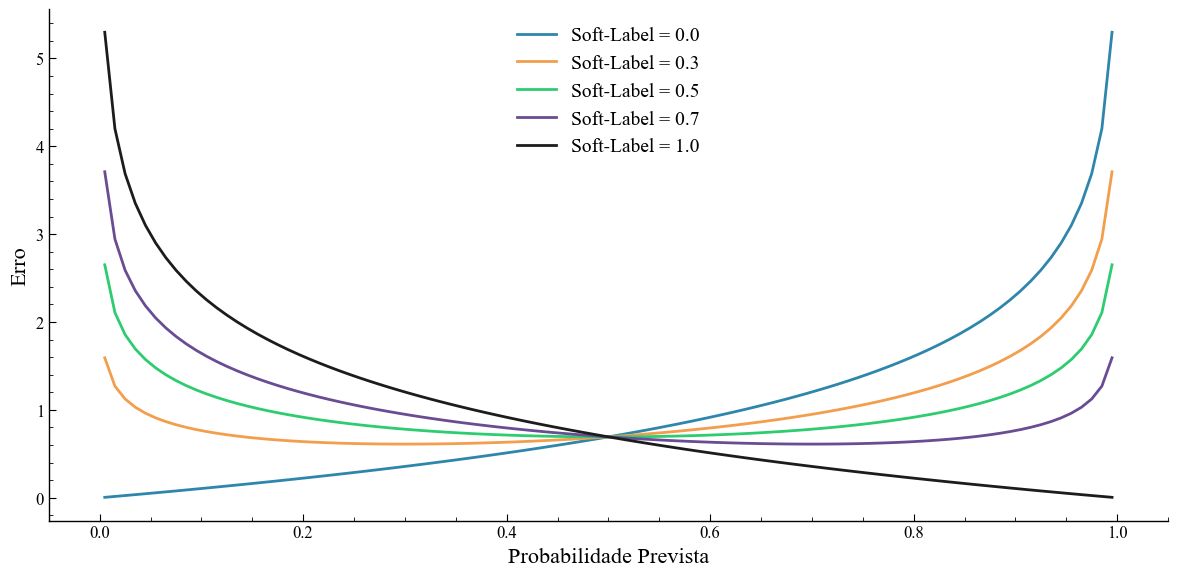

In [21]:
plt.figure(figsize=(12, 6))

for label in labels:
    nll = []
    for prob in probs:
        nll.append(negative_log_likelihood(prob, label))
    plt.plot(probs, nll, label=f"Soft-Label = {str(label)}")

plt.legend()
plt.xlabel("Probabilidade Prevista")
plt.ylabel("Erro")
plt.xlim([-0.05, 1.05])
plt.savefig('erro_soft_labels.pdf', dpi=300, bbox_inches='tight')


In [ ]:
nll

# NFCS as sfot label

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
NFCS = np.array([0, 1, 2, 3, 4, 5])

linear =  np.array([0.005 , 0.2, 0.4, 0.6, 0.8, 1. ])


step = np.array([0.005, 0.005, 0.3, 0.7, 1, 1])

sigmoid = 1 / (1 + np.exp(-NFCS+2.5))

hard = np.array([0.005, 0.005, 0.005, 1, 1, 1])

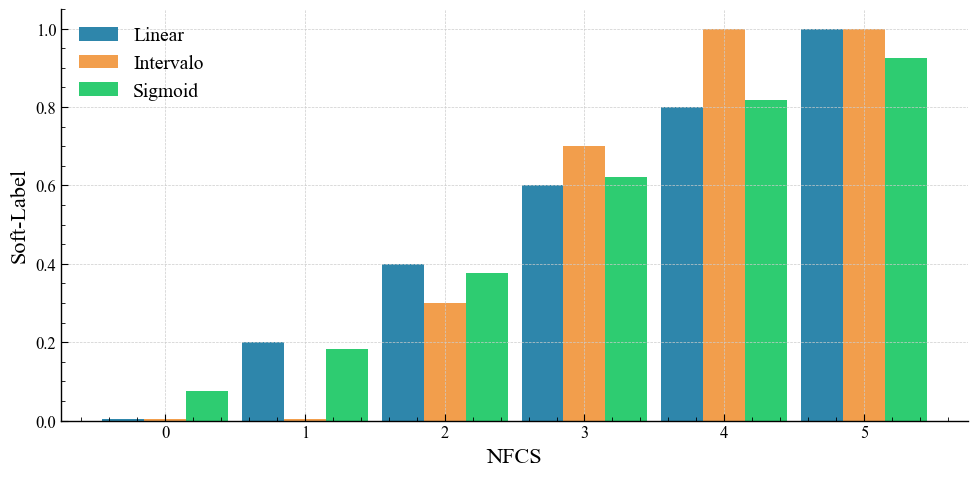

In [9]:
width = 0.3      
plt.figure(figsize=(10,5))

# Plotting
plt.bar(NFCS, linear , width, label='Linear')
plt.bar(NFCS + width, step, width, label='Intervalo')
plt.bar(NFCS + width * 2 , sigmoid, width, label='Sigmoid')
#plt.bar(NFCS + width * 3, hard, width, label='Hard-Label')

plt.xlabel('NFCS')
plt.ylabel('Soft-Label')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(NFCS + width*1, ('0', '1', '2', '3', '4', '5'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.savefig('soft_labels_example.png', dpi=300, bbox_inches='tight')

# MCDP Example

In [30]:
x = np.hstack((np.random.randint(0,300,40)/1000, np.random.randint(300,600,20)/1000, np.random.randint(600,1001,40)/1000))

In [31]:
x_mean = x.mean()
x_std = x.std()

In [32]:
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
binids = np.searchsorted(bins[1:-1], x)

bin_total = np.bincount(binids, minlength=len(bins))

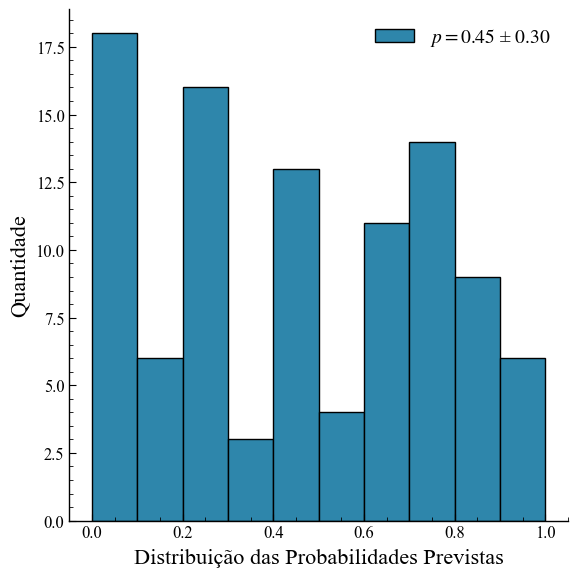

In [33]:
plt.figure(figsize=(6, 6))
plt.hist(x, bins=bins,edgecolor='k', label=f'$p = {x_mean:.2f}$ ± ${x_std:.2f}$')
plt.xlabel('Distribuição das Probabilidades Previstas')
plt.ylabel('Quantidade')
plt.legend()
plt.savefig('MCDP_uncertainty_example.png', dpi=300, bbox_inches='tight')

In [38]:
x = np.hstack((np.random.randint(400,600,80)/1000))

x_mean = x.mean()
x_std = x.std()

n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
binids = np.searchsorted(bins[1:-1], x)
bin_total = np.bincount(binids, minlength=len(bins))

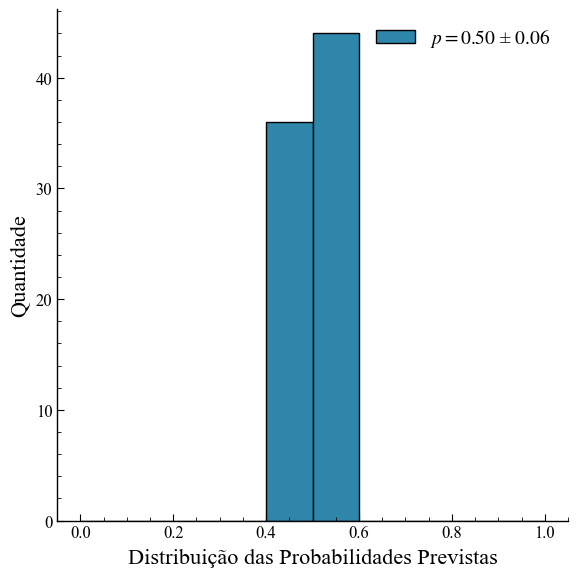

In [39]:
plt.figure(figsize=(6, 6))
plt.hist(x, bins=bins,edgecolor='k', label=f'$p = {x_mean:.2f}$ ± ${x_std:.2f}$')
plt.xlabel('Distribuição das Probabilidades Previstas')
plt.ylabel('Quantidade')
plt.legend()
plt.savefig('MCDP_certainty_example.png', dpi=300, bbox_inches='tight')

# Face detection example

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from XAI.metrics import *
import os

In [3]:
img_path = "Datasets\\NewDataset\\Images\\ID106_iCOPE_S10_nopain.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)


bbox = [597, 1025, 1368, 1884]
img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(255,0,0), thickness=15)

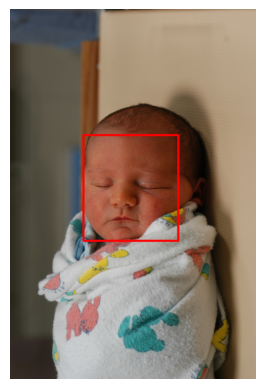

In [4]:
plt.imshow(img)
plt.axis('off')
plt.savefig('face_detected.png', dpi=300, bbox_inches='tight')

In [10]:
img_path = "Datasets\\Folds\\3\\Test\\ID106_iCOPE_S10_nopain.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

with open('Datasets\\DatasetFaces\\Landmarks\\ID106_iCOPE_S10_nopain.pkl', 'rb') as f:
    face_mesh = np.array(pickle.load(f))

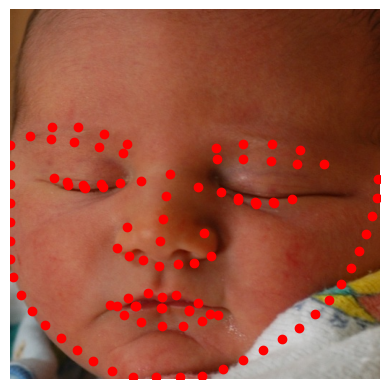

In [11]:
plt.imshow(img)
for x,y in face_mesh:
    plt.plot(x,y,'ro')

plt.axis('off')
plt.savefig('face_mesh.png', dpi=300, bbox_inches='tight')

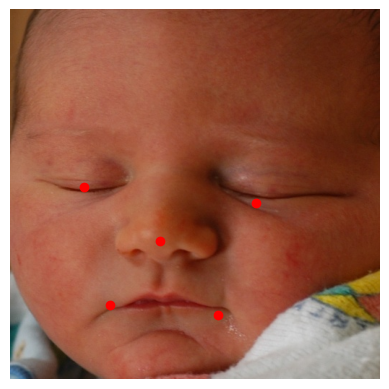

In [12]:
plt.imshow(img)
for x,y in face_mesh[[86,52,61,88,38]]:
    plt.plot(x,y,'ro')

plt.axis('off')
plt.savefig('face_landmarks.png', dpi=300, bbox_inches='tight')

# Corruption Examples


In [1]:
import cv2
import corruption
import matplotlib.pyplot as plt
import numpy as np
import pickle
from XAI.metrics import *

In [5]:
img_path = "Datasets\\Folds\\2\\Test\\ID644_iCOPE_S58_pain.jpg"
img = cv2.imread(img_path)
#img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

with open('Datasets\\landmarks\\ID644_iCOPE_S58_pain.pkl', 'rb') as f:
    face_mesh = np.array(pickle.load(f))

In [ ]:
plt.imshow(img)

In [9]:
corruptions = {"brightness": np.arange(0.1, 2.2, 0.2), "downscale": np.arange(0.05, 1, 0.1), 
               "blur": np.arange(1, 45, 4), "rotation": np.arange(-90,100,20),
               "translate_x": np.arange(-0.5, 0.6, 0.1), "translate_y": np.arange(-0.5, 0.6, 0.1),
               "face": ["eyebrown", "eye","nose", "between_eyes","mouth","chin","nasolabial_fold", "cheek","forehead"]}

In [10]:
for tipo, factors in corruptions.items():

    if "translate" in tipo:
        corruption_function = getattr(corruption, "translate")
    elif "face" in tipo:
        corruption_function = getattr(corruption, "region_patches")
    else:
        corruption_function = getattr(corruption, tipo)    

    img_stack = []
    for factor in factors:

        if "translate_x" in tipo:
            corrup_img = corruption_function(img, factor, axis="x")  
        elif "translate_y" in tipo:
            corrup_img = corruption_function(img, factor, axis="y")
        elif "face" in tipo:
            region_masks = create_face_regions_masks(face_mesh) 

            if factor == "eye" or factor == "eyebrown" or factor == "nasolabial_fold" or factor == "cheek":
                factors = [f'left_{factor}', f'right_{factor}']
                corrup_img = corruption_function(img, [region_masks[region] for region in factors]) 

            else:
                corrup_img = corruption_function(img, [region_masks[region] for region in [factor]]) 

        else:
            corrup_img = corruption_function(img, factor)

        img_stack.append(corrup_img)
        stacked = np.hstack(img_stack)

        cv2.imwrite(f"corruption_{tipo}.png", stacked)

    

    
                            

# ACC x ECE

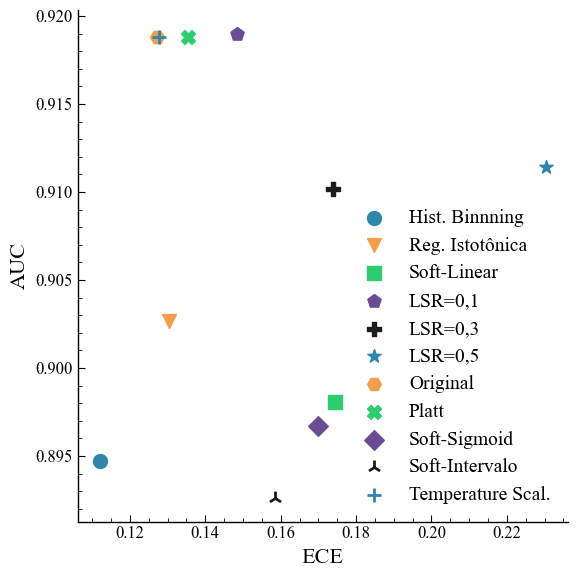

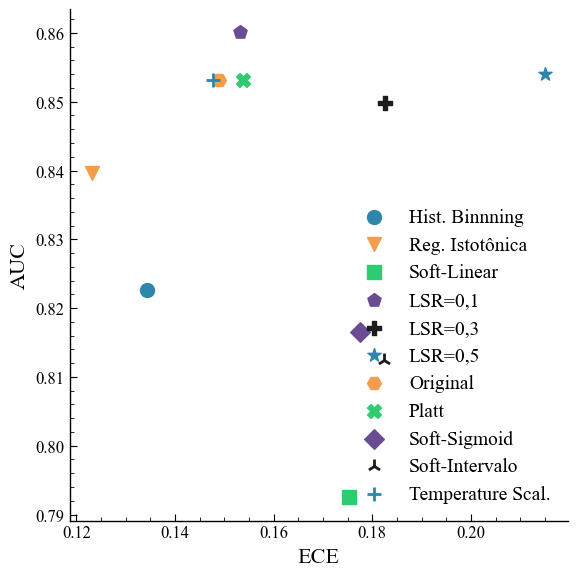

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from utils.plots import *
plt.style.use('utils\plotstyle.mplstyle')

auc_vgg = np.asarray([0.8947,0.9027,0.8981,0.9190,0.9102,0.9114,0.9188,0.9188,0.8967,0.8926,0.9188])
ece_vgg = np.asarray([0.1121,0.1303,0.1745,0.1483,0.1739,0.2303,0.1273,0.1354,0.1699,0.1584,0.1277])

auc_ncnn = np.asarray([0.8227,0.8396,0.7925,0.8601,0.8498,0.8540,0.8532,0.8532,0.8166,0.8125,0.8532])
ece_ncnn = np.asarray([0.1344,0.1232,0.1752,0.1531,0.1825,0.2151,0.1489,0.1538,0.1775,0.1824,0.1476])


labels = ["Hist. Binnning", "Reg. Istotônica", "Soft-Linear", "LSR=0,1", "LSR=0,3", "LSR=0,5", "Original",  "Platt", "Soft-Sigmoid",  "Soft-Intervalo", "Temperature Scal."]
markers = ["o", "v", "s", "p", "P", "*", "H", "X", "D", "2", "+", "d"]

plt.figure(figsize=(6,6))
for acc, ece, label, marker in zip(auc_vgg,ece_vgg, labels,markers):
    #plt.errorbar(ece, acc, acc_std, ece_std, marker="o", label=label, capsize=3, elinewidth=1, fmt='')
    plt.scatter(ece, acc, label=label, marker=marker, s=100)
    """
    if label=="LSR=0,5":
        plt.text(ece-0.01, acc+0.001, label, fontsize=15)
    elif label=="Soft-Linear":
        plt.text(ece-0.015, acc, label, fontsize=15)
    elif label=="Original":
        plt.text(ece, acc-0.002, label, fontsize=15)
    else:
        plt.text(ece, acc+0.001, label, fontsize=15)
    """
    
plt.grid()
plt.legend(labels, loc="lower right")
plt.xlabel("ECE")
plt.ylabel("AUC")
plt.savefig('VGG_ACC_ECE.pdf', dpi=100, bbox_inches='tight')

plt.figure(figsize=(6,6))
for acc, ece , label, marker in zip(auc_ncnn,ece_ncnn, labels, markers):
    #plt.errorbar(ece, acc, acc_std, ece_std, marker="o", label=label, capsize=3, elinewidth=1, fmt='')
    plt.scatter(ece, acc, label=label, marker=marker, s=100)
    """
    if label=="LSR=0,5":
        plt.text(ece-0.007, acc+0.001, label, fontsize=15)
    elif label=="Original":
        plt.text(ece, acc-0.002, label, fontsize=15)
    else:
        plt.text(ece, acc+0.001, label, fontsize=15)
    """
plt.grid()
plt.legend(labels, loc="lower right")
plt.xlabel("ECE")
plt.ylabel("AUC")
plt.savefig('NCNN_ACC_ECE.pdf', dpi=100, bbox_inches='tight')



# Resize Landmarks ()(())

In [6]:
import os
import pickle
from ast import literal_eval

import albumentations as A
import cv2
import pandas as pd
from tqdm import tqdm

from utils.utils import create_folder, scale_coords

import matplotlib.pyplot as plt
import numpy as np


In [7]:
# Read the data from the .csv
iCOPE_UNIFESP_data = pd.read_csv('iCOPE+UNIFESP_data.csv')
#iCOPE_UNIFESP_data['face_coordinates'] = iCOPE_UNIFESP_data['face_coordinates'].apply(lambda x: literal_eval(x))
#iCOPE_UNIFESP_data['keypoints_coordinates'] = iCOPE_UNIFESP_data['keypoints_coordinates'].apply(lambda x: literal_eval(x))

In [9]:
def resize_original_img(file_name):
    # Read image
    img = cv2.imread(os.path.join('Datasets\\DatasetFaces\\Images',file_name.split(".")[0]+".jpg"))
    # Get correspondent Face and keypoints coordinates
    #face_coords = iCOPE_UNIFESP_data[iCOPE_UNIFESP_data['new_file_name']==file_name.split(".")[0]+".jpg"]['face_coordinates'].values[0]

    with open(os.path.join('Datasets\\DatasetFaces\\Landmarks',file_name), 'rb') as f:
        keypoints_coords = np.array(pickle.load(f))
    
    # Scale the keypoints to the cropped face
    #scaled_keypoints = [scale_coords(x, y, face_coords) for x, y in keypoints_coords]

    if keypoints_coords.shape[0] != 106:
        print(keypoints_coords.shape)

    resized = resize(image=img, keypoints=keypoints_coords)

    with open(os.path.join("Datasets\\landmarks",file_name), 'wb') as f:
        pickle.dump(resized['keypoints'], f)

resize = A.Compose(
    [
        A.Resize(height=512, width=512, interpolation=cv2.INTER_CUBIC, p=1.0),
    ],
    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

for file in os.listdir('Datasets\\DatasetFaces\\Landmarks'):
    try:
        resize_original_img(file)
    except FileNotFoundError:
        print(f"File {file} not found")

File ID0_iCOPE_S00_air.pkl not found
File ID100_iCOPE_S10_air.pkl not found
File ID101_iCOPE_S10_cry.pkl not found
File ID102_iCOPE_S10_cry.pkl not found
File ID103_iCOPE_S10_cry.pkl not found
File ID104_iCOPE_S10_friction.pkl not found
File ID105_iCOPE_S10_pain.pkl not found
File ID106_iCOPE_S10_nopain.pkl not found
File ID107_iCOPE_S10_nopain.pkl not found
File ID108_iCOPE_S10_nopain.pkl not found
File ID109_iCOPE_S10_nopain.pkl not found
File ID10_iCOPE_S01_air.pkl not found
File ID110_iCOPE_S10_nopain.pkl not found
File ID111_iCOPE_S10_nopain.pkl not found
File ID112_iCOPE_S11_air.pkl not found
File ID113_iCOPE_S11_air.pkl not found
File ID114_iCOPE_S11_friction.pkl not found
File ID115_iCOPE_S11_friction.pkl not found
File ID116_iCOPE_S11_pain.pkl not found
File ID117_iCOPE_S11_pain.pkl not found
File ID118_iCOPE_S11_pain.pkl not found
File ID119_iCOPE_S11_pain.pkl not found
File ID11_iCOPE_S01_cry.pkl not found
File ID120_iCOPE_S11_pain.pkl not found
File ID121_iCOPE_S11_nopain.p

# TEST

In [ ]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

from XAI import attribution_mask_processing
from XAI.metrics import *
from corruption import region_patches

In [ ]:
landmarks_path = "Datasets\\landmarks\\ID1041_UNIFESP_S94_pain.pkl"
xai_mask_path = "experiments\\UNIFESP+iCOPE\\NCNN\\xai_masks\\FN\\ID1041_UNIFESP_S94_pain_GC_1_0_0.3798.pkl"
img_path = "Datasets\\DatasetFaces\\Images\\ID1041_UNIFESP_S94_pain.jpg"

In [ ]:
with open(landmarks_path, 'rb') as f:
    landmarks = np.array(pickle.load(f))

with open(xai_mask_path, 'rb') as f:
    xai_mask = np.array(pickle.load(f))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))

xai_mask = cv2.resize(xai_mask, (512,512))

xai_mask_processed, alpha = attribution_mask_processing(xai_mask)


xai_mask_processed = (xai_mask_processed * alpha)

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(xai_mask_processed)
for x,y in landmarks:
    plt.plot(x,y, 'ro')

In [ ]:
from XAI.metrics import *
region_masks = create_face_regions_masks(landmarks)

In [ ]:
test = region_masks['left_eye'] + region_masks['right_eye']

In [ ]:
plt.imshow(test)

In [ ]:
plt.imshow(region_patches(img, [test]))

In [ ]:
calculate_xai_score(xai_mask_processed, region_masks)


In [ ]:
while flag == 0:
                #for fold in range(5):
                    path = f'Datasets\\Folds\\{fold}\\Test'
                    for img_file in os.listdir(path):
                        if i in img_file:
                            img = cv2.imread(os.path.join(path, img_file))
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            flag = 1

                    fold += 1

                for xai in os.listdir(path_xai):
                    if '.pkl' in xai:
                        if '_'.join(xai.split('_')[:-4]) == i:
                            with open(os.path.join(path_xai, xai), 'rb') as f:
                                mask_GC  = pickle.load(f)

                            with open(os.path.join(path_xai, xai.replace('GC','IG')), 'rb') as f:
                                mask_IG  = pickle.load(f)

                            mask_GC = cv2.resize(mask_GC, (512,512))
                            mask_IG = cv2.resize(mask_IG, (512,512))
                        
                            break       
                if (i+".pkl") in os.listdir(path_mesh):
                    with open(os.path.join(path_mesh,f'{i}.pkl'), 'rb') as f:
                        face_mesh = np.array(pickle.load(f))
                else:
                    #face_mesh = fa.get_landmarks(img)
                    #with open(os.path.join(path_mesh,f'{i}_mesh.pkl'), 'wb') as f:
                        #pickle.dump(face_mesh, f)
                    print('problerm')

In [87]:
"""Utility script to apply the MCDP uncertainty method and generate XAI masks."""
import argparse
from PIL import Image
import numpy as np
import torch

from dataloaders.presets import PresetTransform
import models
from uncertainty.MCDropout import MCDropout
from XAI.GradCAM import GradCAM
from XAI.IntegratedGradients import IntegratedGradients


def get_model_and_layer(name: str):
    name = name.upper()
    if name == "NCNN":
        model = models.NCNN()
        target_layer = model.merge_branch[0]
        reshape = False
    elif name == "VGGFACE":
        model = models.VGGFace()
        target_layer = model.VGGFace.features[-1]
        reshape = False
    elif name == "VIT":
        model = models.ViT()
        target_layer = model.ViT.encoder.layers.encoder_layer_11.ln_1
        reshape = True
    else:
        raise ValueError(f"Unsupported model {name}")
    return model, target_layer, reshape


def load_image(path: str, model_name: str) -> torch.Tensor:
    image = Image.open(path).convert("RGB")
    #image = Image.open(path)
    transform = PresetTransform(model_name).transforms
    return transform(image).unsqueeze(0)


model_name = "NCNN"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, target_layer, reshape = get_model_and_layer(model_name)


state = torch.load(f'experiments\\NCNN\\20250718_0744_NCNN\\Model\\best_model.pt', map_location="cpu")
model.load_state_dict(state)

model = model.to(device)

img = load_image('Datasets\\Folds\\0\\Test\\ID72_iCOPE_S07_pain.jpg', model_name).to(device)

for m in model.modules():
    if m.__class__.__name__.startswith('Dropout'):
        m.p = 0.1
        m.train()

gradcam = GradCAM(model, target_layer, device=device, reshape_transform_ViT=reshape)
igrad = IntegratedGradients(model, device=device)

gradcam_masks = []
ig_masks = []

for _ in range(50):
    
    gradcam_masks.append(gradcam.attribution_mask(img)[0])
    ig_masks.append(igrad.attribution_mask(img)[0])

gradcam_stack = np.stack(gradcam_masks)
ig_stack = np.stack(ig_masks)

gc_mean, gc_std = gradcam_stack.mean(axis=0), gradcam_stack.std(axis=0)
ig_mean, ig_std = ig_stack.mean(axis=0), ig_stack.std(axis=0)


In [88]:
import matplotlib.pyplot as plt

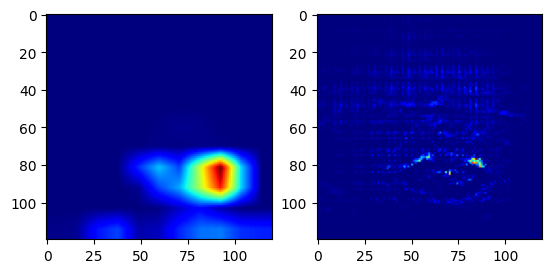

In [89]:
plt.subplot(121)
plt.imshow(gc_mean, cmap='jet')

plt.subplot(122)
plt.imshow(ig_mean, cmap='jet')

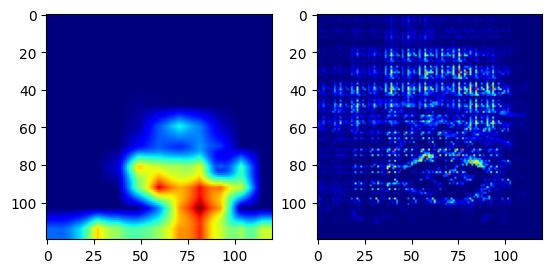

In [90]:
plt.subplot(121)
plt.imshow(gc_std, cmap='jet')

plt.subplot(122)
plt.imshow(ig_std, cmap='jet')

In [91]:
img.shape

torch.Size([1, 3, 120, 120])

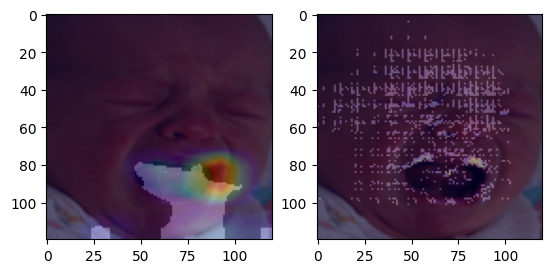

In [92]:

plt.subplot(121)
plt.imshow(gc_std>np.percentile(gc_std, 90), cmap='gray')
plt.imshow(gc_mean, cmap='jet', alpha=0.5)
plt.imshow(img[0].permute(1,2,0).cpu().detach(), alpha=0.5)

plt.subplot(122)
plt.imshow(ig_std>np.percentile(ig_std, 90), cmap='gray')
plt.imshow(ig_mean, cmap='jet', alpha=0.5)
plt.imshow(img[0].permute(1,2,0).cpu().detach(), alpha=0.5)

In [93]:
gc_mean_filtered = gc_mean * (gc_std <= np.percentile(gc_std, 90))

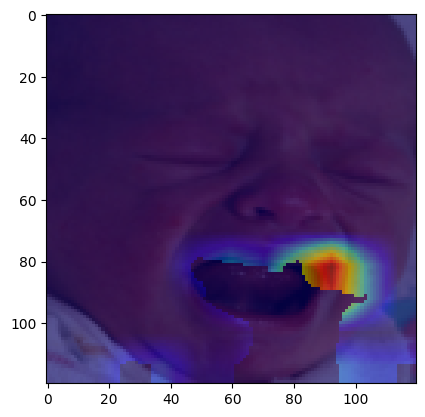

In [94]:
plt.imshow(gc_mean_filtered, cmap='jet')
plt.imshow(img[0].permute(1,2,0).cpu().detach(), alpha=0.5)

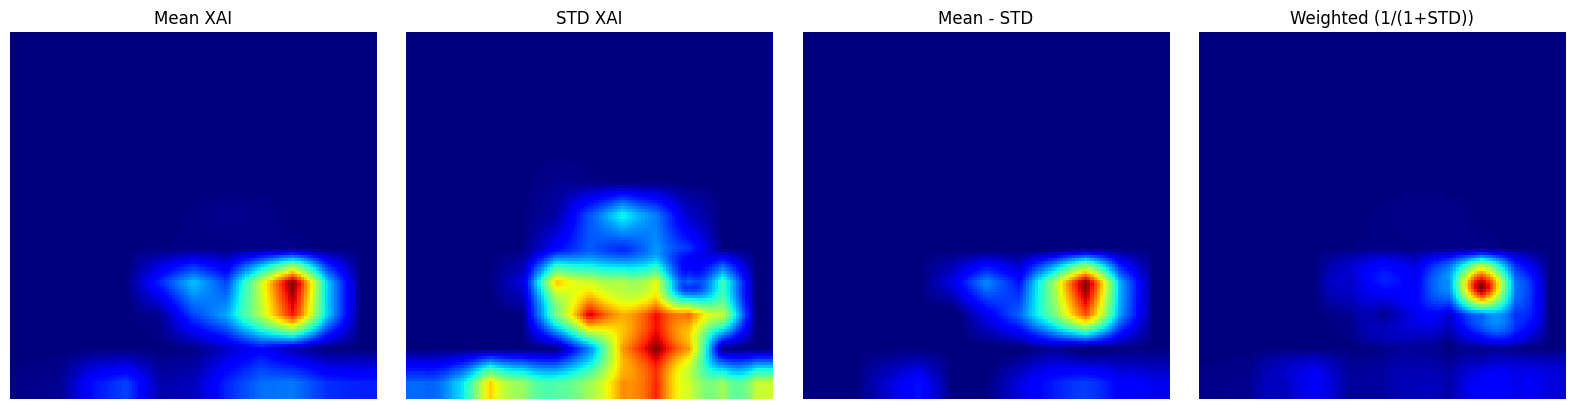

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you already have these as numpy arrays (H, W)
# xai_mean = ...
# xai_std = ...

# --- 1) Direct subtraction ---
# Penalize high-uncertainty regions
xai_mean = gc_mean
xai_std = gc_std

xai_adjusted = xai_mean - xai_std

# Clip values to [0, inf) if you want to avoid negatives
xai_adjusted = np.clip(xai_adjusted, a_min=0, a_max=None)

# --- 2) Ratio weighting ---
# Scale mean by relative confidence
xai_weighted = xai_mean * (1 / (1 + xai_std))  # higher std → smaller weight

# --- 3) Normalized subtraction (optional) ---
# Normalize std to [0,1] before subtracting
std_norm = (xai_std - xai_std.min()) / (xai_std.ptp() + 1e-8)
xai_norm_adjusted = xai_mean * (1 - std_norm)

# ----------------------------
# Visualization
# ----------------------------
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(xai_mean, cmap='jet'); ax[0].set_title("Mean XAI")
ax[1].imshow(xai_std, cmap='jet'); ax[1].set_title("STD XAI")
ax[2].imshow(xai_adjusted, cmap='jet'); ax[2].set_title("Mean - STD")
ax[3].imshow(xai_norm_adjusted, cmap='jet'); ax[3].set_title("Weighted (1/(1+STD))")

for a in ax: a.axis("off")
plt.tight_layout()
plt.show()


C:\Users\leonardo\AppData\Local\Temp\ipykernel_80172\1594653949.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_mean)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_80172\1594653949.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cb2 = plt.colorbar(cm.ScalarMappable(cmap=cm.get_cmap("gray")), cax=cax2)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_80172\1594653949.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbars


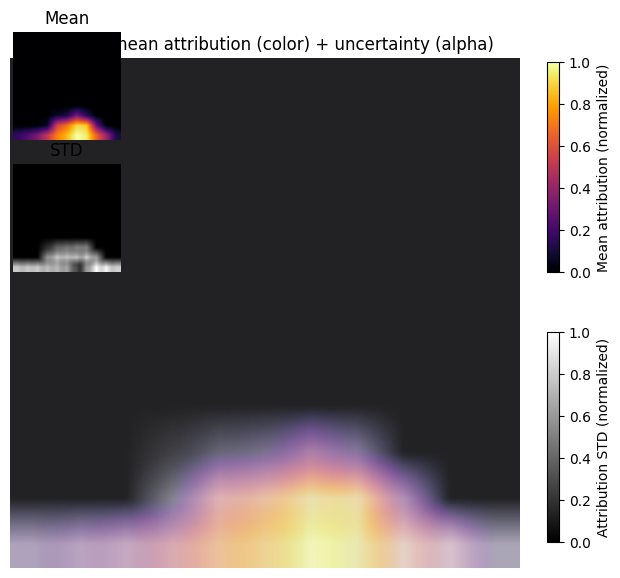

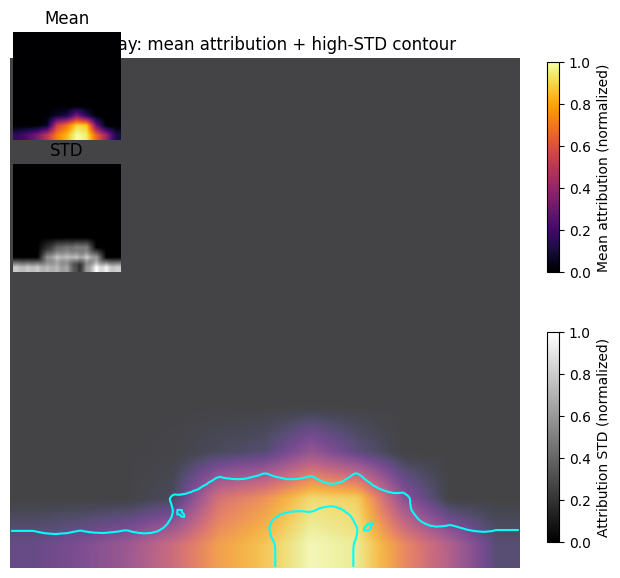

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

def _to_uint8(img):
    img = np.asarray(img, dtype=np.float32)
    if img.max() <= 1.0:
        img = img * 255.0
    return np.clip(img, 0, 255).astype(np.uint8)

def _normalize(x, eps=1e-8):
    x = np.asarray(x, dtype=np.float32)
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    if xmax - xmin < eps:
        return np.zeros_like(x, dtype=np.float32)
    return (x - xmin) / (xmax - xmin + eps)

def _resize_to(arr, size_hw):
    """Resize arr (H×W) or (H×W×C) to size_hw=(H,W) using PIL."""
    H, W = size_hw
    if arr.ndim == 2:
        mode = Image.BILINEAR
        im = Image.fromarray((arr * 255).astype(np.uint8))
        return np.asarray(Image.fromarray(np.asarray(im)).resize((W, H), resample=mode)) / 255.0
    elif arr.ndim == 3:
        mode = Image.BILINEAR
        im = Image.fromarray(_to_uint8(arr))
        return np.asarray(im.resize((W, H), resample=mode)).astype(np.float32) / 255.0
    else:
        raise ValueError("arr must be 2D or 3D")

def overlay_explanations(
    image,
    mean_map,
    std_map,
    cmap_mean="inferno",        # colormap for mean attribution
    mode="alpha",               # "alpha" or "contour"
    alpha_min=0.15,             # alpha at highest STD (more uncertain -> more transparent)
    alpha_max=0.85,             # alpha at lowest STD  (more certain   -> more opaque)
    contour_pct=90,             # percentile threshold for contouring high-STD regions
    contour_color="cyan",
    contour_linewidth=1.5,
    show_colorbars=True,
    title=None,
    figsize=(6, 6),
    savepath=None
):
    """
    Overlay mean attribution on the image, modulated by STD.
    - mode="alpha": high STD -> lower opacity over the image.
    - mode="contour": draw contour lines on top for the highest STD regions.
    """

    # Convert & normalize inputs
    img = np.asarray(image)
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("image must be H×W×3")
    H, W = img.shape[:2]

    mean_map = np.asarray(mean_map, dtype=np.float32)
    std_map  = np.asarray(std_map,  dtype=np.float32)

    # Resize maps to image if needed
    if mean_map.shape[:2] != (H, W):
        mean_map = _resize_to(_normalize(mean_map), (H, W))
    else:
        mean_map = _normalize(mean_map)

    if std_map.shape[:2] != (H, W):
        std_map = _resize_to(_normalize(std_map), (H, W))
    else:
        std_map = _normalize(std_map)

    # Colorize mean attribution
    cmap = cm.get_cmap(cmap_mean)
    mean_rgb = cmap(mean_map)[..., :3]   # H×W×3 in [0,1]

    # Build alpha from STD (inverse: high std -> low alpha)
    # alpha = alpha_max at std=0, alpha_min at std=1
    if mode == "alpha":
        alpha = alpha_max - std_map * (alpha_max - alpha_min)
    else:
        alpha = np.full((H, W), 0.7, dtype=np.float32)  # default alpha for non-alpha mode

    # Compose overlay: mean attribution on top of the original image
    base = _to_uint8(img)
    overlay = (alpha[..., None] * (mean_rgb * 255.0) + (1 - alpha[..., None]) * base).astype(np.uint8)

    # Plot
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.axis("off")

    ax.imshow(overlay)

    if mode == "contour":
        # Draw contours for top-k% STD
        thr = np.percentile(std_map, contour_pct)
        cs = ax.contour(std_map, levels=[thr], colors=contour_color, linewidths=contour_linewidth)

    if show_colorbars:
        # Add side colorbars for mean and std (as separate small axes)
        # Mean colorbar
        cax1 = fig.add_axes([0.92, 0.55, 0.02, 0.35])  # [left, bottom, width, height]
        cb1 = plt.colorbar(cm.ScalarMappable(cmap=cmap), cax=cax1)
        cb1.set_label("Mean attribution (normalized)")

        # STD colorbar
        cax2 = fig.add_axes([0.92, 0.10, 0.02, 0.35])
        cb2 = plt.colorbar(cm.ScalarMappable(cmap=cm.get_cmap("gray")), cax=cax2)
        cb2.set_label("Attribution STD (normalized)")

        # Show small previews (optional, helpful in papers)
        inset1 = fig.add_axes([0.03, 0.77, 0.18, 0.18]); inset1.axis('off'); inset1.set_title("Mean")
        im1 = inset1.imshow(mean_map, cmap=cmap); 
        inset2 = fig.add_axes([0.03, 0.55, 0.18, 0.18]); inset2.axis('off'); inset2.set_title("STD")
        im2 = inset2.imshow(std_map, cmap="gray")

    if title:
        ax.set_title(title)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbars
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# -----------------------
# Example (with dummy data)

H, W = 224, 224
img = np.ones((H, W, 3), dtype=np.float32) * 0.9
# synthetic mean map: a 2D Gaussian blob + gradient
y, x = np.mgrid[0:H, 0:W]
mean_map = np.exp(-(((x - W*0.6)**2 + (y - H*0.4)**2) / (2*(0.18*H)**2))) + (x / W)*0.2
# synthetic std: higher around a ring
r = np.sqrt((x - W*0.6)**2 + (y - H*0.4)**2)
std_map = np.exp(-((r - 0.25*H)**2) / (2*(0.08*H)**2))

# Overlay with alpha modulation (recommended)
overlay_explanations(
    img, gc_mean, gc_std,
    mode="alpha",
    title="Overlay: mean attribution (color) + uncertainty (alpha)"
)

# Overlay with contour highlighting high-STD regions
overlay_explanations(
    img, gc_mean, gc_std,
    mode="contour",
    contour_pct=90,
    contour_color="cyan",
    title="Overlay: mean attribution + high-STD contour"
)


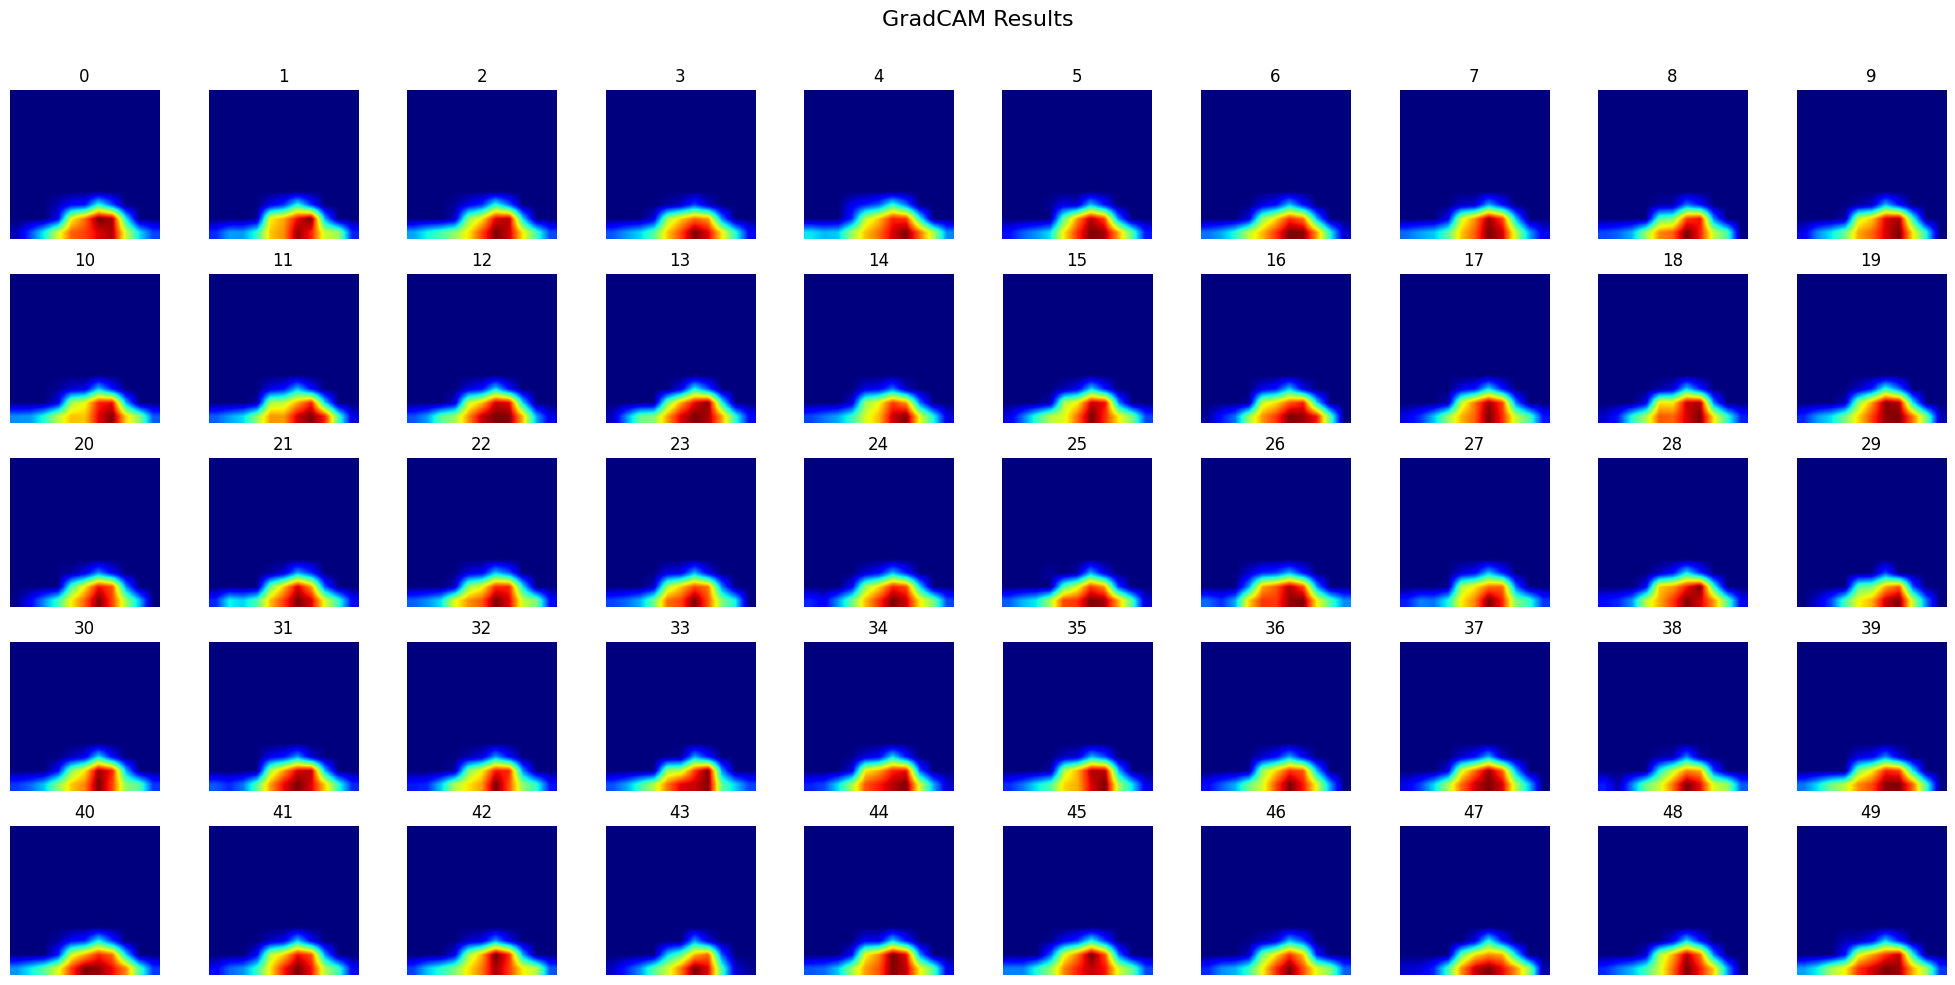

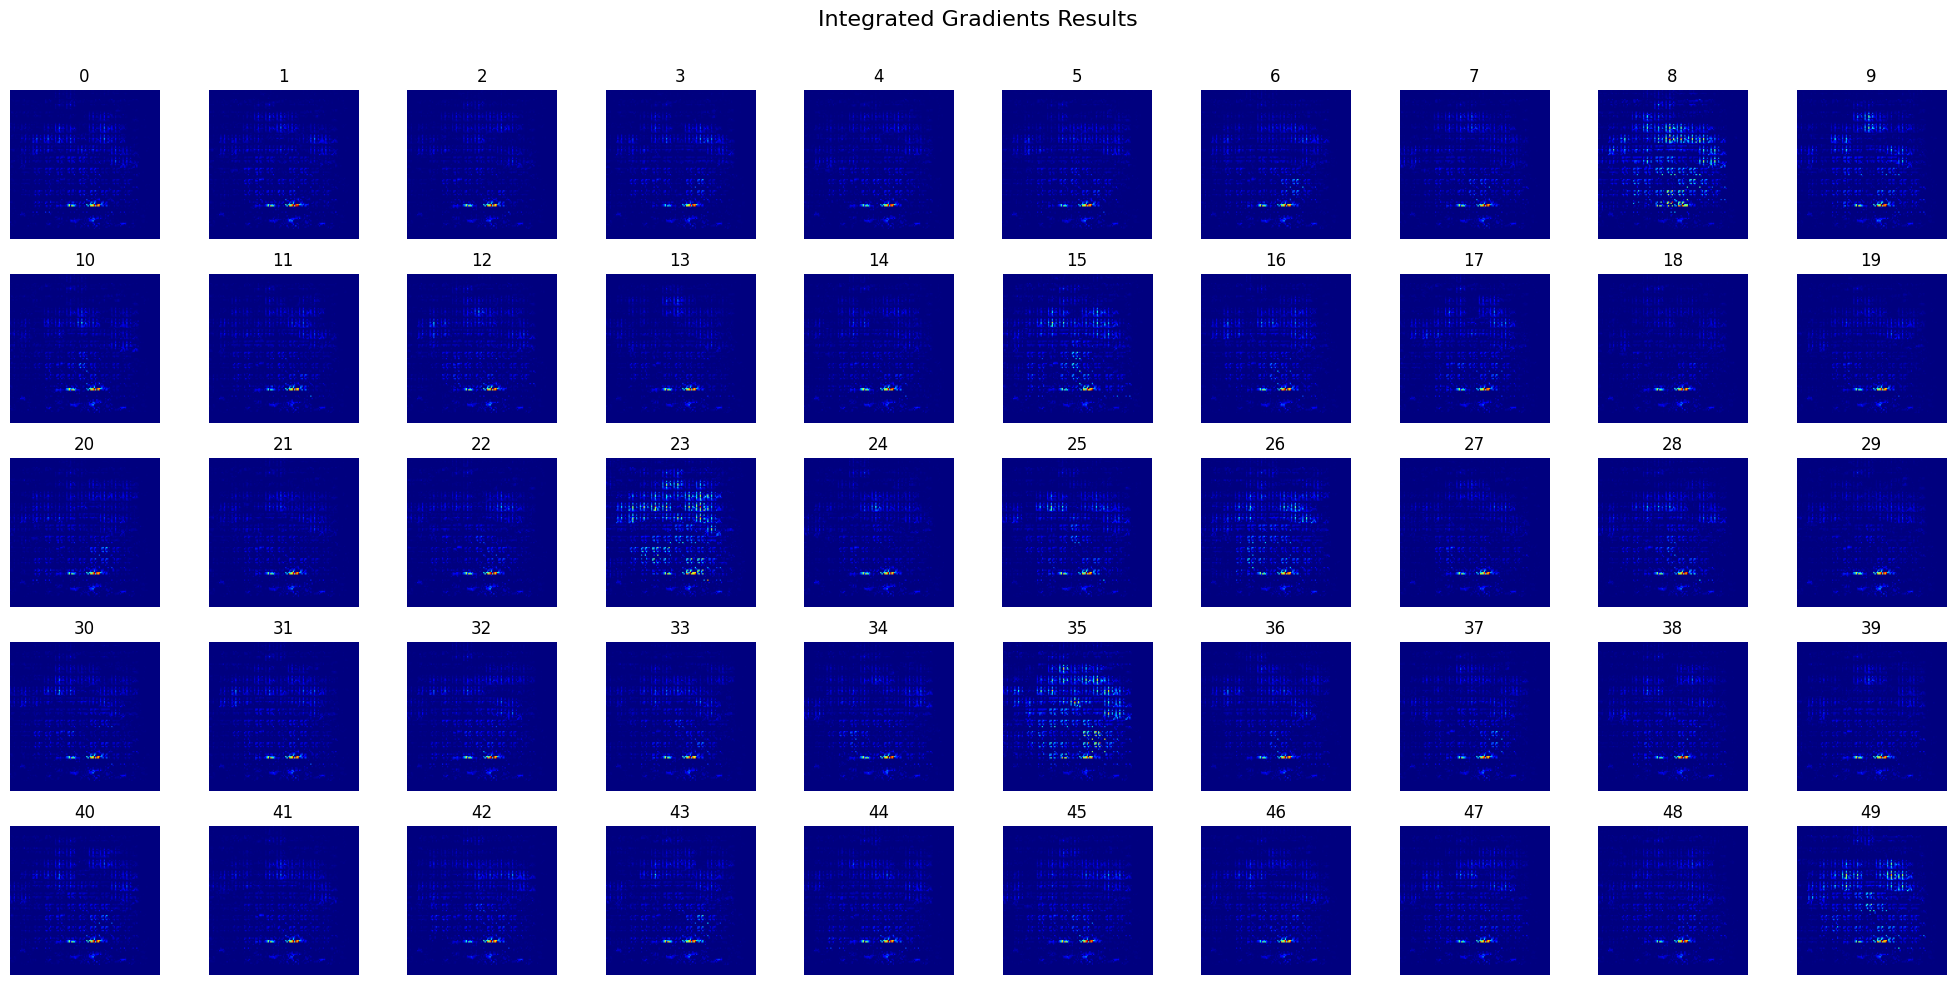

In [32]:
import matplotlib.pyplot as plt

# Set number of rows and columns
n_images = 50
cols = 10
rows = n_images // cols

# Plot GradCAM
plt.figure(figsize=(20, 10))
for i in range(n_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(gradcam_stack[i], cmap='jet')
    plt.axis('off')
    plt.title(f"{i}")
plt.suptitle("GradCAM Results", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # space for the title
plt.show()

# Plot Integrated Gradients
plt.figure(figsize=(20, 10))
for i in range(n_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(ig_stack[i], cmap='jet')
    plt.axis('off')
    plt.title(f"{i}")
plt.suptitle("Integrated Gradients Results", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [48]:
import glob, gzip, pickle, numpy as np, os
from tqdm import tqdm


def to_uint8(m): return (np.clip(m, 0, 1)*255).round().astype(np.uint8)

for p in tqdm(glob.glob('experiments\\ViT_B_32_ENSEMBLE_FINAL\\icopevid\\xai_masks_ENSEMBLE\\*\\*.pkl')):
    with open(p, 'rb') as f:
        obj = pickle.load(f)
    # Adapt this to your structure; here assume dict of arrays
    out = to_uint8(obj)
    npz_path = os.path.splitext(p)[0] + '.npz'
    np.savez_compressed(npz_path, mask=out)

    # Delete only if the .npz was created and is non-empty
    if os.path.exists(npz_path) and os.path.getsize(npz_path) > 0:
        os.remove(p)
        #print(f"Converted and deleted: {p} -> {npz_path}")
    else:
        print(f"Warning: {npz_path} not created; skipping delete for {p}")


100%|█████████▉| 266917/266918 [39:01<00:00, 114.02it/s]


UnpicklingError: pickle data was truncated